# Duplicated paragraphs between articles may impact analytics accuracy.

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import ast
from sklearn.preprocessing import StandardScaler
import wordcloud
import re
import os

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
import json

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the file path
file_path = '/content/drive/My Drive/Colab Notebooks/NLP_Ignas/nlp_finalproject/'

In [ ]:
%%time
# Each row is an article
df_merged = pd.read_csv(os.path.join(file_path, 'df_merged.csv'))
# Display the DataFrame
df_merged.head(2)

CPU times: user 31.7 s, sys: 4.82 s, total: 36.5 s
Wall time: 42.9 s


article_id  sentence_id  \
0           1            1   
1           1            2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   

                                                                                   entities  \
0                         [('July 4 2021', 'DATE'), ('AI', 'PRODUCT'), ('Universe', 'ORG')]   
1  [('CREDIT The Institute of Statistical Mathematics Japanese', 'ORG'), ('AI', 'PRODUCT')]   

  entities_combined  sentiment_score_DistilBERT sentiment_label_DistilBERT  \
0                []                    0.989424                    NEUTRAL   
1                []                    0.541715                   POSITIVE   

   sentiment_label_certainty        date       topic  
0                   0.000000  2021-07-05  AIResearch  
1                   0.541715  2021-07-05  AIResearch

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6523802 entries, 0 to 6523801
Data columns (total 10 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   article_id                  int64  
 1   sentence_id                 int64  
 2   sentence                    object 
 3   entities                    object 
 4   entities_combined           object 
 5   sentiment_score_DistilBERT  float64
 6   sentiment_label_DistilBERT  object 
 7   sentiment_label_certainty   float64
 8   date                        object 
 9   topic                       object 
dtypes: float64(2), int64(2), object(6)
memory usage: 497.7+ MB


In [ ]:
df_merged.shape

(6523802, 10)

Conditional Grouping by Category:

If category_col is specified:

- Data is grouped by both the category and the time period using .groupby([category_col, period_col]).
- The specified aggregation method is applied to the sentiment scores.
- A separate line is plotted for each unique category, showing its sentiment trend over time.

If category_col is not specified:

- Data is grouped only by the time period using .groupby(period_col).
- A single line for each aggregation method, showing the overall sentiment trend over time.

In [ ]:
def plot_sentiment_over_time(df, period_col, sentiment_col, aggregation_methods, category_col=None, xlabel='Time Period', ylabel='Sentiment Score', title='Sentiment Score Over Time'):
    """
    Plots the sentiment score over time for specified categories or overall if no category is specified.
    Supports multiple aggregation methods.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    period_col (str): Column name containing the time periods.
    sentiment_col (str): Column name containing the sentiment scores.
    aggregation_methods (list): List of aggregation methods to apply (e.g., 'mean', 'sum', 'count').
    category_col (str, optional): Column name representing the categories to group by (e.g., 'topic', 'entity'). Defaults to None.
    xlabel (str): Label for the X-axis. Defaults to 'Time Period'.
    ylabel (str): Label for the Y-axis. Defaults to 'Sentiment Score'.
    title (str): Title of the plot. Defaults to 'Sentiment Score Over Time'.
    """
    plt.figure(figsize=(14, 8))
    for agg_method in aggregation_methods:
        if agg_method not in ['mean', 'sum', 'count']:
            continue
        if category_col:
            agg_data = df.groupby([category_col, period_col])[sentiment_col].agg(agg_method).reset_index()
            for category in agg_data[category_col].unique():
                category_data = agg_data[agg_data[category_col] == category]
                plt.plot(category_data[period_col], category_data[sentiment_col], label=f'{agg_method} of {category}')
        else:
            agg_data = df.groupby(period_col)[sentiment_col].agg(agg_method).reset_index()
            plt.plot(agg_data[period_col], agg_data[sentiment_col], label=f'{agg_method} {sentiment_col}')

    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

Generate a heatmap that shows sentiment scores for various categories (e.g., topics, entities) over time, aggregated using a specified method. Heatmaps help in identifying patterns or trends in sentiment over time.

- Rows represent categories (e.g., topics or entities).
- Columns represent time periods.
- Cell Colors represent the aggregated sentiment score for a specific category and time period:

    Cool colors (e.g., blue) for lower scores.
    
    Warm colors (e.g., red) for higher scores.
- Color Bar provides a scale for interpreting the sentiment scores.

In [ ]:
def plot_sentiment_heatmap(df, period_col, sentiment_col, category_col, aggregation='mean'):
    """
    Plots a heatmap of sentiment scores over time for different categories based on a specified aggregation method.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    period_col (str): Column name for the period (e.g., 'year_month').
    sentiment_col (str): Column name for the sentiment score.
    category_col (str): Column name representing the categories to group by (e.g., 'topic', 'entity').
    aggregation (str): Aggregation method to use ('mean', 'sum', 'count').

    Returns:
    None: Displays a heatmap.
    """
    sentiment_matrix = df.pivot_table(index=category_col, columns=period_col, values=sentiment_col, aggfunc=aggregation)
    plt.figure(figsize=(14, 8))
    # sns.heatmap(sentiment_matrix, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': f'{aggregation.title()} Sentiment Score'})
    sns.heatmap(sentiment_matrix, annot=False, cmap="coolwarm", cbar_kws={'label': f'{aggregation.title()} Sentiment Score'})
    plt.title(f"{aggregation.title()} Sentiment Score Heatmap")
    plt.ylabel(category_col.capitalize())
    plt.xlabel('Time Period')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Create a horizontal bar chart that displays aggregated sentiment scores (e.g., mean, sum, count) for each category, providing a clear comparison of sentiment across categories.

A horizontal bar chart where:

- Bars: Represent the categories (e.g., topics, entities).
- Bar Length: Corresponds to the aggregated sentiment score for each category.
- X-axis: Aggregated sentiment scores.
- Y-axis: Categories being analyzed.

In [ ]:
def plot_sentiment_by_category(df, category_col, sentiment_col, aggregation='mean'):
    """
    Plots a horizontal bar chart of aggregated sentiment scores by category using specified aggregation.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    category_col (str): Column name representing the categories to analyze.
    sentiment_col (str): Column name for the sentiment scores.
    aggregation (str): Aggregation method ('mean', 'sum', 'count').

    Returns:
    None: Displays a horizontal bar chart.
    """
    # Group the DataFrame by the category_col and aggregate the sentiment_col using the specified method.
    # If category_col is "topic" and aggregation='mean', it calculates the average sentiment score for each topic.
    # The sorted result ensures smaller values appear at the top of the horizontal bar chart.
    agg_data = df.groupby(category_col)[sentiment_col].agg(aggregation).sort_values(ascending=True)
    plt.figure(figsize=(10, 8))
    agg_data.plot(kind='barh')
    plt.title(f'{aggregation.capitalize()} Sentiment Score by {category_col.capitalize()}')
    plt.xlabel(f'{aggregation.capitalize()} Sentiment Score')
    plt.ylabel(category_col.capitalize())
    plt.tight_layout()
    plt.show()

Return a subset of a DataFrame where a specified column contains any of the provided words. This is particularly useful for text-based filtering, such as finding rows where a column contains certain keywords.

A new DataFrame that:

- Contains only the rows where the specified column has at least one of the words from the list.
- Retains the original structure of the DataFrame (all columns).

Exact Word Matches:

Uses \b for strict word boundaries, ensuring "Art" matches only as a separate word and not as part of another word like "Artificial."

Case Insensitivity:

Ensures matches regardless of capitalization (e.g., "Art" matches "art").

In [ ]:
def filter_rows_by_words(df, column, words):
    """
    Filters the DataFrame rows based on the exact presence of specified words in a given column.
    Ensures exact matches while supporting case-insensitivity.

    Args:
        df (pd.DataFrame): The DataFrame to filter.
        column (str): The name of the column to search for the words.
        words (list or str): A word or list of words to search for in the specified column.

    Returns:
        pd.DataFrame: A DataFrame containing only the rows where the specified column
                      contains any of the exact words in the list.
    """
    # Ensure `words` is a list even if a single word is passed
    if isinstance(words, str):
        words = [words]

    # Create a regex pattern to match exact words with word boundaries
    pattern = r'\b(' + '|'.join(words) + r')\b'

    # Use str.contains with the regex pattern to filter rows
    filtered_df = df[df[column].str.contains(pattern, case=False, na=False)]
    return filtered_df


- Creates counters for each entity type.
- Iterates through the series, counting occurrences of each entity for the specified types.
- Extracts the top N entities for each type and ensures uniform length by padding with empty values if needed.

In [ ]:
# Count entities by type and return a DataFrame showing the top N entities for each specified type
def count_top_entities(entities_series, entity_types, top_n):
    """
    Count top N entities for specified entity types in a series of entity lists and return the counts in table format.

    :param entities_series: Pandas Series containing lists of entities (tuples of entity text and entity type)
                            A Pandas Series where each row contains a list of tuples.
                            Each tuple represents an entity with two components:
                            entity_text: The text of the entity (e.g., "Google").
                            entity_type: The type of entity (e.g., "ORG").
    :param entity_types: A list of entity types to analyze (e.g., ['ORG', 'PRODUCT', 'GPE', 'PERSON']).
    :param top_n: The number of top entities to display for each specified entity type.
    :return: DataFrame showing the top N entities for each specified type

    """
    counters = {entity_type: Counter() for entity_type in entity_types}

    # Iterate over the series to count entities by type
    # Loops through each list of entities in entities_series.
    # For each entity_text and entity_type:
    # If the entity_type is in the specified entity_types, it increments the count of entity_text in the corresponding Counter.
    for entities in entities_series:
        for entity_text, entity_type in entities:
            if entity_type in entity_types:
                counters[entity_type][entity_text] += 1


    # Prepare the DataFrame to display the top N entities for each type
    top_entities_df = pd.DataFrame()

    # For each entity type:
    # Retrieves the top N entities using most_common(top_n).
    # Formats the result as "entity_text (count)" and stores it in a column of the DataFrame.
    for entity_type in entity_types:
        top_entities = counters[entity_type].most_common(top_n)
        top_entities_df[entity_type] = [f"{entity[0]} ({entity[1]})" for entity in top_entities]

    return top_entities_df

Identify and visualize the top and worst entities based on their aggregated sentiment scores.

Iterate Over Rows:

- For each row, it extracts entities and their sentiment score.
- If the entity type is in entity_types and not in exclude_entities, its sentiment score is stored.

Aggregate Scores:

- Aggregates sentiment scores based on the chosen method:

'mean': Average sentiment score for each entity.

'sum': Total sentiment score for each entity.

'count': Count of sentiment scores for each entity.

- Only includes entities with at least min_count occurrences.

Sort Entities:

- Top entities: Entities with the highest scores (sorted in descending order).
- Worst entities: Entities with the lowest scores (sorted in ascending order).

Plotting:

Two horizontal bar charts are created:

- Top Plot: Displays top entities in descending order. Green bars represent entities with the highest aggregated sentiment scores.
- Bottom Plot: Displays worst entities in ascending order. Red bars represent entities with the lowest aggregated sentiment scores.

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from collections import defaultdict

# def plot_top_worst_entities(df, entity_col, sentiment_col, aggregation, entity_types, exclude_entities, top_n, min_count):
#     """
#     Plots the top and worst entities based on their aggregated sentiment scores,
#     considering specified entity types and excluding certain entities.

#     Args:
#         df (pd.DataFrame): DataFrame containing entities and sentiment scores.
#         entity_col (str): Column name containing entities in list of lists format.
#         sentiment_col (str): Column name containing sentiment scores.
#         aggregation (str): Aggregation method ('mean', 'sum', 'count').
#         entity_types (list): List of entity types to include.
#         exclude_entities (list): List of entity names to exclude.
#         top_n (int): Number of top and worst entities to display.
#         min_count (int): Minimum count for an entity to be included.
#     """
#     entity_scores = defaultdict(list)

#     # Process each entity in each row
#     for _, row in df.iterrows():
#         entities = row[entity_col]
#         sentiment_score = row[sentiment_col]
#         for entity in entities:
#             entity_name, entity_type = entity[0], entity[1]
#             if entity_type in entity_types and entity_name not in exclude_entities:
#                 entity_scores[entity_name].append(sentiment_score)

#     # Aggregate scores based on the specified method
#     if aggregation == 'mean':
#         aggregated_scores = {entity: np.mean(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
#     elif aggregation == 'sum':
#         aggregated_scores = {entity: np.sum(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
#     elif aggregation == 'count':
#         aggregated_scores = {entity: len(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
#     else:
#         raise ValueError(f"Invalid aggregation method: {aggregation}. Choose 'mean', 'sum', or 'count'.")

#     # Sort entities for top and worst
#     top_entities = sorted(aggregated_scores.items(), key=lambda item: item[1], reverse=True)[:top_n]
#     worst_entities = sorted(aggregated_scores.items(), key=lambda item: item[1])[:top_n]

#     # Adjust figure size and font size
#     fig, axes = plt.subplots(1, 2, figsize=(25, 10))
#     plt.rcParams.update({'font.size': 12})

#     # Shorten names to a maximum length
#     def shorten_names(name, max_length=30):
#         return name if len(name) <= max_length else name[:max_length - 3] + '...'

#     if top_entities:
#         top_names, top_scores = zip(*top_entities[::-1])
#         top_names = [shorten_names(name) for name in top_names]
#         axes[0].barh(top_names, top_scores, color='green')
#         axes[0].set_title('Top Entities')
#         axes[0].set_xlabel('Aggregated Sentiment Score')

#     if worst_entities:
#         worst_names, worst_scores = zip(*worst_entities[::-1])
#         worst_names = [shorten_names(name) for name in worst_names]
#         axes[1].barh(worst_names, worst_scores, color='red')
#         axes[1].set_title('Worst Entities')
#         axes[1].set_xlabel('Aggregated Sentiment Score')

#     plt.tight_layout()
#     plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from collections import defaultdict

# def plot_top_worst_entities(df, entity_col, sentiment_col, aggregation, entity_types, exclude_entities, top_n, min_count):
#     """
#     Plots the top and worst entities based on their aggregated sentiment scores as vertical bar charts,
#     considering specified entity types and excluding certain entities.

#     Args:
#         df (pd.DataFrame): DataFrame containing entities and sentiment scores.
#         entity_col (str): Column name containing entities in list of lists format.
#         sentiment_col (str): Column name containing sentiment scores.
#         aggregation (str): Aggregation method ('mean', 'sum', 'count').
#         entity_types (list): List of entity types to include.
#         exclude_entities (list): List of entity names to exclude.
#         top_n (int): Number of top and worst entities to display.
#         min_count (int): Minimum count for an entity to be included.
#     """
#     entity_scores = defaultdict(list)

#     # Process each entity in each row
#     for _, row in df.iterrows():
#         entities = row[entity_col]
#         sentiment_score = row[sentiment_col]
#         for entity in entities:
#             entity_name, entity_type = entity[0], entity[1]
#             if entity_type in entity_types and entity_name not in exclude_entities:
#                 entity_scores[entity_name].append(sentiment_score)

#     # Aggregate scores based on the specified method
#     if aggregation == 'mean':
#         aggregated_scores = {entity: np.mean(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
#     elif aggregation == 'sum':
#         aggregated_scores = {entity: np.sum(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
#     elif aggregation == 'count':
#         aggregated_scores = {entity: len(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
#     else:
#         raise ValueError(f"Invalid aggregation method: {aggregation}. Choose 'mean', 'sum', or 'count'.")

#     # Sort entities for top and worst
#     top_entities = sorted(aggregated_scores.items(), key=lambda item: item[1], reverse=True)[:top_n]
#     worst_entities = sorted(aggregated_scores.items(), key=lambda item: item[1])[:top_n]

#     # Adjust figure size and font size
#     fig, axes = plt.subplots(2, 1, figsize=(12, 18), gridspec_kw={'height_ratios': [1, 1]})
#     plt.rcParams.update({'font.size': 12})

#     # Shorten names to a maximum length
#     def shorten_names(name, max_length=20):
#         return name if len(name) <= max_length else name[:max_length - 3] + '...'

#     # Plot top entities (light green) - Sort in reverse order for left alignment
#     if top_entities:
#         top_names, top_scores = zip(*top_entities)
#         top_names = [shorten_names(name) for name in top_names]
#         axes[0].bar(top_names, top_scores, color='lightgreen')
#         axes[0].set_title('Top Entities')
#         axes[0].set_ylabel('Aggregated Sentiment Score')
#         axes[0].tick_params(axis='x', rotation=45)

#     # Plot worst entities (light red) - Sort in reverse order for left alignment
#     if worst_entities:
#         worst_names, worst_scores = zip(*worst_entities)
#         worst_names = [shorten_names(name) for name in worst_names]
#         axes[1].bar(worst_names, worst_scores, color='lightcoral')
#         axes[1].set_title('Worst Entities')
#         axes[1].set_ylabel('Aggregated Sentiment Score')
#         axes[1].tick_params(axis='x', rotation=45)

#     # Adjust layout for better label alignment
#     plt.tight_layout()
#     plt.subplots_adjust(hspace=0.4)
#     plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_top_worst_entities(df, entity_col, sentiment_col, aggregation, entity_types, exclude_entities, top_n, min_count):
    """
    Plots the top and worst entities based on their aggregated sentiment scores as vertical bar charts,
    considering specified entity types and excluding certain entities.

    Args:
        df (pd.DataFrame): DataFrame containing entities and sentiment scores.
        entity_col (str): Column name containing entities in list of lists format.
        sentiment_col (str): Column name containing sentiment scores.
        aggregation (str): Aggregation method ('mean', 'sum', 'count').
        entity_types (list): List of entity types to include.
        exclude_entities (list): List of entity names to exclude.
        top_n (int): Number of top and worst entities to display.
        min_count (int): Minimum count for an entity to be included.
    """
    entity_scores = defaultdict(list)

    # Process each entity in each row
    for _, row in df.iterrows():
        entities = row[entity_col]
        sentiment_score = row[sentiment_col]
        for entity in entities:
            entity_name, entity_type = entity[0], entity[1]
            if entity_type in entity_types and entity_name not in exclude_entities:
                entity_scores[entity_name].append(sentiment_score)

    # Aggregate scores based on the specified method
    if aggregation == 'mean':
        aggregated_scores = {entity: np.mean(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
    elif aggregation == 'sum':
        aggregated_scores = {entity: np.sum(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
    elif aggregation == 'count':
        aggregated_scores = {entity: len(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
    else:
        raise ValueError(f"Invalid aggregation method: {aggregation}. Choose 'mean', 'sum', or 'count'.")

    # Sort entities for top and worst
    top_entities = sorted(aggregated_scores.items(), key=lambda item: item[1], reverse=True)[:top_n]
    worst_entities = sorted(aggregated_scores.items(), key=lambda item: item[1])[:top_n]

    # Adjust figure size and font size
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [1, 1]})
    plt.rcParams.update({'font.size': 12})

    # Shorten names to a maximum length
    def shorten_names(name, max_length=20):
        return name if len(name) <= max_length else name[:max_length - 3] + '...'

    # Plot top entities (light green) - Maintain correct descending order
    if top_entities:
        top_names, top_scores = zip(*top_entities)
        top_names = [shorten_names(name) for name in top_names]
        axes[0].bar(top_names, top_scores, color='lightgreen')
        axes[0].set_title('Top Entities')
        axes[0].set_ylabel('Aggregated Sentiment Score')
        axes[0].set_xlabel('Entities')
        axes[0].tick_params(axis='x', rotation=45)

    # Plot worst entities (light red) - Maintain correct ascending order
    if worst_entities:
        worst_names, worst_scores = zip(*worst_entities)
        worst_names = [shorten_names(name) for name in worst_names]
        axes[1].bar(worst_names, worst_scores, color='lightcoral')
        axes[1].set_title('Worst Entities')
        axes[1].set_ylabel('Aggregated Sentiment Score')
        axes[1].set_xlabel('Entities')
        axes[1].tick_params(axis='x', rotation=45)

    # Adjust layout for better label alignment
    plt.tight_layout()
    plt.subplots_adjust(hspace=1.0)
    plt.show()

Create a word cloud visualization from a dictionary where the size of each word corresponds to its frequency or score.

In [ ]:
def generate_wordcloud(entities_scores, title):
    """
    Generates a word cloud from entities scores.

    Args:
        entities_scores (dict): A dictionary where keys are entity names and values are their scores.
        title (str): Title for the word cloud plot.
    """
    wc = wordcloud.WordCloud(width=800, height=600, max_words=100, background_color='white')
    wc.generate_from_frequencies(entities_scores)

    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

- Aggregates sentiment scores for entities based on a given method (e.g., mean, sum, count).
- Separates top entities (highest scores) and worst entities (lowest scores, only negatives).
- Generates two word clouds:
-- One for the top entities (positive scores).
-- One for the worst entities, with scores converted to absolute values for visualization.

In [ ]:
def plot_top_worst_entities_wordcloud(df, entity_col, sentiment_col, aggregation, entity_types, exclude_entities, top_n, min_count):
    """
    Plots word clouds for the top and worst entities based on their aggregated sentiment scores, with different scales for top and worst.
    Only considers negative scores for the worst entities.
    """
    entity_scores = defaultdict(list)

    # Process each entity in each row
    for _, row in df.iterrows():
        entities = row[entity_col]
        sentiment_score = row[sentiment_col]
        for entity in entities:
            entity_name, entity_type = entity[0], entity[1]
            if entity_type in entity_types and entity_name not in exclude_entities:
                entity_scores[entity_name].append(sentiment_score)

    # Aggregate scores and filter by min_count
    if aggregation == 'mean':
        aggregated_scores = {entity: np.mean(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
    elif aggregation == 'sum':
        aggregated_scores = {entity: np.sum(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
    elif aggregation == 'count':
        aggregated_scores = {entity: len(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}

    # Separate top and worst entities, ensuring worst entities have negative scores only
    sorted_scores = sorted(aggregated_scores.items(), key=lambda item: item[1], reverse=True)
    top_entities = dict(sorted_scores[:top_n])
    worst_entities = dict(sorted([(k, abs(v)) for k, v in sorted_scores if v < 0], key=lambda item: item[1], reverse=True)[:top_n])

    # Generate word clouds for top and worst entities with their respective titles
    generate_wordcloud(top_entities, 'Top Entities by Aggregated Sentiment Score')
    generate_wordcloud(worst_entities, 'Worst Entities by Aggregated Sentiment Score (Negative Scores Only)')

In [ ]:
# def plot_individual_entity_sentiment_over_time(df, period_col, sentiment_col, entities, entity_types=None, aggregation='mean'):
#     """
#     Plots sentiment scores over time for each specified entity individually, aggregating scores according to the specified method.

#     Args:
#         df (pd.DataFrame): DataFrame containing the sentiment data.
#         period_col (str): Column name for the time period.
#         sentiment_col (str): Column name for the sentiment scores.
#         entities (list): List of entities to plot.
#         entity_types (list, optional): List of entity types to filter by (e.g., ['ORG', 'GPE']). If None, all types are considered.
#         aggregation (str): Method for aggregating sentiment scores ('mean', 'sum', 'count').
#     """
#     plt.figure(figsize=(14, 8))

#     for entity in entities:
#         # Filter dataframe for rows containing the specified entity and entity types
#         def filter_entity(row):
#             entity_list = row['entities']
#             return any(e[0] == entity and (entity_types is None or e[1] in entity_types) for e in entity_list)

#         filtered_df = df[df.apply(filter_entity, axis=1)]

#         # Aggregate sentiment scores
#         if aggregation == 'mean':
#             agg_scores = filtered_df.groupby(period_col)[sentiment_col].mean()
#         elif aggregation == 'sum':
#             agg_scores = filtered_df.groupby(period_col)[sentiment_col].sum()
#         elif aggregation == 'count':
#             agg_scores = filtered_df.groupby(period_col)[sentiment_col].count()
#         else:
#             raise ValueError("Aggregation method must be 'mean', 'sum', or 'count'.")

#         # Plotting
#         agg_scores.plot(kind='line', label=entity)

#     # Adjust x-axis to show each month
#     plt.xticks(range(len(agg_scores.index)), agg_scores.index, rotation=45)

#     plt.title(f"Sentiment Over Time for Entities")
#     plt.ylabel(f"{aggregation.capitalize()} Sentiment Score")
#     plt.xlabel("Time Period")
#     plt.legend()
#     # plt.grid(True)  # This line was removed to eliminate grid lines
#     plt.tight_layout()
#     plt.show()

In [ ]:
def plot_individual_entity_sentiment_over_time(df, period_col, sentiment_col, entities, entity_types=None, aggregation='mean'):
    """
    Plots sentiment scores over time for each specified entity individually, aggregating scores according to the specified method.

    Args:
        df (pd.DataFrame): DataFrame containing the sentiment data.
        period_col (str): Column name for the time period.
        sentiment_col (str): Column name for the sentiment scores.
        entities (list): List of entities to plot.
        entity_types (list, optional): List of entity types to filter by (e.g., ['ORG', 'GPE']). If None, all types are considered.
        aggregation (str): Method for aggregating sentiment scores ('mean', 'sum', 'count').
    """
    plt.figure(figsize=(14, 8))

    for entity in entities:
        # Filter dataframe for rows containing the specified entity and entity types
        def filter_entity(row):
            entity_list = row['entities']
            return any(e[0] == entity and (entity_types is None or e[1] in entity_types) for e in entity_list)

        filtered_df = df[df.apply(filter_entity, axis=1)]

        # Aggregate sentiment scores
        if aggregation == 'mean':
            agg_scores = filtered_df.groupby(period_col)[sentiment_col].mean()
        elif aggregation == 'sum':
            agg_scores = filtered_df.groupby(period_col)[sentiment_col].sum()
        elif aggregation == 'count':
            agg_scores = filtered_df.groupby(period_col)[sentiment_col].count()
        else:
            raise ValueError("Aggregation method must be 'mean', 'sum', or 'count'.")

        # Plotting
        agg_scores.plot(kind='line', label=entity)

    # Set x-ticks based on actual values from `period_col`
    plt.xticks(ticks=range(len(df[period_col].unique())), labels=sorted(df[period_col].unique()), rotation=45)

    plt.title(f"Sentiment Over Time for Entities")
    plt.ylabel(f"{aggregation.capitalize()} Sentiment Score")
    plt.xlabel("Time Period")
    plt.legend()
    plt.tight_layout()
    plt.show()

Return a subset of rows from the DataFrame where the specified entity name and entity type are present in the entities column.

In [ ]:
def filter_df_by_entity_and_type(df, entity_name, entity_type):
    """
    Filters a DataFrame for rows containing a specific entity name and type.

    Args:
    df (pd.DataFrame): The DataFrame to filter.
    entity_name (str): The name of the entity to filter for.
    entity_type (str): The type of the entity to filter for.

    Returns:
    pd.DataFrame: A filtered DataFrame containing only rows with the specified entity name and type.
    """

    # If entities_list = [('Google', 'ORG'), ('John', 'PERSON')],
    # entity_name = 'Google', and entity_type = 'ORG', the function returns True.
    def contains_entity(entities_list):
        # Check if the specified entity name and type are in the entities list
        for entity in entities_list:
            name, typ = entity
            if typ == entity_type and name == entity_name:
                return True
        return False

    # Apply the function to each row's 'entities' column directly without ast.literal_eval
    filtered_df = df[df['entities'].apply(lambda x: contains_entity(x))]

    return filtered_df

In [ ]:
# Create a new column with year and month
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged['year_month'] = df_merged['date'].dt.to_period('M')
# Convert 'year_month' to string for plotting
df_merged['year_month'] = df_merged['year_month'].astype(str)

In [ ]:
df_merged.head(2)

article_id  sentence_id  \
0           1            1   
1           1            2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   

                                                                                   entities  \
0                         [('July 4 2021', 'DATE'), ('AI', 'PRODUCT'), ('Universe', 'ORG')]   
1  [('CREDIT The Institute of Statistical Mathematics Japanese', 'ORG'), ('AI', 'PRODUCT')]   

  entities_combined  sentiment_score_DistilBERT sentiment_label_DistilBERT  \
0                []                    0.989424                    NEUTRAL   
1                []                    0.541715                   POSITIVE   

   sentiment_label_certainty       date       topic year_month  
0                   0.000000 2021-07-05  AIResearch    2021-07  
1                   0.541715 2021-07-05  AIResearch    2021-07

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6523802 entries, 0 to 6523801
Data columns (total 11 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   article_id                  int64         
 1   sentence_id                 int64         
 2   sentence                    object        
 3   entities                    object        
 4   entities_combined           object        
 5   sentiment_score_DistilBERT  float64       
 6   sentiment_label_DistilBERT  object        
 7   sentiment_label_certainty   float64       
 8   date                        datetime64[ns]
 9   topic                       object        
 10  year_month                  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 547.5+ MB


### Overall Sentiment

### On sentence level, look at overall sentiment distribution

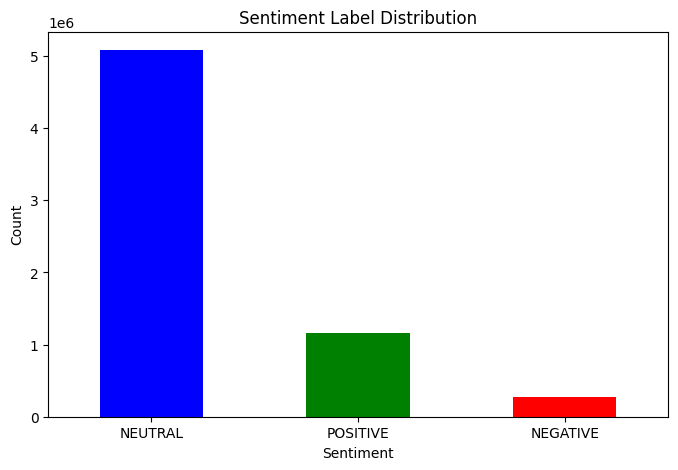

In [ ]:
import matplotlib.pyplot as plt
sentiment_counts = df_merged['sentiment_label_DistilBERT'].value_counts()

# Bar Chart
sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'], figsize=(8, 5))
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

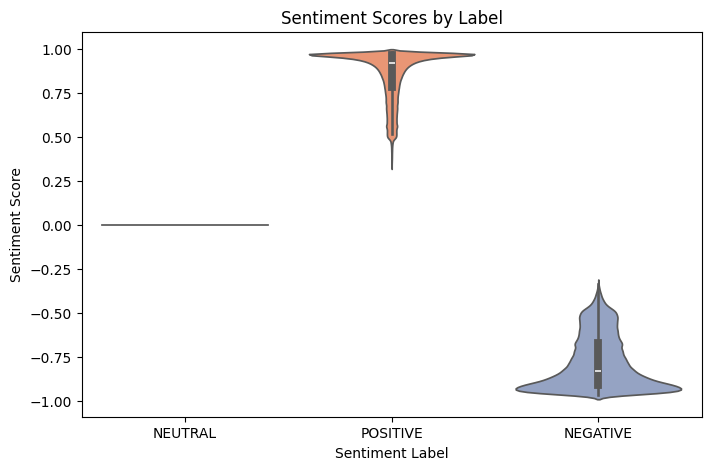

In [ ]:
# Violin Plot
plt.figure(figsize=(8, 5))
sns.violinplot(x='sentiment_label_DistilBERT', y='sentiment_label_certainty', data=df_merged, palette='Set2')
plt.title('Sentiment Scores by Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Sentiment Score')
plt.show()

Count the number of rows per year_month

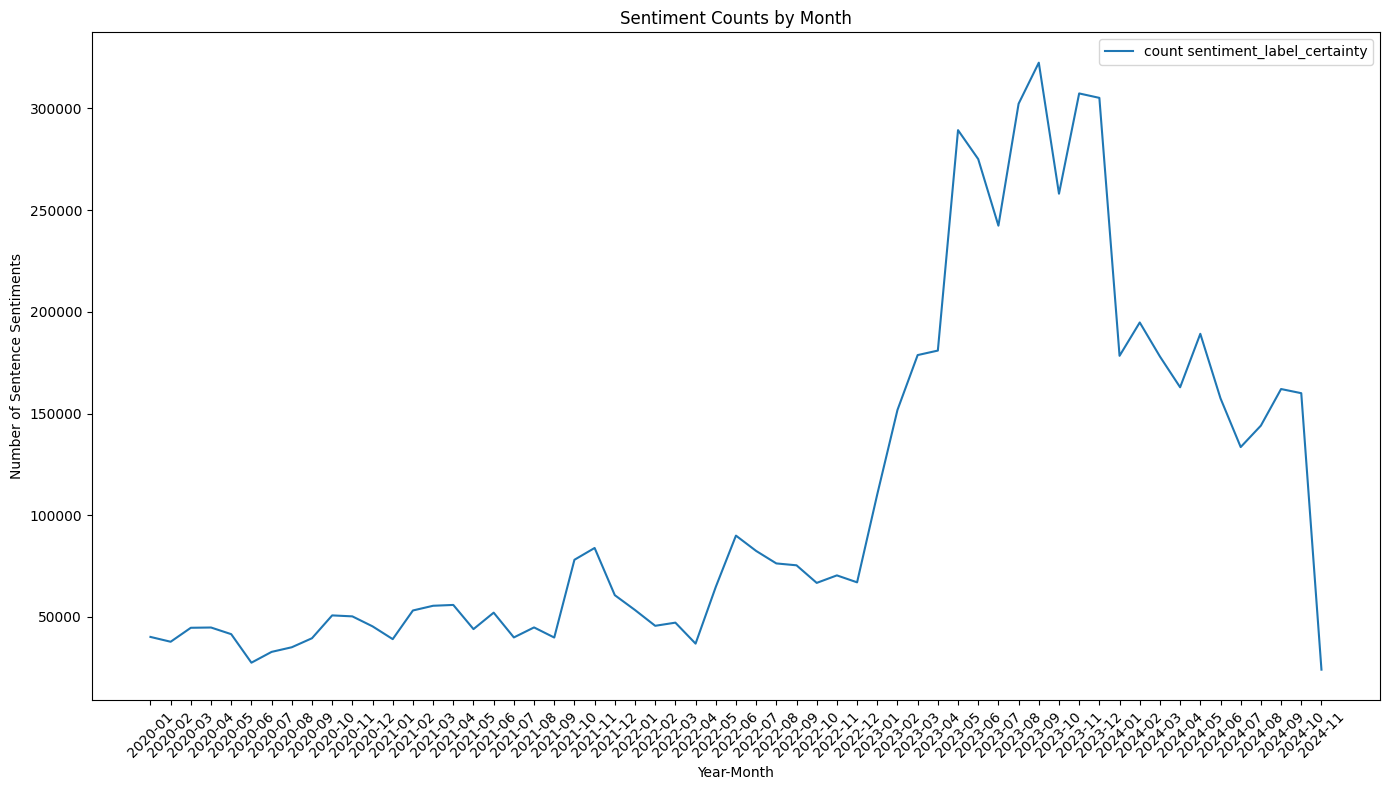

In [ ]:
plot_sentiment_over_time(
    df_merged,
    'year_month',
    'sentiment_label_certainty',
    ['count'],
    xlabel='Year-Month',
    ylabel='Number of Sentence Sentiments',
    title='Sentiment Counts by Month'
)

### Why the sentence counts are declining after 2023? I highly doubt the number of articles collected after 2023 were declining. Below I am validating my assumption!

In [ ]:
%%time
# Each row is an article
df_cleaned_final = pd.read_csv(os.path.join(file_path, 'df_cleaned_final.csv'))
# Display the DataFrame
df_cleaned_final.head(2)

CPU times: user 13.5 s, sys: 2.05 s, total: 15.5 s
Wall time: 17.7 s


article_id  \
0           1   
1           2   

                                                                                                       url  \
0  http://spaceref.com/astronomy/observation-simulation-and-ai-join-forces-to-reveal-a-clear-universe.html   
1                                                    http://www.agoravox.it/Covid-19-un-messaggio-dai.html   

         date language  \
0  2021-07-05       en   
1  2020-03-13       en   

                                                                                    title  \
0         Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef   
1  Covid-19 un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1  Covid-19 un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia Accedi Partecipa ad AgoraVox Iscriviti e proponi un articolo Home page Attualit Ambiente Cronaca Cronaca Locale Cultura Economia Europa Media Istruzione Mondo Politica Salute Religione Societ Scienza e Tecnologia Tribuna Libera Di' la tua Tempo Libero Gossip Redazionali Concorsi Cinema FameTulipani Incredibile ma vero La vignetta del giorno Moda e tendenze Pubblicazioni AgoraVox Recensioni Satira Musica e ...   

   token_count  
0          912  
1         2039

In [ ]:
df_cleaned_final.shape

(153749, 7)

In [ ]:
# Create a new column with year and month
df_cleaned_final['date'] = pd.to_datetime(df_cleaned_final['date'])
df_cleaned_final['year_month'] = df_cleaned_final['date'].dt.to_period('M')
# Convert 'year_month' to string for plotting
df_cleaned_final['year_month'] = df_cleaned_final['year_month'].astype(str)

In [ ]:
df_cleaned_final.head(2)

article_id  \
0           1   
1           2   

                                                                                                       url  \
0  http://spaceref.com/astronomy/observation-simulation-and-ai-join-forces-to-reveal-a-clear-universe.html   
1                                                    http://www.agoravox.it/Covid-19-un-messaggio-dai.html   

        date language  \
0 2021-07-05       en   
1 2020-03-13       en   

                                                                                    title  \
0         Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef   
1  Covid-19 un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1  Covid-19 un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia Accedi Partecipa ad AgoraVox Iscriviti e proponi un articolo Home page Attualit Ambiente Cronaca Cronaca Locale Cultura Economia Europa Media Istruzione Mondo Politica Salute Religione Societ Scienza e Tecnologia Tribuna Libera Di' la tua Tempo Libero Gossip Redazionali Concorsi Cinema FameTulipani Incredibile ma vero La vignetta del giorno Moda e tendenze Pubblicazioni AgoraVox Recensioni Satira Musica e ...   

   token_count year_month  
0          912    2021-07  
1         2039    2020-03

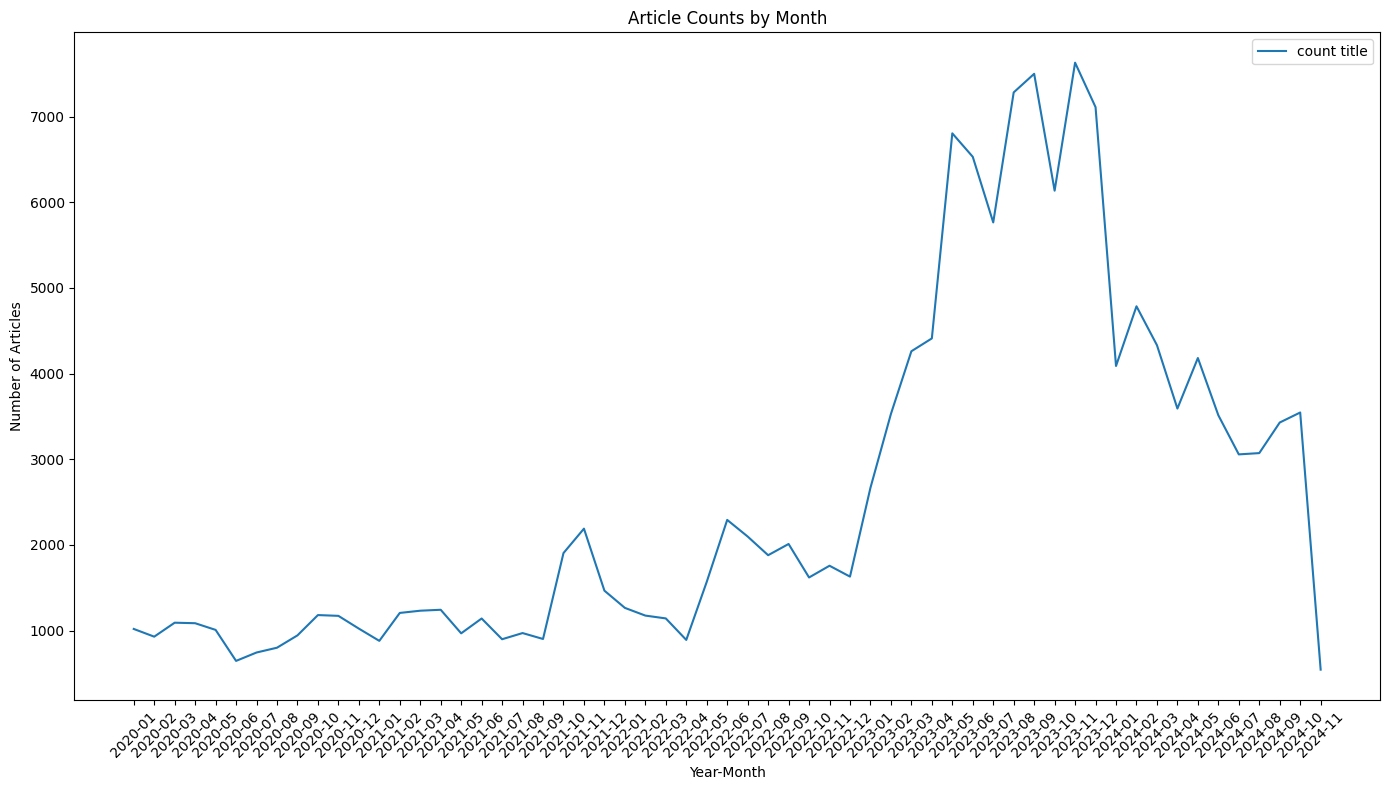

In [ ]:
plot_sentiment_over_time(
    df_cleaned_final,
    'year_month',
    'title',
    ['count'],
    xlabel='Year-Month',
    ylabel='Number of Articles',
    title='Article Counts by Month'
)

### I am correct! The number of articles after 2023 are declining!It does not necessarily mean the interest in AI is declining. Due to this sentences volume finding, I will use "mean" to represent sentiment below.

### Calculates the average sentiment_label_certainty score for all rows within each year_month, used as a proxy for strength.

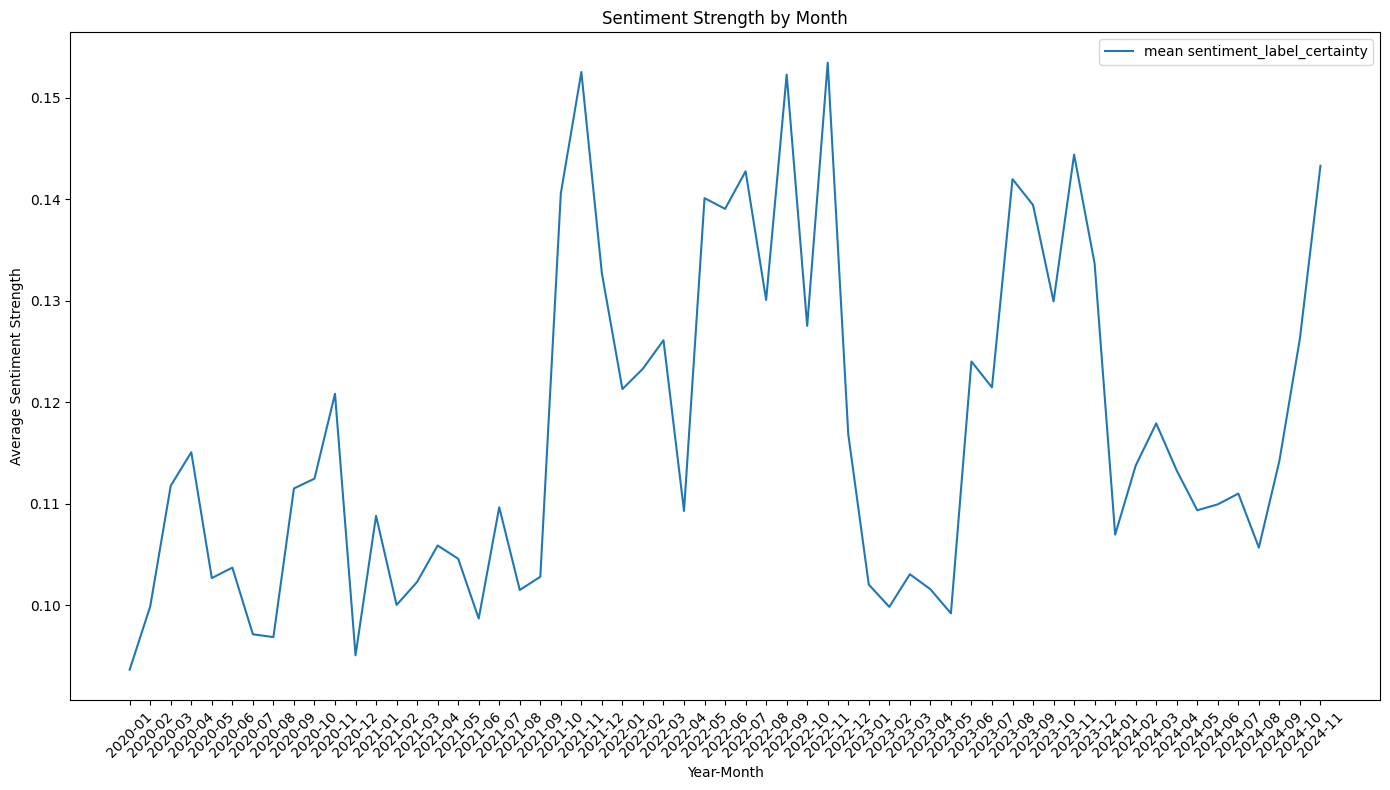

In [ ]:
plot_sentiment_over_time(
    df_merged,
    'year_month',
    'sentiment_label_certainty',
    ['mean'],
    xlabel='Year-Month',
    ylabel='Average Sentiment Strength',
    title='Sentiment Strength by Month'
)

### Mid-2020 to Early 2021: The announcement and early experiments with GPT-3 likely contributed to spikes in positivity, especially in tech-focused articles or public discussions.

### 2021 Onward: Broader adoption and integration into business solutions maintained sustained interest, possibly contributing to peaks.

### Ongoing (2022–2024): GPT-3 remains a foundational model in AI research and applications, though newer models like ChatGPT (based on GPT-3.5 and GPT-4) have since eclipsed its prominence.

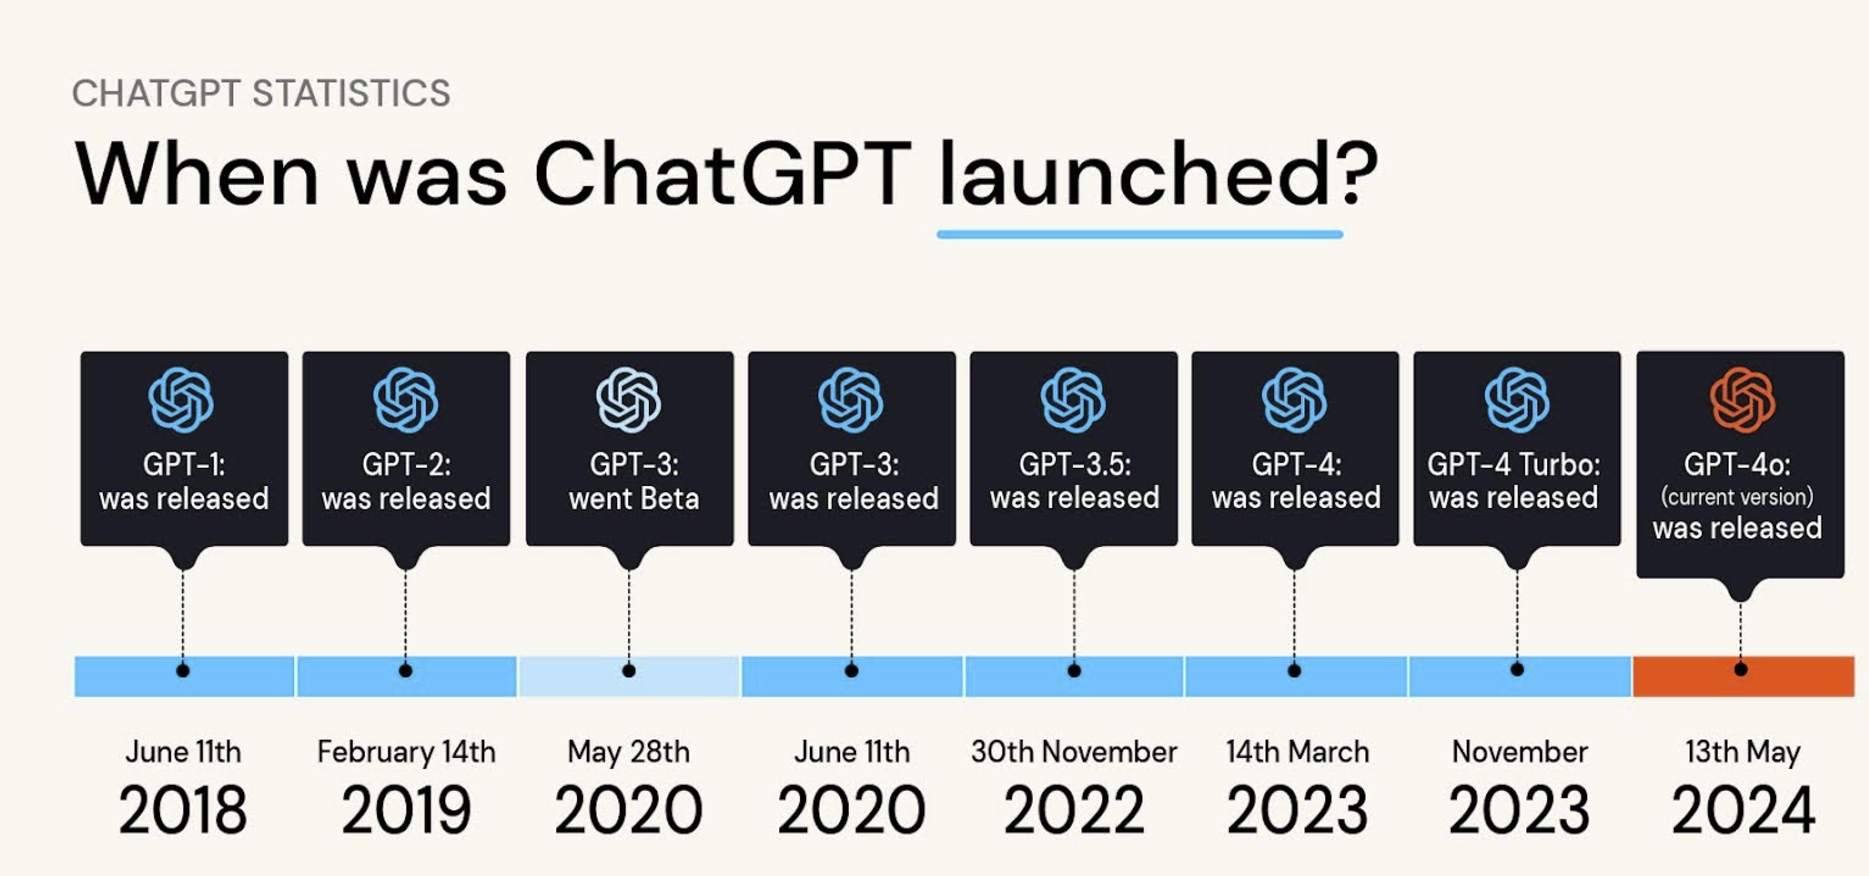

### Interestingly, the major releases of ChatGPT coincide with periods of relatively lower average sentiment strength on the 'Sentiment Strength by Month' chart. This inverse relationship may suggest a shift in focus or public sentiment during these key milestones.

### Sentiment by Article Topics

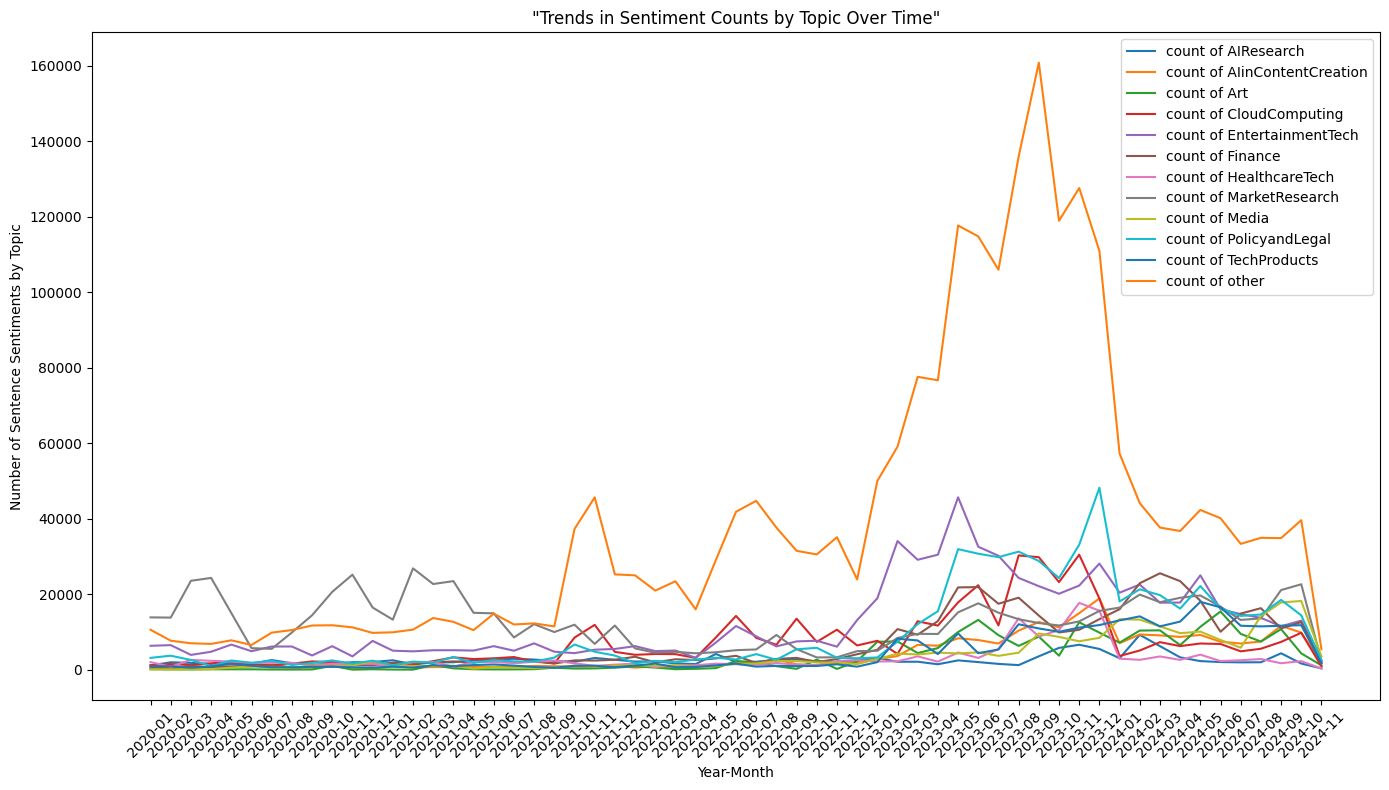

In [ ]:
plot_sentiment_over_time(
    df_merged,
    'year_month',
    'sentiment_label_certainty',
    ['count'],
    category_col='topic',
    xlabel='Year-Month',
    ylabel='Number of Sentence Sentiments by Topic',
    title='"Trends in Sentiment Counts by Topic Over Time"'
)

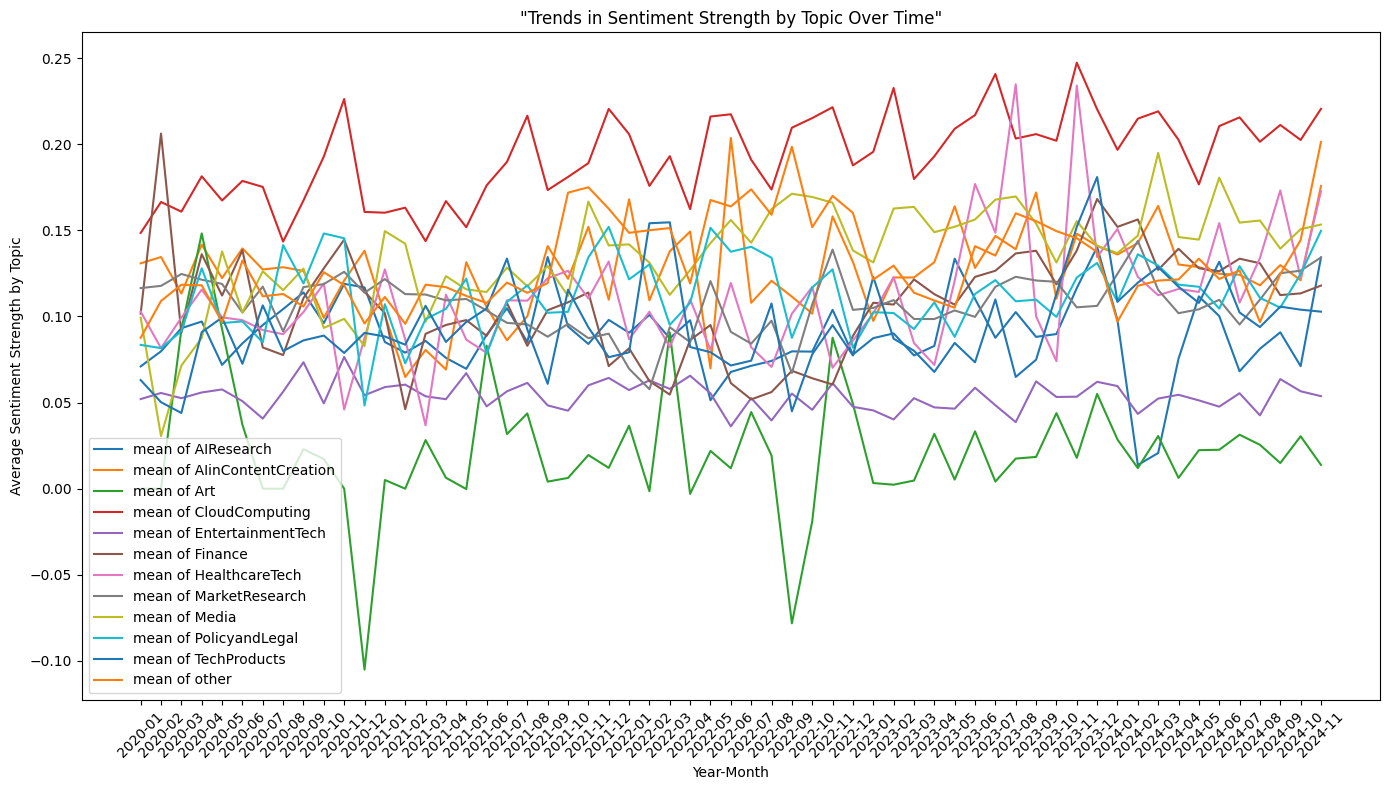

In [ ]:
plot_sentiment_over_time(
    df_merged,
    'year_month',
    'sentiment_label_certainty',
    ['mean'],
    category_col='topic',
    xlabel='Year-Month',
    ylabel='Average Sentiment Strength by Topic',
    title='"Trends in Sentiment Strength by Topic Over Time"'
)

### AIinContentCreation topic appears the most overall, far more than other topics.

### CloudComputing has the most postive sentiment strength over time.

### Art has the lowest positive sentiment strength over time.

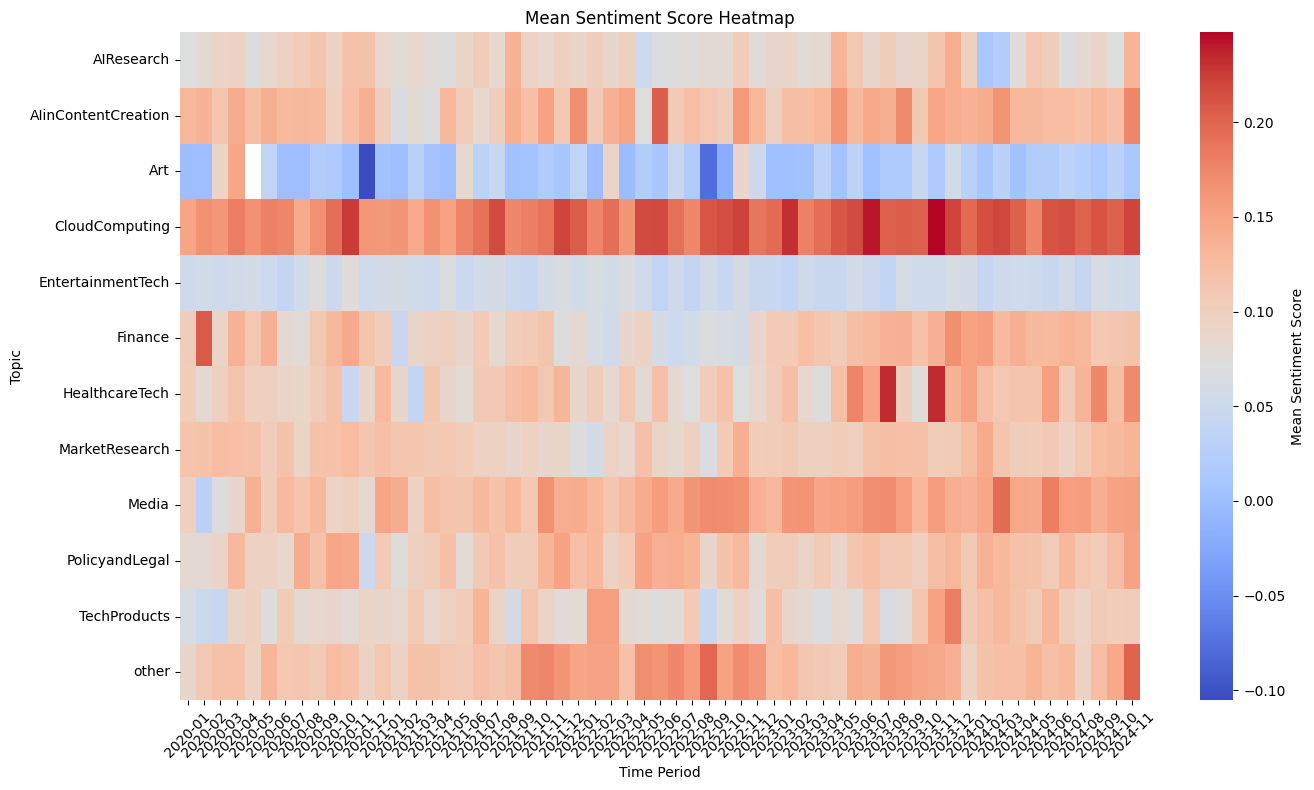

In [ ]:
plot_sentiment_heatmap(df_merged, 'year_month', 'sentiment_label_certainty', 'topic', aggregation='mean')

### HealthcareTech, Media, other, shows general shows increasing positive sentiment on AI over time.

### Heatmap validates that CloudCompluting has most postive sentiment strength over time while Art has lowest postive sentiment strength over time. Why?

In [ ]:
df_art = filter_rows_by_words(df_merged, 'sentence', 'Art')
df_art = filter_rows_by_words(df_art, 'sentence', 'AI')
df_art[df_art['topic'] == 'Art'].sort_values(by='sentiment_label_certainty',ascending=True).head(10)

article_id  sentence_id  \
4123395       97253            7   
6053667      142620           40   
3301804       77888           46   
3263515       76988           33   
6480045      152714           29   
468351        11057           37   
2688372       63477           37   
4614081      108816           66   
5641502      132921           26   
6024783      141938           62   

                                                                                                                                                                                                                                                                sentence  \
4123395  The conversation surrounding the use of AI in art has been exacerbated by the Writers Guild of America and Screen Actors Guild-American Federation of Television and Radio Artists strikes with their concerns including the threat of artificial intelligence.   
6053667                                                                                           Ziv Epstein a researcher at the MIT Media Lab's Human Dynamics Group says the advancement of AI image generators complicates notions of ownership in the art industry.   
3301804                                                                                           Ziv Epstein a researcher at the MIT Media Lab's Human Dynamics Group says the advancement of AI image generators complicates notions of ownership in the art industry.   
3263515                                                                                           Ziv Epstein a researcher at the MIT Media Lab's Human Dynamics Group says the advancement of AI image generators complicates notions of ownership in the art industry.   
6480045                                                                                           Ziv Epstein a researcher at the MIT Media Lab's Human Dynamics Group says the advancement of AI image generators complicates notions of ownership in the art industry.   
468351                                                                                            Ziv Epstein a researcher at the MIT Media Lab's Human Dynamics Group says the advancement of AI image generators complicates notions of ownership in the art industry.   
2688372                                                                                           Ziv Epstein a researcher at the MIT Media Lab's Human Dynamics Group says the advancement of AI image generators complicates notions of ownership in the art industry.   
4614081                                                                                           Ziv Epstein a researcher at the MIT Media Lab's Human Dynamics Group says the advancement of AI image generators complicates notions of ownership in the art industry.   
5641502                                                                                           Ziv Epstein a researcher at the MIT Media Lab's Human Dynamics Group says the advancement of AI image generators complicates notions of ownership in the art industry.   
6024783                                                                                                                                                            Native Stew - Bahamas AI Art Photos Videos Report Christianity and Its Negative Impact on The Bahamas   

                                                                                                                                     entities  \
4123395  [('AI', 'FAC'), ('the Writers Guild of America and Screen Actors Guild-American Federation of Television and Radio Artists', 'ORG')]   
6053667                       [('Ziv Epstein', 'PERSON'), ("the MIT Media Lab's", 'ORG'), ('Human Dynamics Group', 'ORG'), ('AI', 'PRODUCT')]   
3301804                       [('Ziv Epstein', 'PERSON'), ("the MIT Media Lab's", 'ORG'), ('Human Dynamics Group', 'ORG'), ('AI', 'PRODUCT')]   
3263515                       [('Ziv Epstein', 'PERSON'), ("the MIT Media Lab's", '

### Examples above shows strong negative sentiment on AI in Art.

In [ ]:
df_entertainmenttech = filter_rows_by_words(df_merged, 'sentence', 'entertainment')
df_entertainmenttech = filter_rows_by_words(df_entertainmenttech, 'sentence', 'AI')
df_entertainmenttech[df_entertainmenttech['topic'] == 'EntertainmentTech'].sort_values(by='sentiment_label_certainty',ascending=True).head(10)

article_id  sentence_id  \
5506564      129734            3   
1704512       40186           36   
6433514      151628           55   
5942034      140002           22   
4399443      103760            2   
2226400       52516            4   
5433211      127984           42   
951179        22399            7   
3437446       81103           38   
1048484       24738           57   

                                                                                                                                                                                                                                                                                                                                                                                                                                   sentence  \
5506564  Today's Paper Prayer Timing Epaper Home Latest National Sports World Business Entertainment Technology Health Oped Opinion Newspost Editorial Magazines Instep Money Matters YOU US TNS Sci-Tech IBM looks to cut back-office workforce by 30 with AI automation A study by Goldman Sachs revealed that AI-powered automation could result in the loss of up to 300 million jobs By Web Desk May 03 2023 IBM's CEO Arvind Krishna.   
1704512                                                                                                                                                                                                                                                             And in the entertainment industry Merchant notes writers and actors have been striking to protest attempts by studios to use AI to degrade their pay and job stability.   
6433514                                                                                                                                                                                                                                                                                                           Investment in AI startups for entertainment is blowing up right now said Michael Blank head of consumer investing at CAA.   
5942034                                                                                                                                                                                                                                                                       showsThe ongoing strikes by the Writers Guild of America and SAG-AFTRA has raised numerous warnings about AI uprooting the entertainment industry as a whole.   
4399443                                                                                                                                                                                                                                 Entertainment TV Shows Business Sci-Tech Sci-Tech Saturday May 06 2023 By Web Desk Home Sci-tech Google may fall behind in race for AI supremacy says its engineer By Web Desk Saturday May 06 2023   
2226400                                                                              Home Latest Most Read My Reads Saved India Cities Cricket Entertainment Editorials Elections World News Trending SamsungF12 Videos Lifestyle Education Web Stories Home World News Google AI scientist Bengio resigns after colleagues' firings Google Brain researcher Sara Hooker in a tweet described Bengio's departure as a huge loss for Google.   
5433211                                                                                                                                  Entertainment Arts How AI rendering program Midjourney sees Los Angeles a poem When the torrent of news stories about Bings Sydney rushed out in mid-February Bings parent company Microsoft reacted by limiting the number of questions a user was allowed to ask Bing in any given chat session.   
951179                People of colour are being systematically erased from visions of our future through the technology and entertainment industries repeated prese

### Examples above shows strong negative sentiment on AI in Entertainment. - Job Losses

### Sentiment by Entities

In [ ]:
df_merged['entities'].value_counts()

entities
[]                                                                                                                                                                     1726624
[('AI', 'PRODUCT')]                                                                                                                                                     135481
[('AI', 'ORG')]                                                                                                                                                          70424
[('Gray Media Group Inc.', 'ORG'), ('Gray Television Inc.', 'ORG')]                                                                                                      14050
[('one', 'CARDINAL')]                                                                                                                                                    13061
                                                                                                                                                                        ...   
[('Claudio Fantinuoli', 'PERSON'), ('Kudo AI', 'FAC')]                                                                                                                       1
[('Meta', 'ORG'), ('up to 100', 'CARDINAL')]                                                                                                                                 1
[('Tzachi Levy Kudos', 'PERSON'), ('AI', 'ORG'), ('the next year', 'DATE'), ('AI', 'ORG'), ('90', 'CARDINAL')]                                                               1
[('Microsoft Teams', 'ORG'), ('Kudos', 'PERSON')]                                                                                                                            1
[('General Production Health Protection Governance Science Arts Culture Travel Press Releases', 'ORG'), ('Matmerize', 'PERSON'), ('DOD', 'ORG'), ('AI', 'PRODUCT')]          1
Name: count, Length: 1944281, dtype: int64

In [ ]:
df_merged.head(2)

article_id  sentence_id  \
0           1            1   
1           1            2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   

                                                                                   entities  \
0                         [('July 4 2021', 'DATE'), ('AI', 'PRODUCT'), ('Universe', 'ORG')]   
1  [('CREDIT The Institute of Statistical Mathematics Japanese', 'ORG'), ('AI', 'PRODUCT')]   

  entities_combined  sentiment_score_DistilBERT sentiment_label_DistilBERT  \
0                []                    0.989424                    NEUTRAL   
1                []                    0.541715                   POSITIVE   

   sentiment_label_certainty       date       topic year_month  
0                   0.000000 2021-07-05  AIResearch    2021-07  
1                   0.541715 2021-07-05  AIResearch    2021-07

In [ ]:
df_merged.shape

(6523802, 11)

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6523802 entries, 0 to 6523801
Data columns (total 11 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   article_id                  int64         
 1   sentence_id                 int64         
 2   sentence                    object        
 3   entities                    object        
 4   entities_combined           object        
 5   sentiment_score_DistilBERT  float64       
 6   sentiment_label_DistilBERT  object        
 7   sentiment_label_certainty   float64       
 8   date                        datetime64[ns]
 9   topic                       object        
 10  year_month                  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 547.5+ MB


In [ ]:
import ast

def safe_literal_eval(val):
    """
    Safely evaluates a value using ast.literal_eval.
    Returns the original value if it cannot be evaluated.
    """
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None  # Replace invalid rows with None

# Apply safe parsing to the 'entities' column
df_merged['entities'] = df_merged['entities'].apply(
    lambda x: safe_literal_eval(str(x)) if isinstance(x, str) else x
)

In [ ]:
df_merged.head(2)

article_id  sentence_id  \
0           1            1   
1           1            2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   

                                                                           entities  \
0                             [(July 4 2021, DATE), (AI, PRODUCT), (Universe, ORG)]   
1  [(CREDIT The Institute of Statistical Mathematics Japanese, ORG), (AI, PRODUCT)]   

  entities_combined  sentiment_score_DistilBERT sentiment_label_DistilBERT  \
0                []                    0.989424                    NEUTRAL   
1                []                    0.541715                   POSITIVE   

   sentiment_label_certainty       date       topic year_month  
0                   0.000000 2021-07-05  AIResearch    2021-07  
1                   0.541715 2021-07-05  AIResearch    2021-07

In [ ]:
# Count entities by type
entity_types = ['LOC', 'ORG', 'PRODUCT', 'GPE', 'PERSON', 'LANGUAGE', 'EVENT', 'LAW']
top_n = 100

top_entities_df = count_top_entities(df_merged['entities'], entity_types, top_n)
top_entities_df

LOC  \
0                                                                                                                                                                                                        Europe (14785)   
1                                                                                                                                                                                                         Africa (6765)   
2                                                                                                                                                                                                  North America (6470)   
3                                                                                                                                                                                                    Middle East (5216)   
4                                                                                                                                                                                                           Asia (5081)   
5                                                                                                                                                                                                 Silicon Valley (4212)   
6                                                                                                                                                                                                          Earth (3768)   
7                                                                                                                                                                                                   Asia Pacific (2380)   
8                                                                                                                                                                                                the Middle East (2306)   
9                                                                                                                                                                                                  Latin America (2191)   
10                                                                                                                                                                                          North America Europe (1874)   
11                                                                                                                                                                                                          Mars (1696)   
12                                                                                                                                                                                                      Americas (1491)   
13                                                                                                                                                                                                 South America (1405)   
14                                                                                                                                                                                                Southeast Asia (1255)   
15                                                                                                                                                                                            Middle East Africa (1116)   
16                                                                                                                                                                                                   Asia-Pacific (933)   
17                                                                                                                                                                                               Silicon Valley's (881)   
18                                                 

### Sentiment by ORG

In [ ]:
df_merged.head(2)

article_id  sentence_id  \
0           1            1   
1           1            2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   

                                                                           entities  \
0                             [(July 4 2021, DATE), (AI, PRODUCT), (Universe, ORG)]   
1  [(CREDIT The Institute of Statistical Mathematics Japanese, ORG), (AI, PRODUCT)]   

  entities_combined  sentiment_score_DistilBERT sentiment_label_DistilBERT  \
0                []                    0.989424                    NEUTRAL   
1                []                    0.541715                   POSITIVE   

   sentiment_label_certainty       date       topic year_month  
0                   0.000000 2021-07-05  AIResearch    2021-07  
1                   0.541715 2021-07-05  AIResearch    2021-07

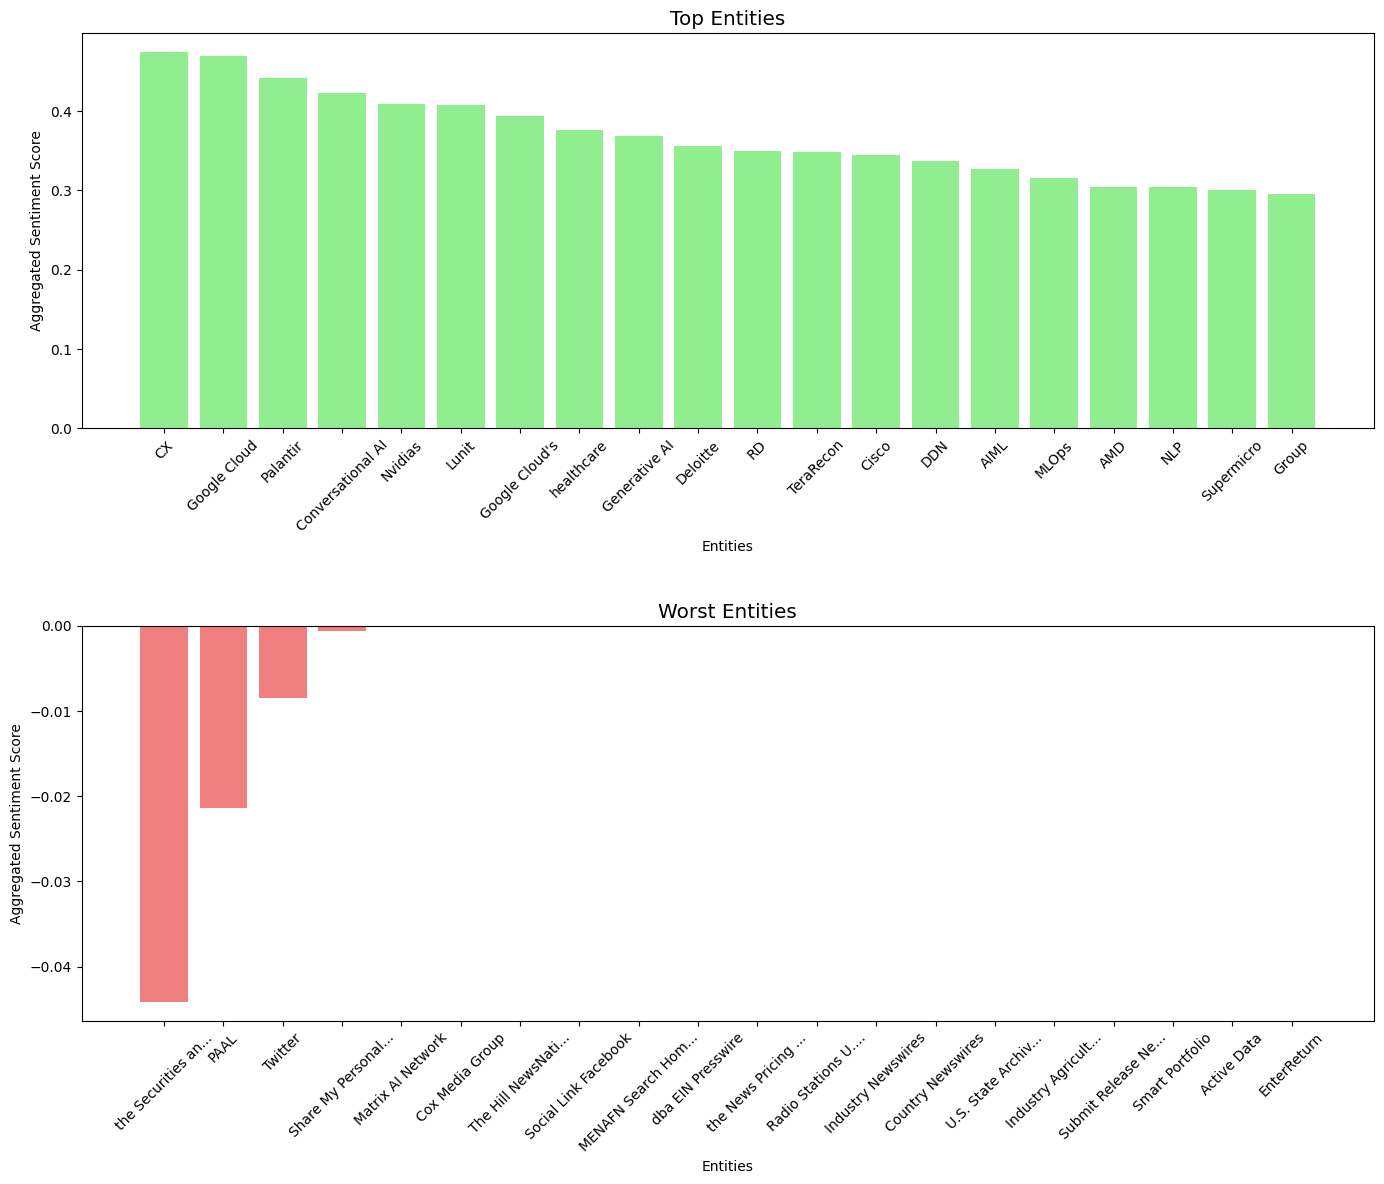

In [ ]:
# Define the DataFrame columns for entities and sentiment scores
entity_col = 'entities'
sentiment_col = 'sentiment_label_certainty'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'mean'
entity_types = ['ORG']
exclude_entities = ['AI', 'Artificial Intelligence', 'Artificial Intelligence AI', 'the Artificial Intelligence', 'BureauInvestigate',
                    'Healthcare', 'Company', 'ML', 'Gray Media Group', 'Gray Media Group Inc.', 'Gray Television Inc.', 'CaptioningAudio',
                    'Gray Media Group Inc.NewsFirst',
                    'General Production Health Protection Governance Science Arts Culture Travel Press Releases', 'Save data Data']

top_n = 20
min_count = 1500


plot_top_worst_entities(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

Google Cloud, Palantir, Conversational AI, Nvidias, healthcare, Generative AI stands out among top positive sentiment organizations!



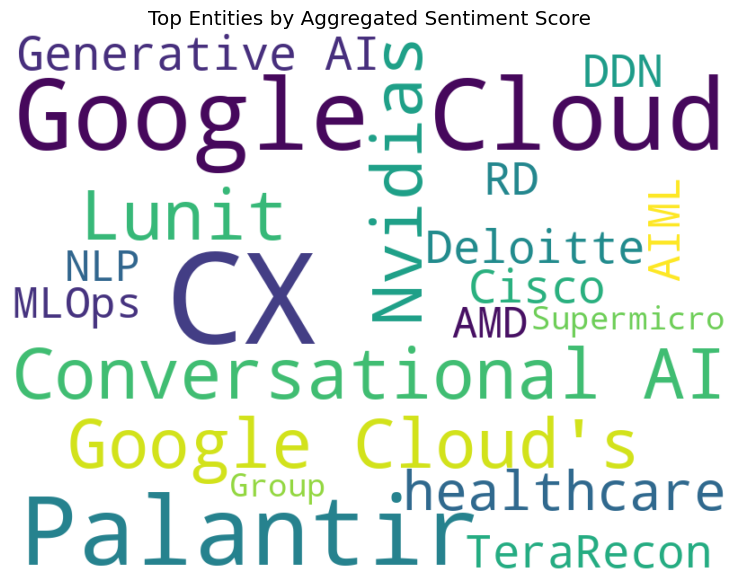

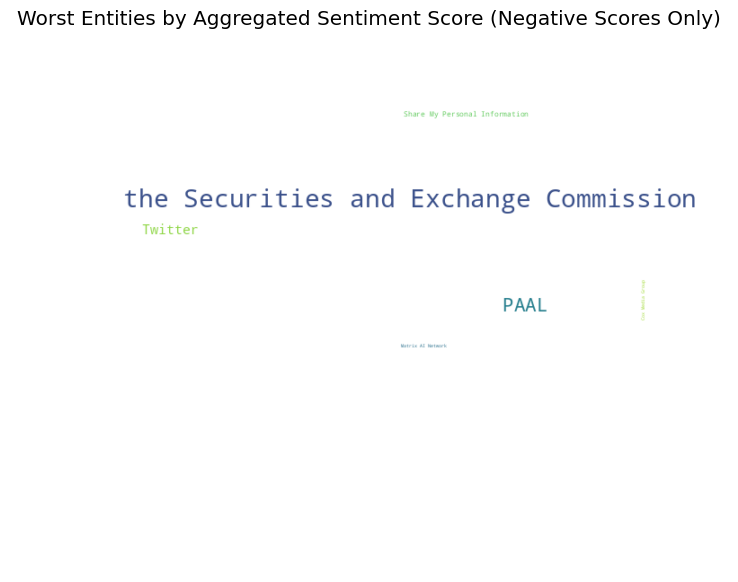

In [ ]:
plot_top_worst_entities_wordcloud(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

In [ ]:
aggregation_method

'mean'

In [ ]:
sentiment_col

'sentiment_label_certainty'

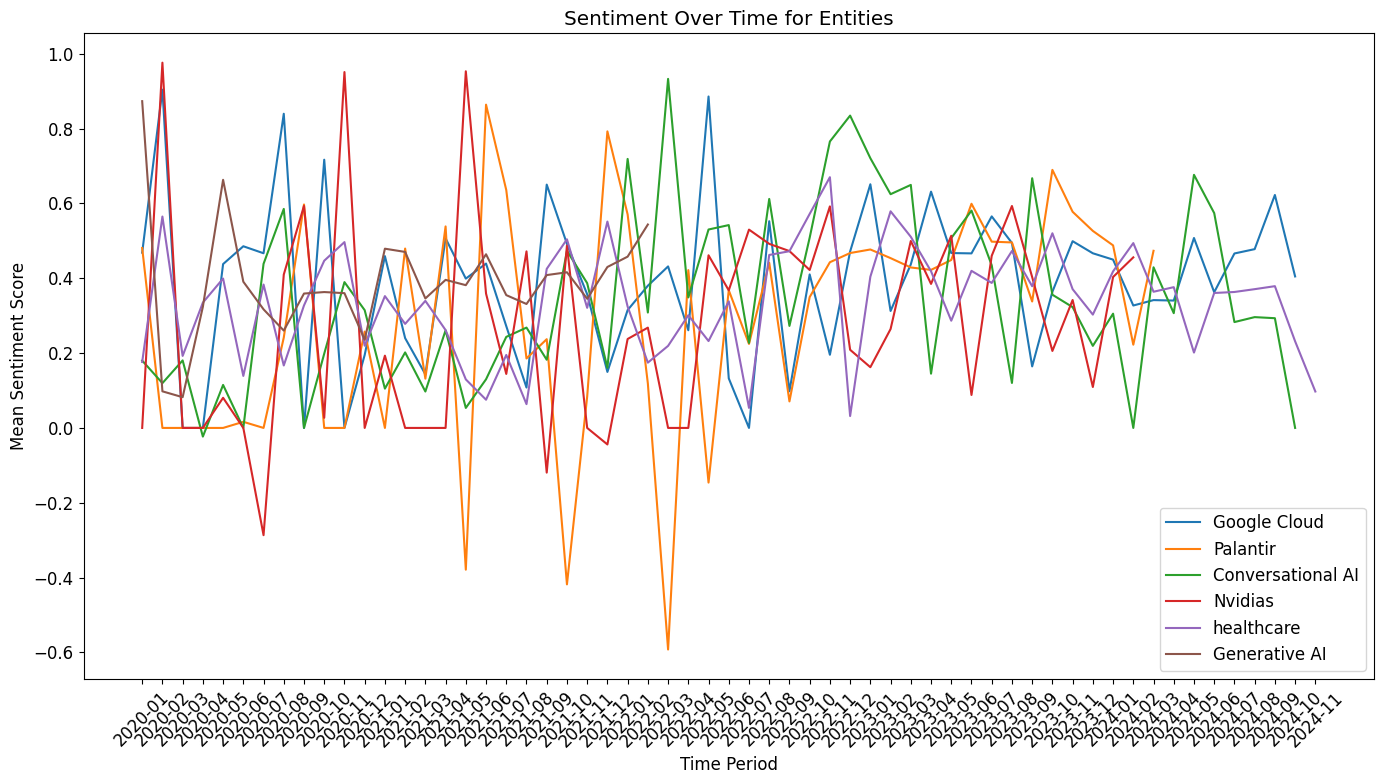

In [ ]:
# Sentiment Score over time for top entities

top_names = ['Google Cloud', 'Palantir', 'Conversational AI', 'Nvidias', 'healthcare', 'Generative AI']

plot_individual_entity_sentiment_over_time(
    df=df_merged,
    period_col='year_month',
    sentiment_col=sentiment_col,
    entities=top_names,
    entity_types = entity_types,
    aggregation=aggregation_method
)

Palantir's sentiment instability reflects its position as a **polarizing company** in the tech and analytics space. Events like **financial disclosures**, **contract announcements**, and **public debates** can lead to sharp fluctuations in sentiment over time. This variability is common for companies operating in controversial and high-impact industries.

In [ ]:
# What happend to Palantir in 2022-02?
df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'Palantir', 'ORG')
df_filtered_entity[df_filtered_entity['year_month'] == '2022-02'][['year_month', 'sentence', 'sentiment_label_certainty']].head(10)

year_month  \
1085625    2022-02   
2214323    2022-02   
2214326    2022-02   
2214327    2022-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                   sentence  \
1085625                                                                                                                                                                                               After extensive experience building data infrastructure and managing data science teams at Two Sigma Palantir and Google co-founders Jakub Jurovych Jan Matas and Filip Stollar set out to build an innovative data science notebook.   
2214323                                                                                                                                                                                                                                             After adjusting for stock-based compensation and other expenses Palantir earned 2 cents a share down from 3 cents a share a year earlier while analysts trac57m agoBarrons.comPalantirs   
2214326  The data analytics software company also issues first-quarter revenue guidance better than Wall Street estimates.37m agoReutersSoftware firm Palantir boosts revenue view on commercial strengthPalantir Technologies forecast current-quarter sales above estimates on Thursday after a steady flow of government contracts and a growing commercial portfolio boosted the data analytics software firm's fourth-quarter revenue.   
2214327                      Known for its work with the U.S. Army the Central Intelligence Agency and other government bodies Palantir's next leg of growth is widely expected to come from commercial contracts with large businesses.1h agoTipRanksJ.P. Morgan Says Buy These 2 Stocks as They Are Oversold2022 has started out with a marked increase in market volatility accompanied by a sharp reversal of last years bullish trend.   

         sentiment_label_certainty  
1085625                   0.000000  
2214323                  -0.959173  
2214326                   0.971964  
2214327                   0.935774

Based on the filtered data for **Palantir** in February 2022 (`2022-02`), here’s a summary of events:

1. **Financial Performance and Stock-Based Compensation**:
   - Palantir reported **lower earnings** compared to the previous year. After adjusting for stock-based compensation and other expenses, the company earned **2 cents per share**, down from **3 cents per share** a year earlier. This likely contributed to some negative sentiment (`-0.959173`).

2. **Positive Revenue Guidance**:
   - Despite the drop in earnings, Palantir issued **better-than-expected revenue guidance** for the first quarter, driven by a growing commercial portfolio and government contracts. This resulted in positive sentiment in certain reports (`0.971964`).

3. **Commercial and Government Contracts**:
   - Palantir’s growth was attributed to its expanding **commercial contracts with large businesses** as well as a steady inflow of **government contracts**, particularly with organizations like the U.S. Army and CIA. This is a sign of diversification and growth opportunities, leading to positive sentiment (`0.935774`).

4. **Innovation and Founders’ Background**:
   - A report mentioned Palantir as part of the **extensive experience** of its co-founders in the data analytics and infrastructure space, alongside companies like **Two Sigma** and **Google**. This aligns with its brand image as a leader in data science and analytics tools.

---

### Overall Analysis
In February 2022:
- **Mixed Sentiment**: Palantir experienced both negative and positive sentiment. The negative sentiment stemmed from the drop in earnings per share, while the positive sentiment was driven by strong revenue guidance and continued growth in commercial and government sectors.
- **Outlook**: Palantir was positioning itself for future growth through **commercial contracts** and innovations, signaling a strategic shift beyond its traditional government focus.

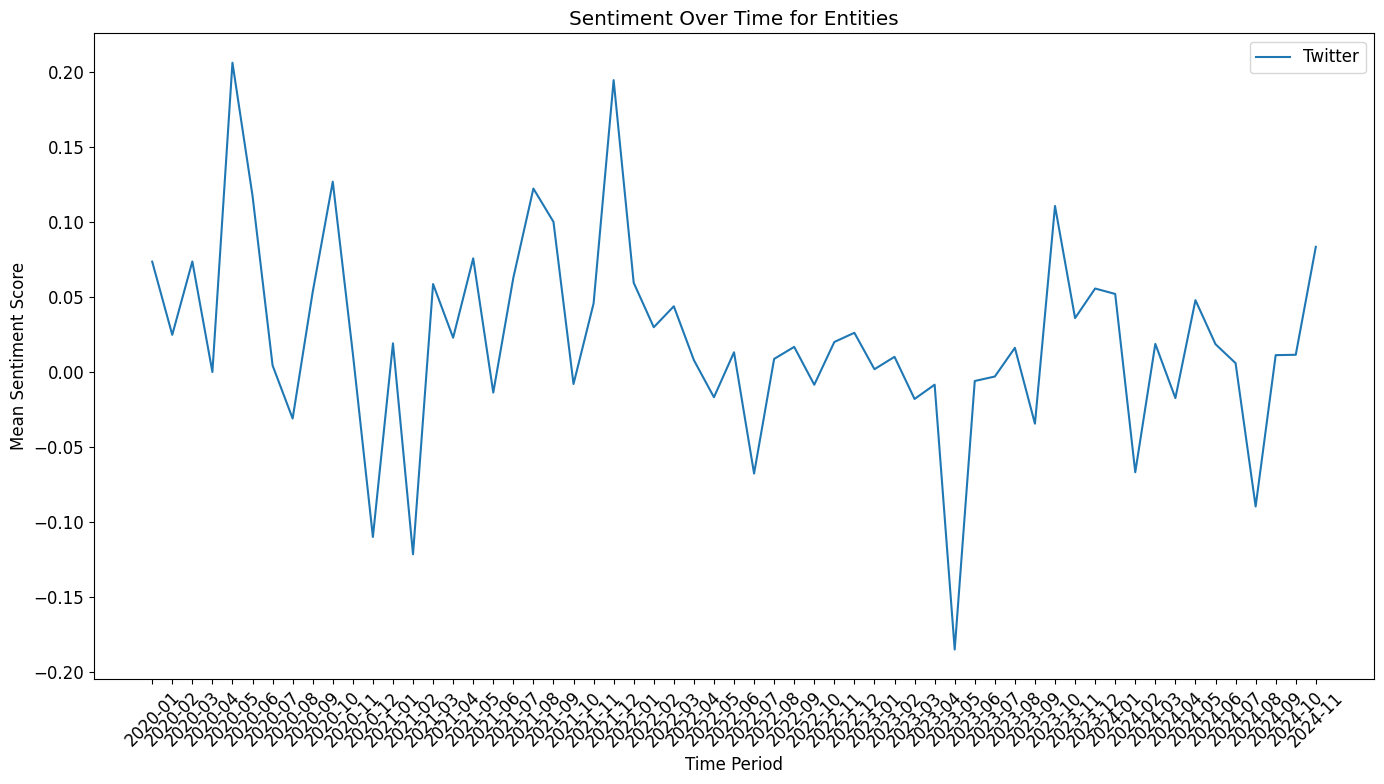

In [ ]:
# Sentiment Score over time for Twitter

top_names = ['Twitter']

plot_individual_entity_sentiment_over_time(
    df=df_merged,
    period_col='year_month',
    sentiment_col=sentiment_col,
    entities=top_names,
    entity_types = entity_types,
    aggregation=aggregation_method
)


### Potential Historical Events in April 2023:

- **Elon Musk’s Twitter Policy Changes:**
  - Introduction of **Twitter Blue subscription service** and removal of legacy blue checkmarks may have caused controversy.
  - Negative sentiment around this decision likely arose from public backlash and user dissatisfaction.

- **Platform Criticism:**
  - Changes to Twitter’s **verification policies**, **free API access restrictions**, and **layoffs** may have triggered discontent.

In [ ]:
# What happend to Twitter in 2023-04?
df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'Twitter', 'ORG')
df_filtered_entity[df_filtered_entity['year_month'] == '2023-04'][['year_month', 'sentence', 'sentiment_label_certainty']].head(10)

year_month  \
6840      2023-04   
16578     2023-04   
21287     2023-04   
21288     2023-04   
67054     2023-04   
81807     2023-04   
107932    2023-04   
107935    2023-04   
107937    2023-04   
117275    2023-04   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   sentence  \
6840                                                                                                                                                                                                                                                                     agoAFPMusk defends paid Twitter as blue tick ultimatum loomsElon Musk on Friday defended his controversial pay model for Twitter claiming that any social media platform that didn't follow suit would fail because they would be swarmed by bots.   
16578                                                                                                                                                                                                                                                                                                                                                                                                                      Did He Keep Any of Them Is There Any Financial Benefit to Paying 8 for Twitter's Blue Check Mark   
21287                                                                                                                                                                                                                                                                                                                                                                                                                                                            Bloomberg Musk joked that his dog is in charge of Twitter.   
21288                                                                                                                                                                                                                                                                                                                                                                                                                                                                        WP Were witnessing the brain death of Twitter.   
67054                                                                                                                                                                                                                                                                                                                                                Tesla and Twitter chief Elon Musk and Apple co-founder Steve Wozniak have warned that human competitive intelligence could pose serious risks to society and humanity.   
81807                                                                                                                                                                                                                            On Thursday a Twitter account by the name of Rihanna Facts shared a snippet of the cover which it claimed was generated by the artificial intelligence chatbot ChatGPT.The clip has been viewed over 850000 times and prompted plenty of reaction including from Nope actress Keke Palmer.   
107932                                                                                                                                                                                                

The **huge drop** in sentiment in **April 2023** can be attributed primarily to:
1. **Public backlash against the paid verification system.**
2. **Concerns about AI risks raised by Elon Musk and Steve Wozniak.**

These events, combined with ongoing controversies about Musk’s leadership and changes to Twitter, amplified the negative sentiment.

### Sentiment by PRODUCT

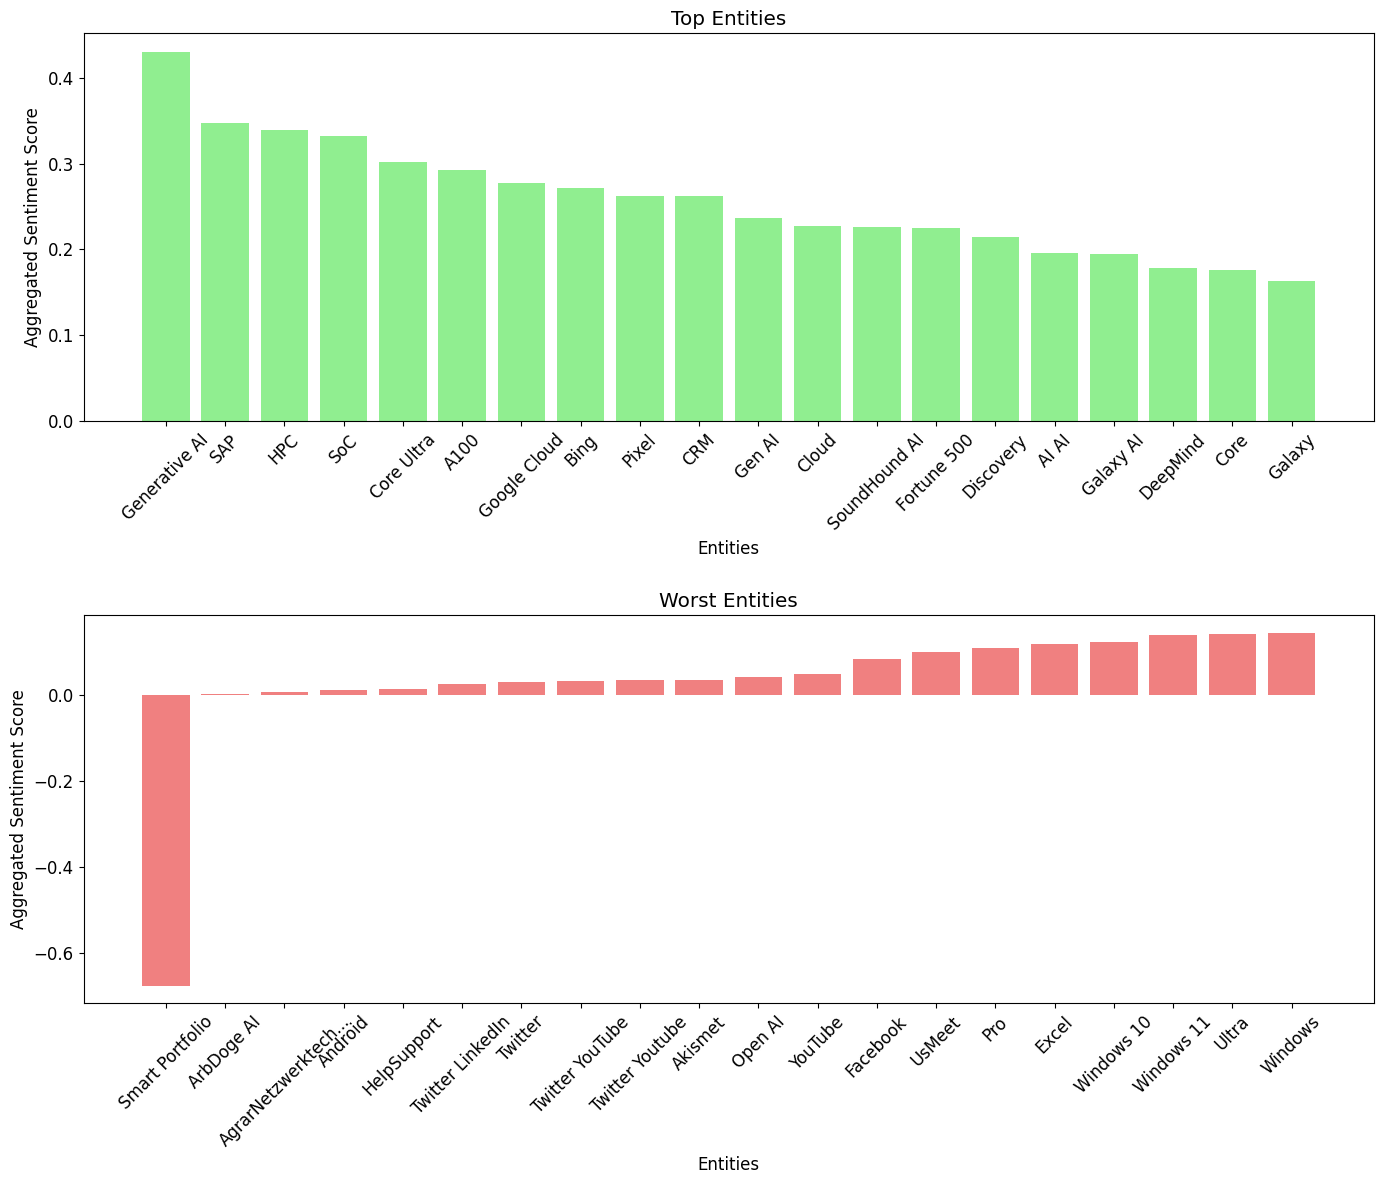

In [ ]:
# Define the DataFrame columns for entities and sentiment scores
entity_col = 'entities'
sentiment_col = 'sentiment_label_certainty'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'mean'
entity_types = ['PRODUCT']
exclude_entities = ['AI', 'Best', 'Buy More SaveMore', 'Share', 'Reddit VKontakte Share', 'Water Air', 'CouponsPurple Squarespace','GT', 'JavaScript']

top_n = 20
min_count = 750


plot_top_worst_entities(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

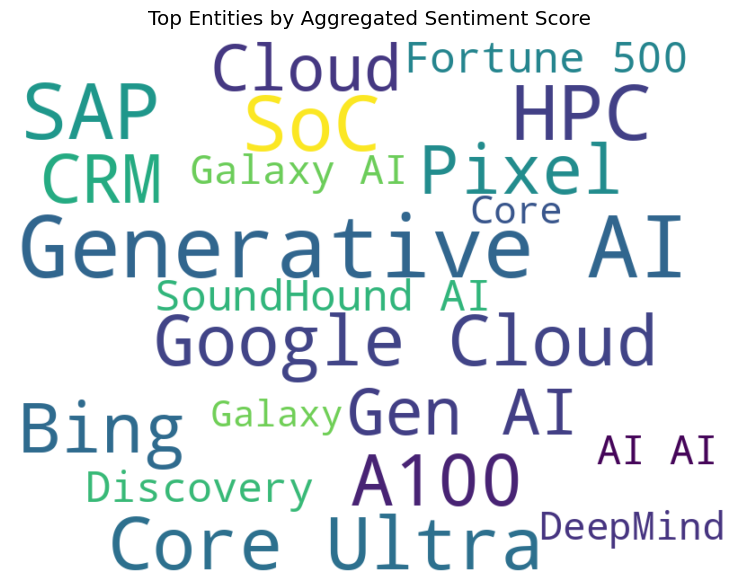

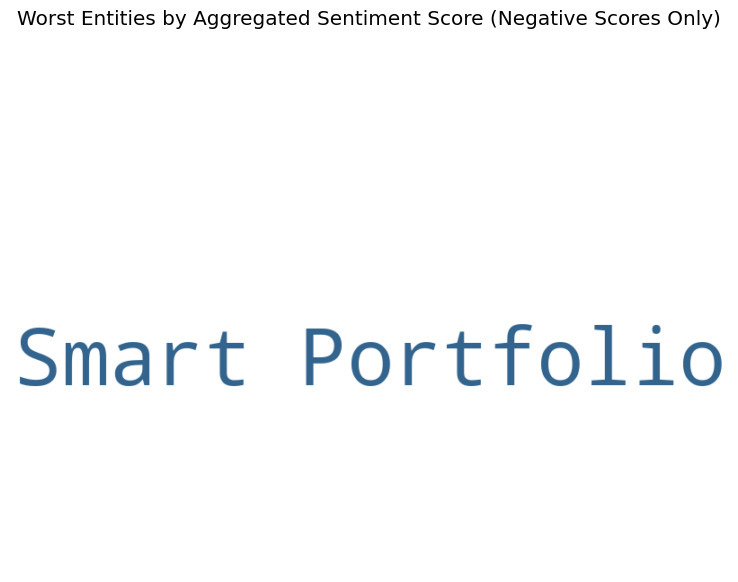

In [ ]:
plot_top_worst_entities_wordcloud(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

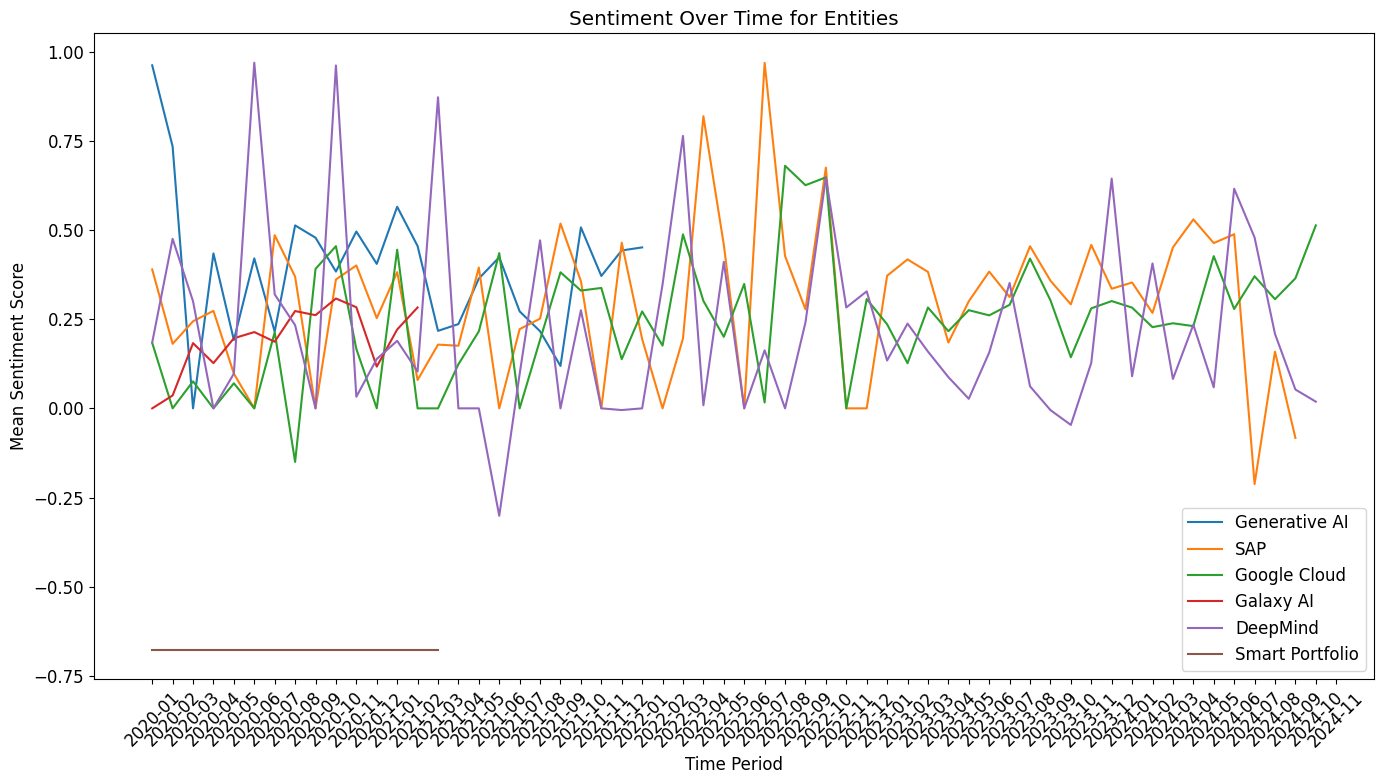

In [ ]:
# Sentiment Score over time for interesting PRODUCTS

top_names = ['Generative AI', 'SAP', 'Google Cloud', 'Galaxy AI', 'DeepMind', 'Smart Portfolio',]

plot_individual_entity_sentiment_over_time(
    df=df_merged,
    period_col='year_month',
    sentiment_col=sentiment_col,
    entities=top_names,
    entity_types=entity_types,
    aggregation=aggregation_method
)

In [ ]:
# What happend to Smart Portfolio in 2021-01?
df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'Smart Portfolio', 'PRODUCT')
# df_filtered_entity[df_filtered_entity['year_month'] == '2019-12'][['year_month', 'sentence', 'sentiment_label_certainty']].head(10)
df_filtered_entity.sort_values(by='year_month')

article_id  sentence_id  \
1780000       41957           75   
1161688       27442           76   
1748955       41221           76   
1812918       42719           52   
4271497      100737           62   
...             ...          ...   
5467869      128818           97   
119217         2759           94   
4405281      103896           65   
5072512      119476           57   
1551795       36586           54   

                                                                                                                                           sentence  \
1780000  Save data Data is currently not available Opt in to Smart Portfolio We are currently experiencing technical difficulties please try again.   
1161688  Save data Data is currently not available Opt in to Smart Portfolio We are currently experiencing technical difficulties please try again.   
1748955  Save data Data is currently not available Opt in to Smart Portfolio We are currently experiencing technical difficulties please try again.   
1812918  Save data Data is currently not available Opt in to Smart Portfolio We are currently experiencing technical difficulties please try again.   
4271497  Save data Data is currently not available Opt in to Smart Portfolio We are currently experiencing technical difficulties please try again.   
...                                                                                                                                             ...   
5467869  Save data Data is currently not available Opt in to Smart Portfolio We are currently experiencing technical difficulties please try again.   
119217   Save data Data is currently not available Opt in to Smart Portfolio We are currently experiencing technical difficulties please try again.   
4405281  Save data Data is currently not available Opt in to Smart Portfolio We are currently experiencing technical difficulties please try again.   
5072512  Save data Data is currently not available Opt in to Smart Portfolio We are currently experiencing technical difficulties please try again.   
1551795  Save data Data is currently not available Opt in to Smart Portfolio We are currently experiencing technical difficulties please try again.   

                                                    entities  \
1780000  [(Save data Data, ORG), (Smart Portfolio, PRODUCT)]   
1161688  [(Save data Data, ORG), (Smart Portfolio, PRODUCT)]   
1748955  [(Save data Data, ORG), (Smart Portfolio, PRODUCT)]   
1812918  [(Save data Data, ORG), (Smart Portfolio, PRODUCT)]   
4271497  [(Save data Data, ORG), (Smart Portfolio, PRODUCT)]   
...                                                      ...   
5467869  [(Save data Data, ORG), (Smart Portfolio, PRODUCT)]   
119217   [(Save data Data, ORG), (Smart Portfolio, PRODUCT)]   
4405281  [(Save data Data, ORG), (Smart Portfolio, PRODUCT)]   
5072512  [(Save data Data, ORG), (Smart Portfolio, PRODUCT)]   
1551795  [(Save data Data, ORG), (Smart Portfolio, PRODUCT)]   

        entities_combined  sentiment_score_DistilBERT  \
1780000                []                    0.675827   
1161688                []                    0.675827   
1748955                []                    0.675827   
1812918                []                    0.675827   
4271497                []                    0.675827   
...                   ...                         ...   
5467869                []                    0.675827   
119217                 []                    0.675827   
4405281                []                    0.675827   
5072512                []                    0.675827   
1551795                []                    0.675827   

        sentiment_label_DistilBERT  sentiment_label_certainty       date  \
1780000                   NEGATIVE                  -0.675827 2023-09-29   
1161688                   NEGATIVE                  -0.675827 2023-09-25   
1748955                   NEGATIVE                  -0.675827 2023-09-25   
18129

### Same sentence appears in lots articles repeatedly and causes strong negative sentiment for Smart Portfolio

### Sentiment by GPE (location)

In [ ]:
# Define the function to standardize the US aliases in the entities column
def standardize_us_aliases(entities_column, aliases):
    def replace_aliases(entity_list):
        new_list = []
        for entity in entity_list:
            name, typ = entity
            if typ == 'GPE' and name in aliases:
                name = 'US'
            new_list.append((name, typ))
        return new_list

    # Replace the string representation of lists with actual lists using ast.literal_eval
    entities_column = entities_column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Apply the replace_aliases function to each entities list
    return entities_column.apply(replace_aliases)

# Define the list of aliases
us_aliases = ['U.S.', 'the United States', 'USA', 'America']

# Assume df_merged is your DataFrame and 'entities' is the column with the entity data
# Apply the function to the 'entities' column
df_merged['entities_US'] = standardize_us_aliases(df_merged['entities'], us_aliases)

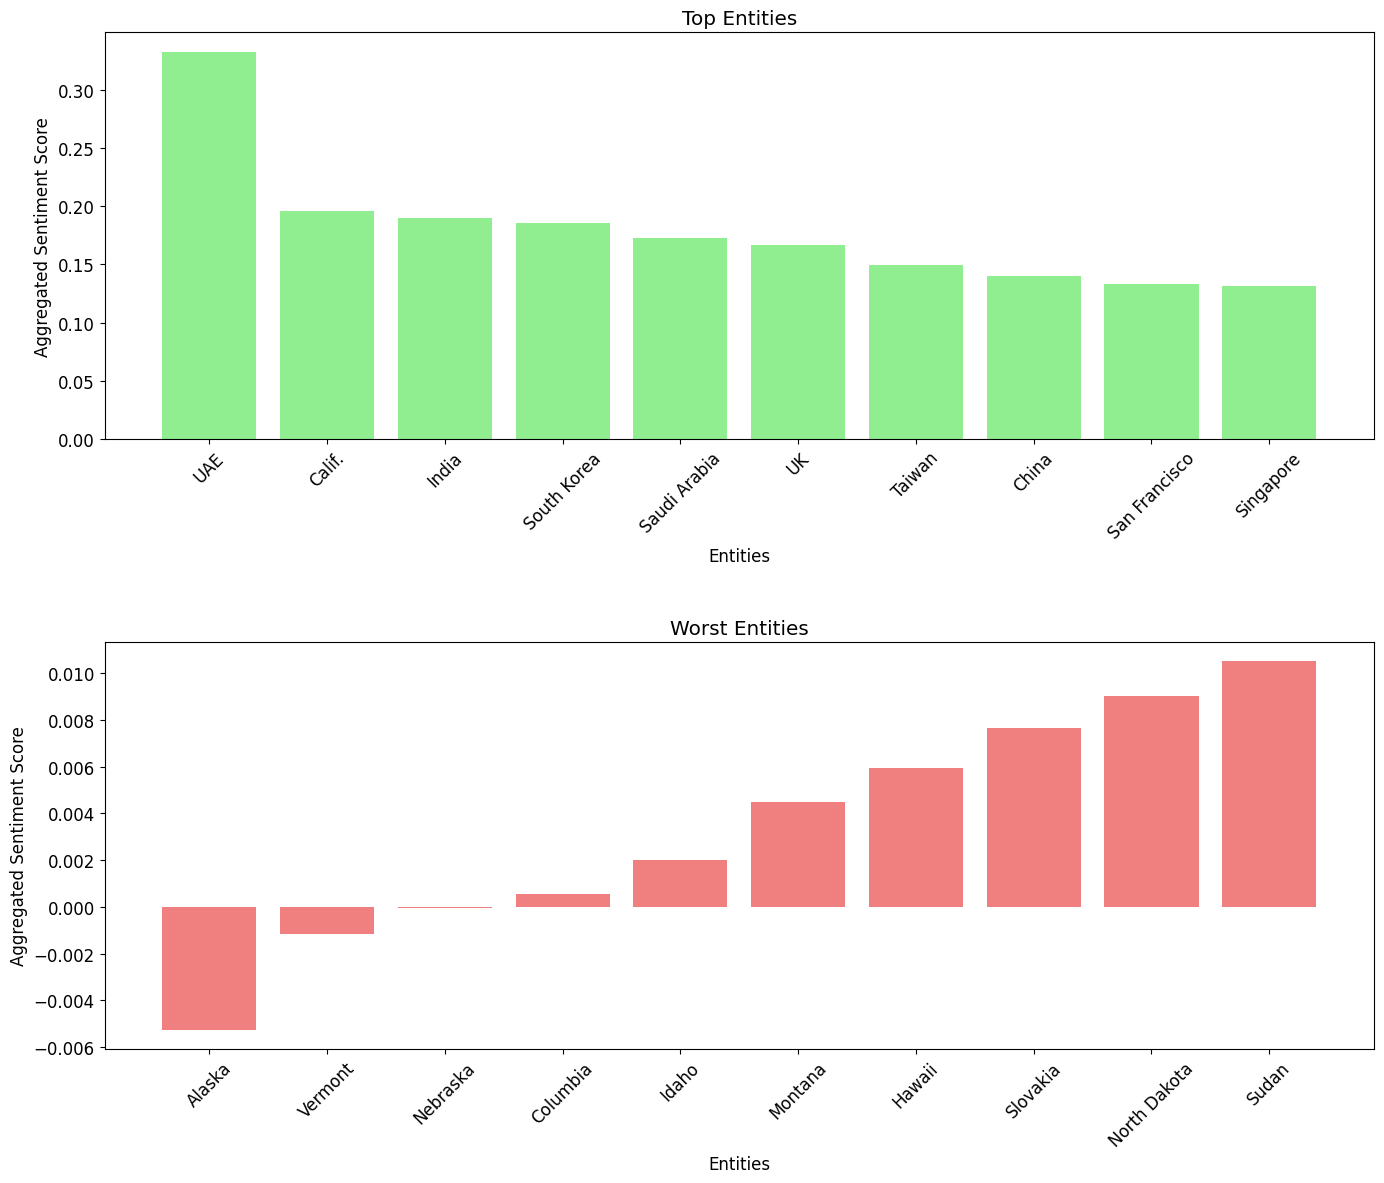

In [ ]:
# Define the DataFrame columns for entities and sentiment scores
entity_col = 'entities_US'
sentiment_col = 'sentiment_label_certainty'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'mean'
entity_types = ['GPE']
exclude_entities = ['PRNewswire']

top_n = 10
min_count = 5000


plot_top_worst_entities(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

In [ ]:
df_merged.head(2)

article_id  sentence_id  \
0           1            1   
1           1            2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   

                                                                           entities  \
0                             [(July 4 2021, DATE), (AI, PRODUCT), (Universe, ORG)]   
1  [(CREDIT The Institute of Statistical Mathematics Japanese, ORG), (AI, PRODUCT)]   

  entities_combined  sentiment_score_DistilBERT sentiment_label_DistilBERT  \
0                []                    0.989424                    NEUTRAL   
1                []                    0.541715                   POSITIVE   

   sentiment_label_certainty       date       topic year_month  \
0                   0.000000 2021-07-05  AIResearch    2021-07   
1                   0.541715 2021-07-05  AIResearch    2021-07   

                                                                        entities_US  
0                             [(July 4 2021, DATE), (AI, PRODUCT), (Universe, ORG)]  
1  [(CREDIT The Institute of Statistical Mathematics Japanese, ORG), (AI, PRODUCT)]

In [ ]:
def plot_individual_entity_sentiment_over_time(df, period_col, sentiment_col, entities, entity_types=None, aggregation='mean', entity_col='entities'):
    """
    Plots sentiment scores over time for each specified entity individually, aggregating scores according to the specified method.

    Args:
        df (pd.DataFrame): DataFrame containing the sentiment data.
        period_col (str): Column name for the time period.
        sentiment_col (str): Column name for the sentiment scores.
        entities (list): List of entities to plot.
        entity_types (list, optional): List of entity types to filter by (e.g., ['ORG', 'GPE']). If None, all types are considered.
        aggregation (str): Method for aggregating sentiment scores ('mean', 'sum', 'count').
        entity_col (str): Column name containing the entities to filter (default is 'entities').
    """
    plt.figure(figsize=(14, 8))

    for entity in entities:
        # Filter dataframe for rows containing the specified entity and entity types
        def filter_entity(row):
            entity_list = row[entity_col]
            return any(e[0] == entity and (entity_types is None or e[1] in entity_types) for e in entity_list)

        filtered_df = df[df.apply(filter_entity, axis=1)]

        # Aggregate sentiment scores
        if aggregation == 'mean':
            agg_scores = filtered_df.groupby(period_col)[sentiment_col].mean()
        elif aggregation == 'sum':
            agg_scores = filtered_df.groupby(period_col)[sentiment_col].sum()
        elif aggregation == 'count':
            agg_scores = filtered_df.groupby(period_col)[sentiment_col].count()
        else:
            raise ValueError("Aggregation method must be 'mean', 'sum', or 'count'.")

        # Plotting
        agg_scores.plot(kind='line', label=entity)

    # Adjust x-axis to show each month
    plt.xticks(range(len(agg_scores.index)), agg_scores.index, rotation=45)

    plt.title(f"Sentiment Over Time for Entities")
    plt.ylabel(f"{aggregation.capitalize()} Sentiment Score")
    plt.xlabel("Time Period")
    plt.legend()
    # plt.grid(True)  # This line was removed to eliminate grid lines
    plt.tight_layout()
    plt.show()


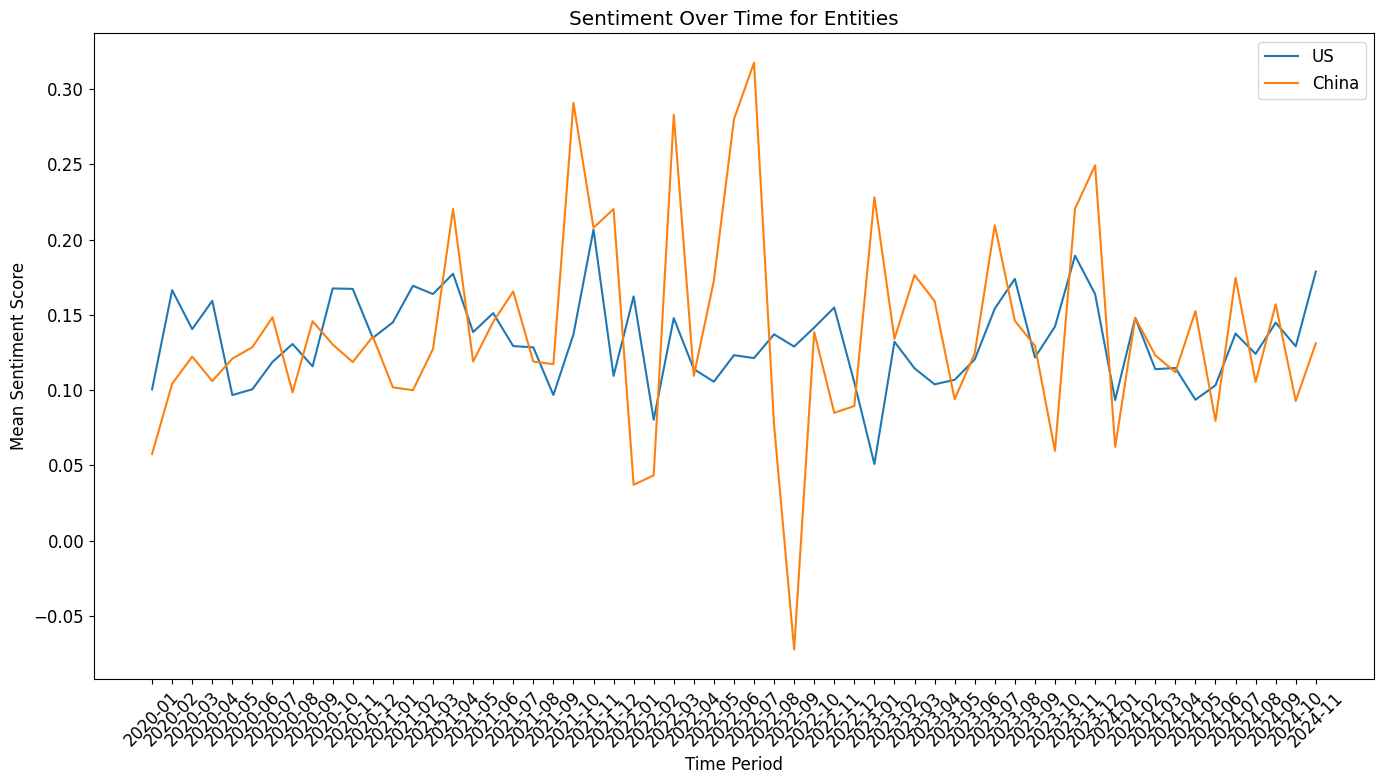

In [ ]:
# Sentiment Score over time for interesting PRODUCTS
top_names = ['US', 'China']

plot_individual_entity_sentiment_over_time(
    df=df_merged,
    period_col='year_month',
    sentiment_col='sentiment_label_certainty',
    entities=top_names,
    entity_types=['GPE'],  # Example: filtering for geopolitical entities
    aggregation='mean',
    entity_col='entities_US'  # Specify the column to look for entities
)


UAE, India and California score high in positive sentiment while Alaska scores low.

The greater fluctuation in sentiment toward China compared to the US can be summarized as follows:

1. **Diverse and Polarizing Topics**: Sentiment toward China is influenced by varied and polarizing issues like trade, geopolitics, and human rights, which evoke strong reactions.
2. **Event-Driven Volatility**: Specific geopolitical events (e.g., trade disputes, sanctions) often trigger sharp sentiment shifts for China, while the US narrative tends to be steadier.
3. **Media Bias**: Western media's polarized reporting on China amplifies sentiment swings, whereas the US receives more predictable coverage.
4. **Mention Volume**: A potentially smaller volume of mentions for China may amplify sentiment variability compared to the US, which is mentioned more frequently.
5. **Polarizing Issues**: Topics like COVID-19 origins and regional conflicts drive significant sentiment changes for China, unlike the more consistent themes associated with the US.

### Sentiment by PERSON

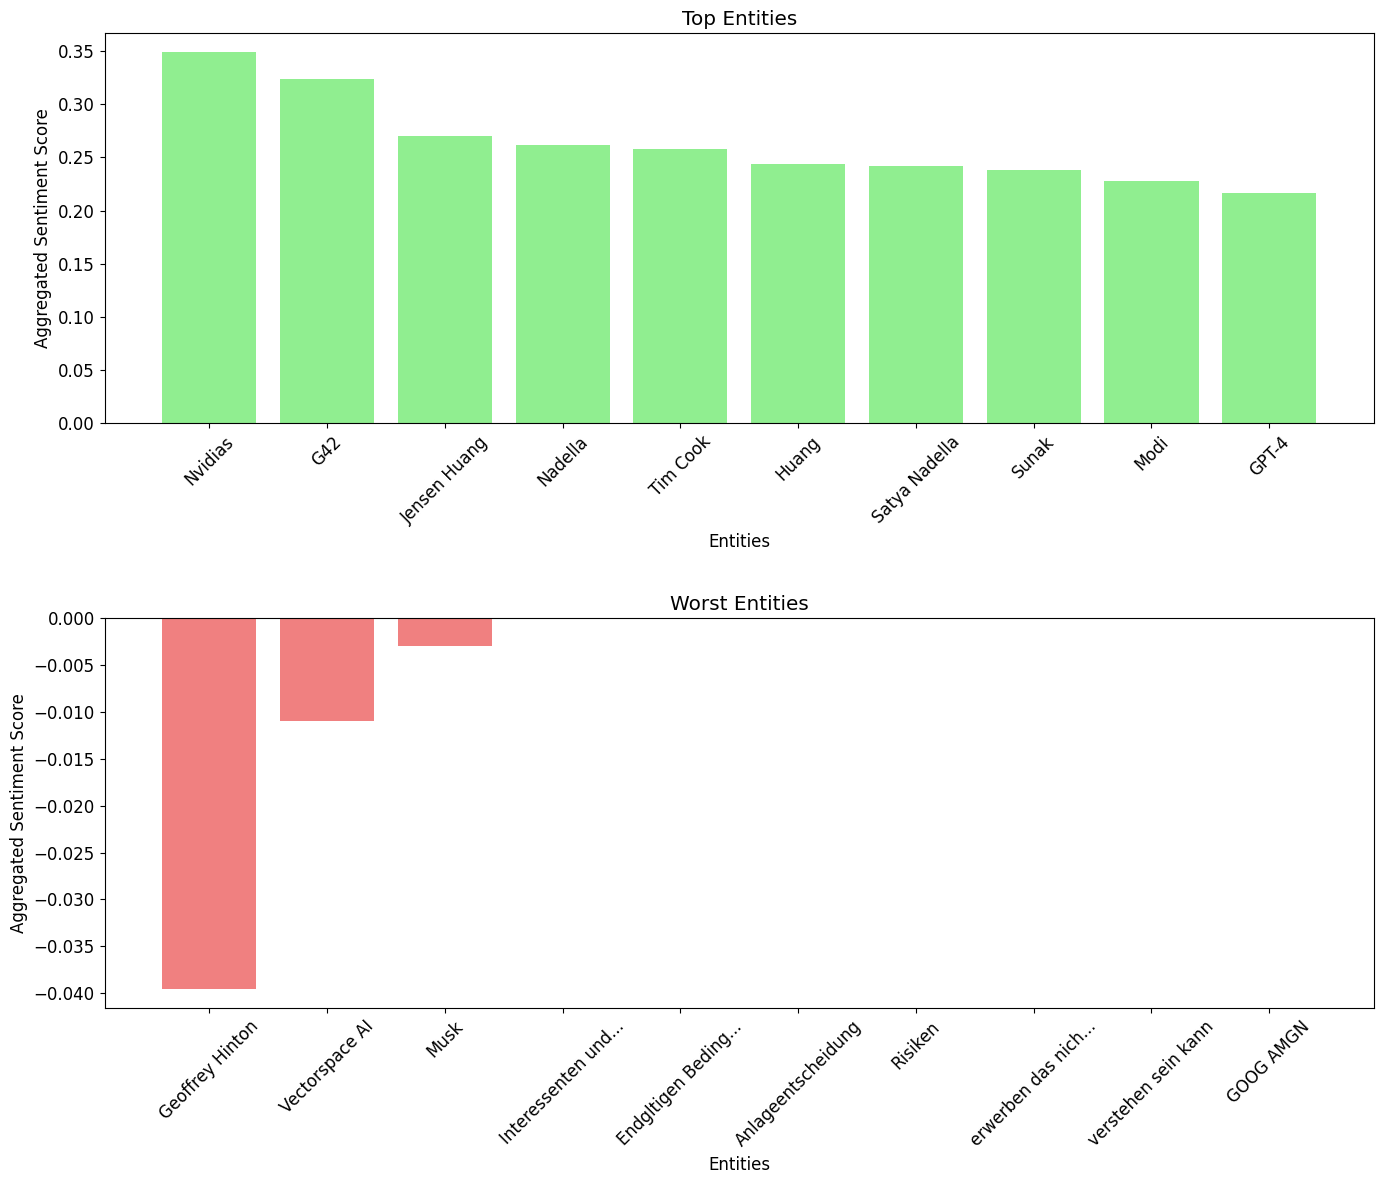

In [ ]:
# Define the DataFrame columns for entities and sentiment scores
entity_col = 'entities'
sentiment_col = 'sentiment_label_certainty'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'mean'
entity_types = ['PERSON']
exclude_entities = ['AdvertisingAt Gray', 'CaptioningAudio DescriptionAt', 'CaptioningAudio', 'Multicloud', 'Bing']

top_n = 10
min_count = 1000

plot_top_worst_entities(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

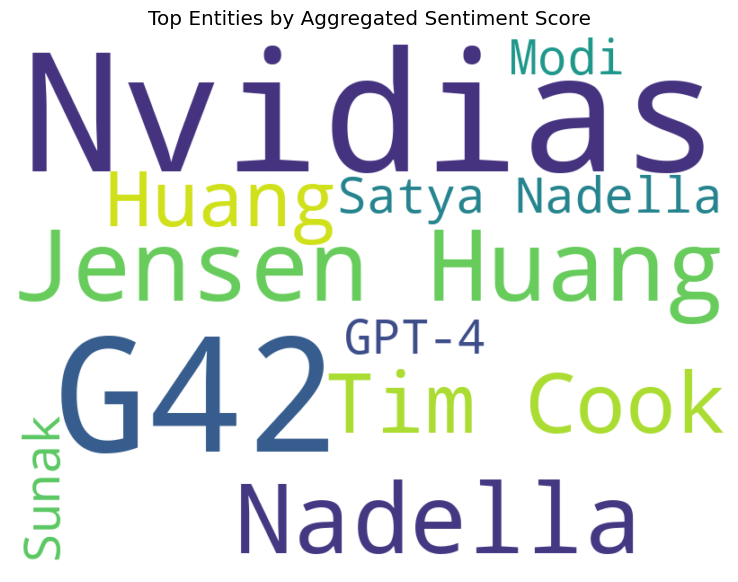

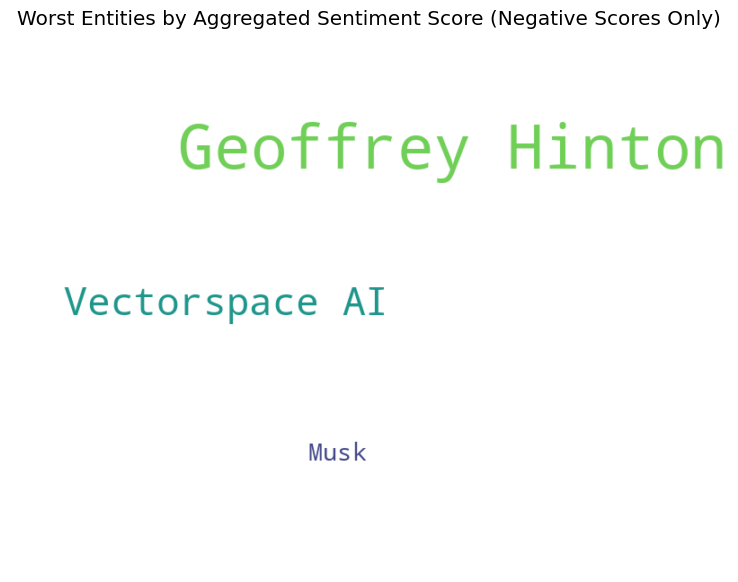

In [ ]:
plot_top_worst_entities_wordcloud(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

The low sentiment scores for **Geoffrey Hinton** and **Elon Musk** stem from their association with controversial or polarizing topics: Hinton’s warnings about AI risks and Musk’s actions at Twitter/X often invite criticism. Conversely, **Jensen Huang** and **Tim Cook** score high due to their association with innovation and stability. Huang is praised for NVIDIA’s leadership in AI, while Cook’s steady and inclusive management style reinforces Apple’s positive image. The difference reflects public perception shaped by their actions, industries, and media portrayal.

In [ ]:
df_merged.head(2)

article_id  sentence_id  \
0           1            1   
1           1            2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   

                                                                           entities  \
0                             [(July 4 2021, DATE), (AI, PRODUCT), (Universe, ORG)]   
1  [(CREDIT The Institute of Statistical Mathematics Japanese, ORG), (AI, PRODUCT)]   

  entities_combined  sentiment_score_DistilBERT sentiment_label_DistilBERT  \
0                []                    0.989424                    NEUTRAL   
1                []                    0.541715                   POSITIVE   

   sentiment_label_certainty       date       topic year_month  \
0                   0.000000 2021-07-05  AIResearch    2021-07   
1                   0.541715 2021-07-05  AIResearch    2021-07   

                                                                        entities_US  
0                             [(July 4 2021, DATE), (AI, PRODUCT), (Universe, ORG)]  
1  [(CREDIT The Institute of Statistical Mathematics Japanese, ORG), (AI, PRODUCT)]

### Now focus on entities_combined column

In [ ]:
# Adjust data to use funtions
entity_col = 'entities_combined'
df_merged_combined = df_merged.copy()
df_merged_combined['entities'] = df_merged_combined['entities_combined']

### Overview

In [ ]:
df_merged_combined.head(5)

article_id  sentence_id  \
0           1            1   
1           1            2   
2           1            3   
3           1            4   
4           1            5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   
2                                                                                                                                                                                                      After extensive training and testing on large mock data created by supercomputer simulations they then applied this new tool to actual data from Japan's Subaru Telescope and found that the mass distribution derived from using this method is consistent with the currently accepted models of the Universe.   
3                                                                                                                                                                                                                                                                                                                                                                                                                       This is a powerful new tool for analyzing big data from current and planned astronomy surveys.   
4                                                                                                                                                                                                                                                                                                                                                                         Wide area survey data can be used to study the large-scale structure of the Universe through measurements of gravitational lensing patterns.   

                 entities       entities_combined  sentiment_score_DistilBERT  \
0                      []                      []                    0.989424   
1                      []                      []                    0.541715   
2                      []                      []                    0.933930   
3  [['Big Data', 'TECH']]  [['Big Data', 'TECH']]                    0.789955   
4                      []                      []                    0.990115   

  sentiment_label_DistilBERT  sentiment_label_certainty       date  \
0                    NEUTRAL                   0.000000 2021-07-05   
1                   POSITIVE                   0.541715 2021-07-05   
2                    NEUTRAL                   0.000000 2021-07-05   
3                 

In [ ]:
import ast

def safe_literal_eval(val):
    """
    Safely evaluates a value using ast.literal_eval.
    Returns the original value if it cannot be evaluated.
    """
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None  # Replace invalid rows with None

# Apply safe parsing to the 'entities' column
df_merged_combined['entities_combined'] = df_merged_combined['entities_combined'].apply(
    lambda x: safe_literal_eval(str(x)) if isinstance(x, str) else x
)

In [ ]:
df_merged_combined.head(5)

article_id  sentence_id  \
0           1            1   
1           1            2   
2           1            3   
3           1            4   
4           1            5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   
2                                                                                                                                                                                                      After extensive training and testing on large mock data created by supercomputer simulations they then applied this new tool to actual data from Japan's Subaru Telescope and found that the mass distribution derived from using this method is consistent with the currently accepted models of the Universe.   
3                                                                                                                                                                                                                                                                                                                                                                                                                       This is a powerful new tool for analyzing big data from current and planned astronomy surveys.   
4                                                                                                                                                                                                                                                                                                                                                                         Wide area survey data can be used to study the large-scale structure of the Universe through measurements of gravitational lensing patterns.   

                 entities   entities_combined  sentiment_score_DistilBERT  \
0                      []                  []                    0.989424   
1                      []                  []                    0.541715   
2                      []                  []                    0.933930   
3  [['Big Data', 'TECH']]  [[Big Data, TECH]]                    0.789955   
4                      []                  []                    0.990115   

  sentiment_label_DistilBERT  sentiment_label_certainty       date  \
0                    NEUTRAL                   0.000000 2021-07-05   
1                   POSITIVE                   0.541715 2021-07-05   
2                    NEUTRAL                   0.000000 2021-07-05   
3                    NEUTRAL              

In [ ]:
df_merged_combined.shape

(6523802, 12)

In [ ]:
df_merged_combined['entities'] = df_merged_combined['entities_combined']

In [ ]:
df_merged_combined.head(5)

article_id  sentence_id  \
0           1            1   
1           1            2   
2           1            3   
3           1            4   
4           1            5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   
2                                                                                                                                                                                                      After extensive training and testing on large mock data created by supercomputer simulations they then applied this new tool to actual data from Japan's Subaru Telescope and found that the mass distribution derived from using this method is consistent with the currently accepted models of the Universe.   
3                                                                                                                                                                                                                                                                                                                                                                                                                       This is a powerful new tool for analyzing big data from current and planned astronomy surveys.   
4                                                                                                                                                                                                                                                                                                                                                                         Wide area survey data can be used to study the large-scale structure of the Universe through measurements of gravitational lensing patterns.   

             entities   entities_combined  sentiment_score_DistilBERT  \
0                  []                  []                    0.989424   
1                  []                  []                    0.541715   
2                  []                  []                    0.933930   
3  [[Big Data, TECH]]  [[Big Data, TECH]]                    0.789955   
4                  []                  []                    0.990115   

  sentiment_label_DistilBERT  sentiment_label_certainty       date  \
0                    NEUTRAL                   0.000000 2021-07-05   
1                   POSITIVE                   0.541715 2021-07-05   
2                    NEUTRAL                   0.000000 2021-07-05   
3                    NEUTRAL                   0.000000 2021-07-05

In [ ]:
# JOB_IND_TECH entities

# Count entities by type
entity_types = ['IND', 'JOB', 'TECH']
top_n = 80

top_entities_df = count_top_entities(df_merged_combined['entities'], entity_types, top_n)
top_entities_df

IND                                   JOB  \
0                 Software (128671)                       Analyst (19776)   
1                Financial (100165)                        Editor (17298)   
2                    Sports (87475)                     Professor (15782)   
3             Entertainment (78697)                     Scientist (10016)   
4                Healthcare (71748)                         Writer (9737)   
5                 Education (70685)                         Artist (8752)   
6                    Energy (70631)                       Engineer (7149)   
7                Government (63607)                        Athlete (6204)   
8                    School (53135)                        Teacher (4984)   
9                  Consumer (49468)                       Designer (3556)   
10                Insurance (47628)                 Data Scientist (2222)   
11             Social Media (47262)                      Architect (1596)   
12               University (45087)                           Chef (1387)   
13                     Game (45017)              Software Engineer (1159)   
14                    Legal (44334)                Product Manager (1125)   
15                  Finance (42560)                        Educator (916)   
16                      Law (42332)                    AI Developer (797)   
17            Manufacturing (41162)              Research Scientist (641)   
18                      Art (40716)                        Lecturer (634)   
19                   Retail (38725)                       Physicist (530)   
20                 Hardware (34464)              Software Developer (518)   
21                   Gaming (34224)                    Data Analyst (384)   
22              Engineering (32622)       Machine Learning Engineer (369)   
23               Automotive (29659)                       Caregiver (351)   
24              Real Estate (27369)               Financial Analyst (297)   
25            Cybersecurity (26310)                       Carpenter (271)   
26                  Defense (25800)                 Project Manager (260)   
27                     Bank (24035)               Financial Adviser (251)   
28               Industrial (23155)              Research Associate (200)   
29           Transportation (22220)                      Copywriter (191)   
30               Publishing (22054)                   Data Engineer (171)   
31               Blockchain (21954)              Operations Manager (154)   
32                 Material (21054)                    Veterinarian (144)   
33                 Robotics (20232)      Cybersecurity Professional (129)   
34                  Fashion (18636)                       Librarian (128)   
35             Construction (17539)                         Artisan (127)   
36              Agriculture (16815)          Financial Professional (116)   
37               Consulting (14610)                   Web Developer (108)   
38                   Mining (12739)                  Media Producer (104)   
39              Health Care (12617)          Healthcare Professional (99)   
40                Aerospace (12442)                     Art Director (94)   
41            Semiconductor (11874)                Account Executive (77)   
42                Logistics (11666)                     Nutritionist (76)   
43                  Fintech (10374)                 Graphic Designer (68)   
44               Journalism (10348)                  IT Professional (64)   
45                E-commerce (9362)  Customer Service Representative (61)   
46                 Utilities (9034)         Cybersecurity Specialist (60)   
47                  Chemical (8840)            Business Professional (40)   
48                   Tourism (8684)                        Geologist (39)   
49           Cloud Computing (8586)                 Business Manager (37)   
50                  Textiles (6770)                  Service Manager (36)   
51                Restaurant

### Sentiment by IND


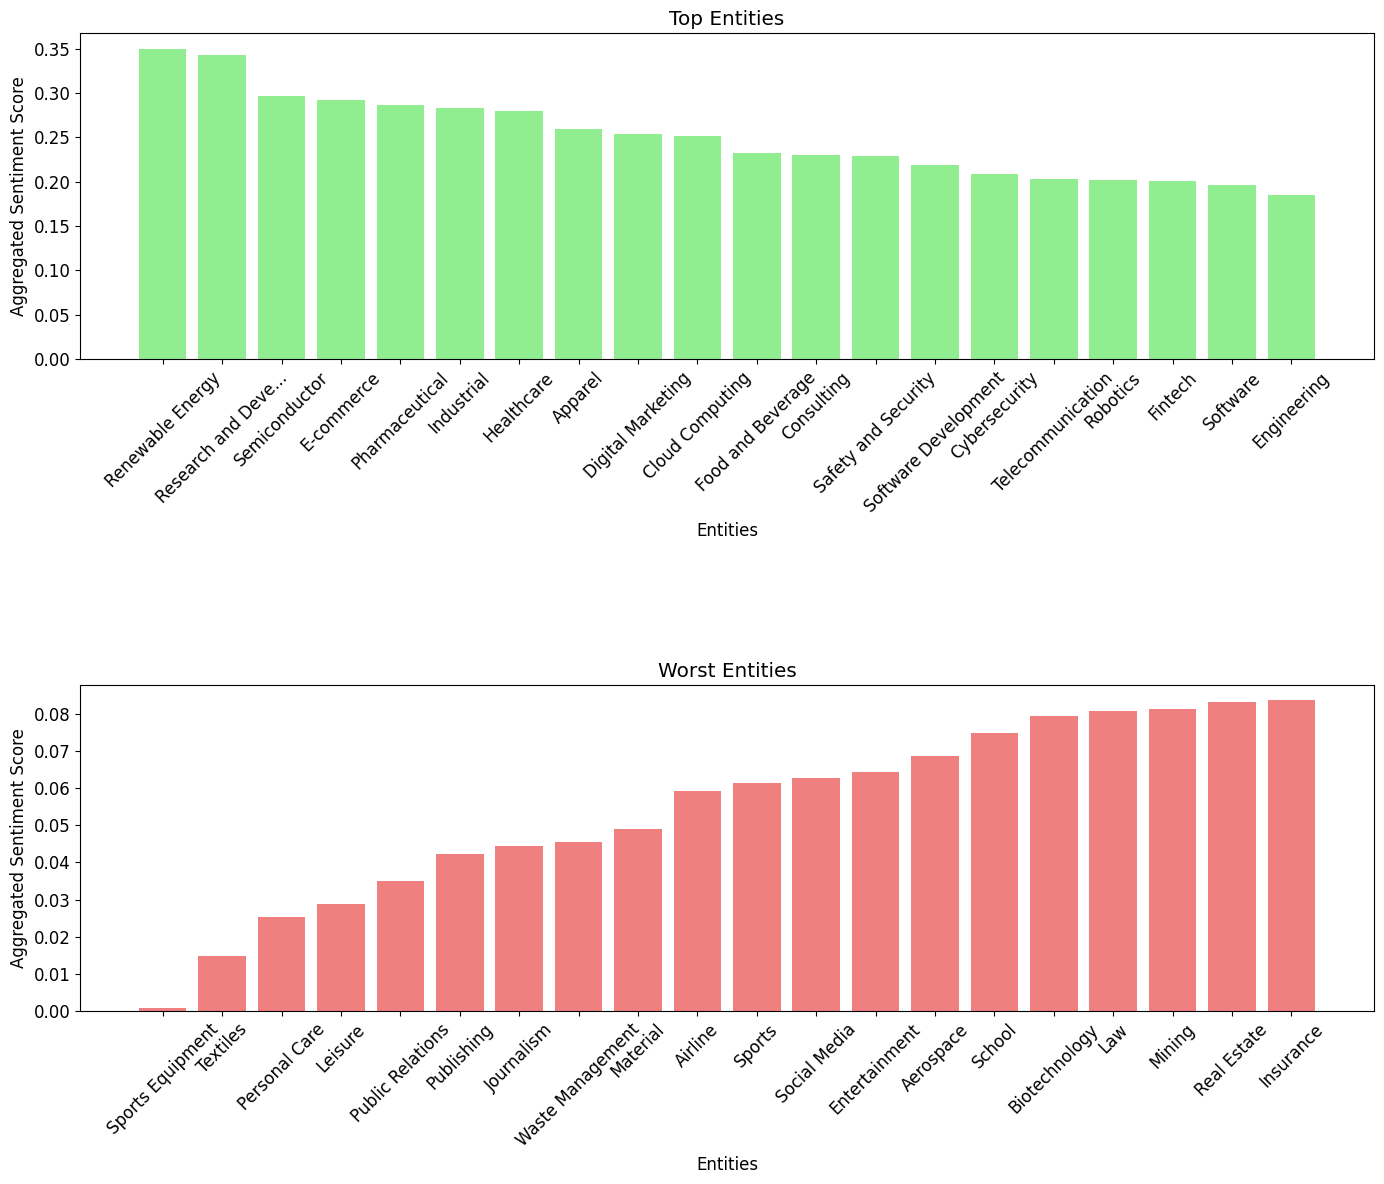

In [ ]:
entity_col = 'entities'
sentiment_col = 'sentiment_label_certainty'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'mean'
entity_types = ['IND']
exclude_entities = []

top_n = 20
min_count = 800


plot_top_worst_entities(
    df=df_merged_combined,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

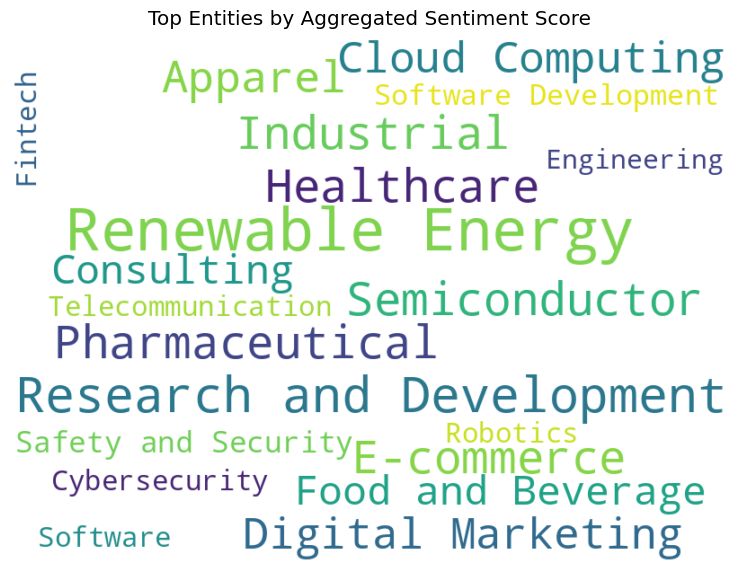

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [ ]:
# plot_top_worst_entities_wordcloud(
#     df=df_merged_combined,
#     entity_col=entity_col,
#     sentiment_col=sentiment_col,
#     aggregation=aggregation_method,
#     entity_types=entity_types,
#     exclude_entities=exclude_entities,
#     top_n=top_n,
#     min_count=min_count
# )

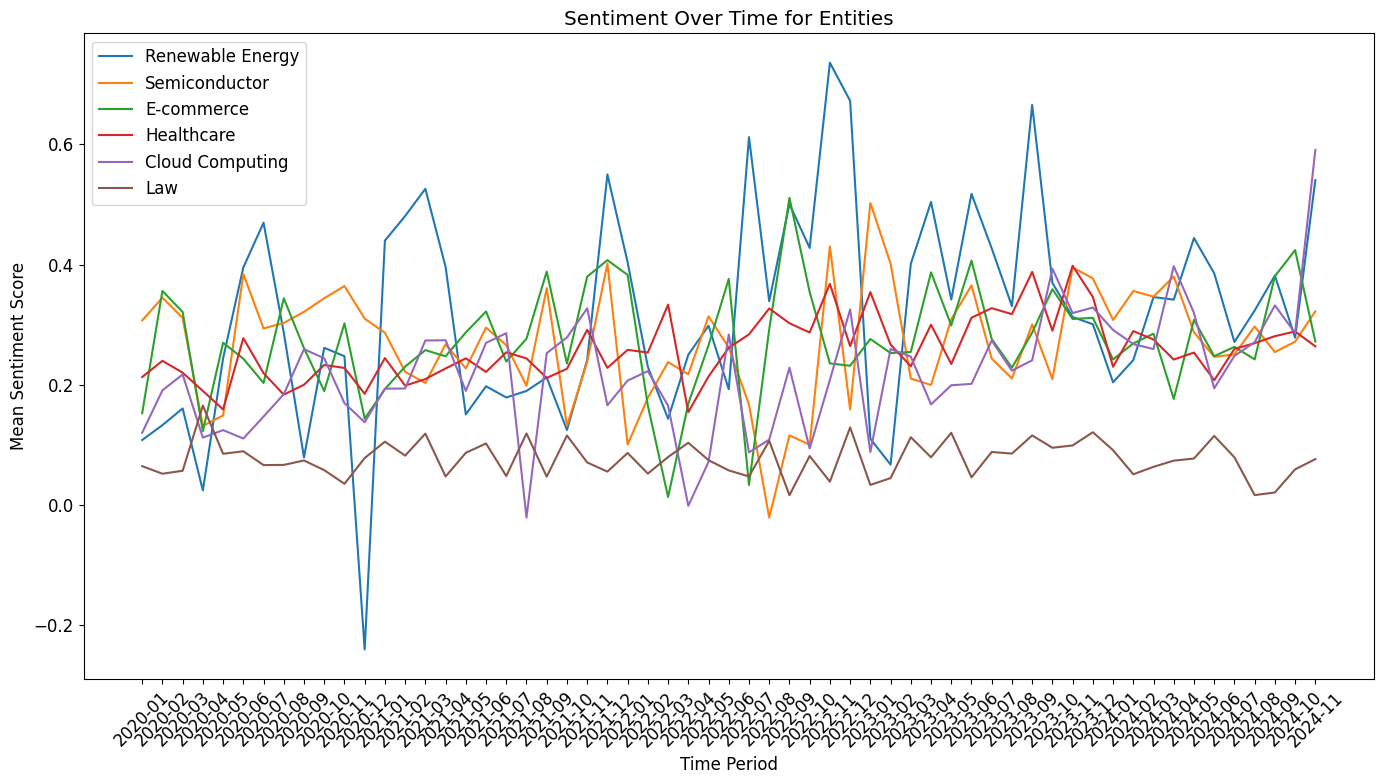

In [ ]:
# Sentiment Score over time for interesting IND

top_names = ['Renewable Energy', 'Semiconductor', 'E-commerce', 'Healthcare', 'Cloud Computing', 'Law',]

plot_individual_entity_sentiment_over_time(
    df=df_merged_combined,
    period_col='year_month',
    sentiment_col=sentiment_col,
    entities=top_names,
    entity_types=entity_types,
    aggregation=aggregation_method
)

In [ ]:
# What happend to Renewable Energy in 2020-12?
df_filtered_entity = filter_df_by_entity_and_type(df_merged_combined, 'Renewable Energy', 'IND')
df_filtered_entity[df_filtered_entity['year_month'] == '2020-12'][['year_month', 'sentence', 'entities', 'sentiment_label_certainty']]

year_month  \
216741     2020-12   
219330     2020-12   
372824     2020-12   
520050     2020-12   
586755     2020-12   
586798     2020-12   
706009     2020-12   
1977341    2020-12   
1977356    2020-12   
2070527    2020-12   
2222958    2020-12   
2265674    2020-12   
2449946    2020-12   
2449947    2020-12   
2452703    2020-12   
2484691    2020-12   
2586644    2020-12   
3905722    2020-12   
4411315    2020-12   
4775407    2020-12   
5031673    2020-12   
5031674    2020-12   
5134053    2020-12   
5134061    2020-12   
5134062    2020-12   
6336657    2020-12   
6471690    2020-12   
6471697    2020-12   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sentence  \
216741                                                                                                                                                                                                                                                                                                                                                        Unless we switch to 100 renewable energy sources AI progress may stand at odds with the goals of cutting greenhouse emissions and slowing down climate change.   
219330   FauciManchester United F.C.Best BuyAlex PadillaNetflix Spotlight LiveTV Movie Reviews Livenews Miguel CardonaLatinoTrump PardonsAntarcticaDwayne HaskinsNetsWarriorsBryan HarsinWomenNew Covid StrainTim CookVeto WORTH WATCHING Joe and Jill Biden Publicly Received COVID-19 Vaccine on Monday 21st December Fauci and Azar receive Moderna vaccine Shia LaBeouf dropped from Netflix awards campaign amid abuse allegations Environmentally friendly One News Page is hosted on servers powered solely by ren...   
372824                                                                                                                                                                                                                                                                                                                                                        Unless we switch to 100 renewable energy sources AI progress may stand at odds with the goals of cutting greenhouse emissions and slowing down climate change.   
520050                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Power CleanTechnica 3Month Renewable Energy 101   
586755   Many people are completely unaware of this This African rat gnaws on a poisonous tree to make itself toxic to predators Its not just birds wasps also threaten airplane safety in Australia The Clean Air Act in the US saved 1.5 billion bird lives over the past 4 decades Climate Animals Renewable Energy Eco tips Environmental Issues Green Living Health All Alternative MedicineAnatomyDiseasesGeneticsMind BrainNutrition What is fentanyl the deadliest drug in America Green Mediterranean diet may b...   
586798                                     No Result View All Result Coronavirus News Environment Climate Animals Renewable Energy Eco tips Environmental Issues Green Living Health Alternative Medicine Anatomy Diseases Genetics Mind Brain Nutrition Future Space Feature Feature Post Art Great Pics

Above shows potential AI's negative impact on cutting greenhouse emissions and slowing down climate change.

In [ ]:
df_merged_combined.head(5)

article_id  sentence_id  \
0           1            1   
1           1            2   
2           1            3   
3           1            4   
4           1            5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   
2                                                                                                                                                                                                      After extensive training and testing on large mock data created by supercomputer simulations they then applied this new tool to actual data from Japan's Subaru Telescope and found that the mass distribution derived from using this method is consistent with the currently accepted models of the Universe.   
3                                                                                                                                                                                                                                                                                                                                                                                                                       This is a powerful new tool for analyzing big data from current and planned astronomy surveys.   
4                                                                                                                                                                                                                                                                                                                                                                         Wide area survey data can be used to study the large-scale structure of the Universe through measurements of gravitational lensing patterns.   

             entities   entities_combined  sentiment_score_DistilBERT  \
0                  []                  []                    0.989424   
1                  []                  []                    0.541715   
2                  []                  []                    0.933930   
3  [[Big Data, TECH]]  [[Big Data, TECH]]                    0.789955   
4                  []                  []                    0.990115   

  sentiment_label_DistilBERT  sentiment_label_certainty       date  \
0                    NEUTRAL                   0.000000 2021-07-05   
1                   POSITIVE                   0.541715 2021-07-05   
2                    NEUTRAL                   0.000000 2021-07-05   
3                    NEUTRAL                   0.000000 2021-07-05

### Sentiment by JOB


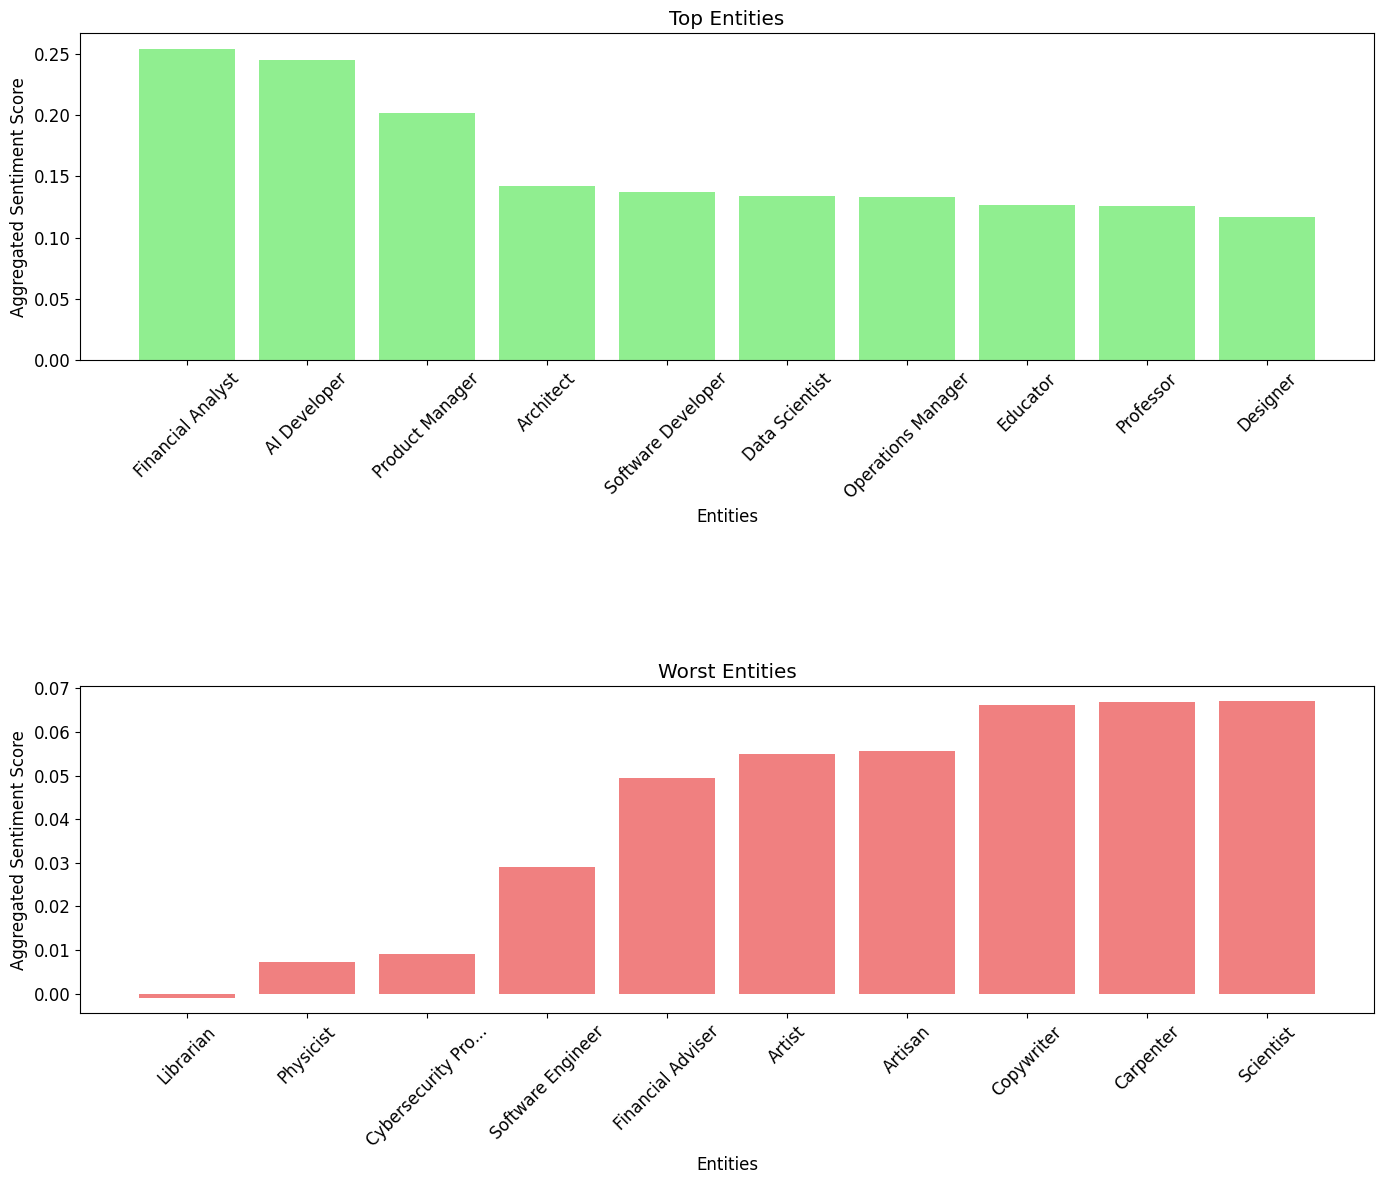

In [ ]:
entity_col = 'entities'
sentiment_col = 'sentiment_label_certainty'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'mean'
entity_types = ['JOB']
# Exclude words that are too general or repetitive. Exclude 'Editor' and 'Writer' as they appear frequently in the context of news articles.
exclude_entities = ['Analyst', 'Project Manager', 'Engineer', 'Editor', 'Writer', 'Lecturer', 'Athlete', 'Financial Professional']

top_n = 10
min_count = 100


plot_top_worst_entities(
    df=df_merged_combined,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

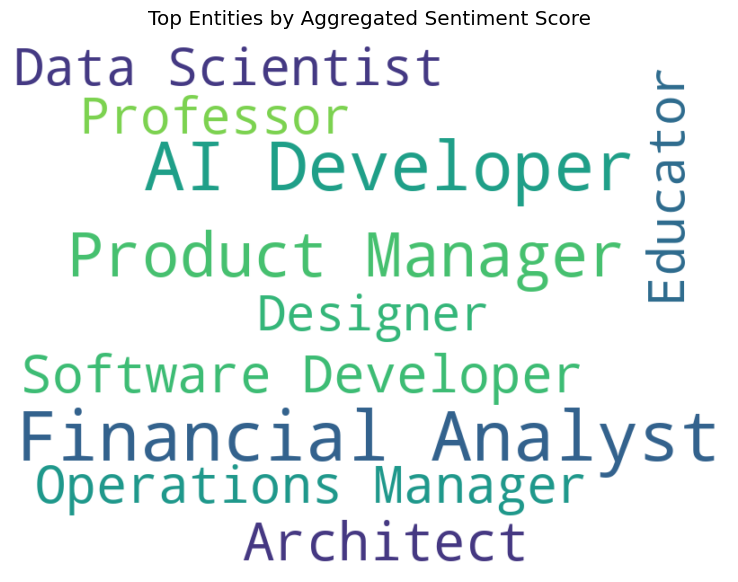

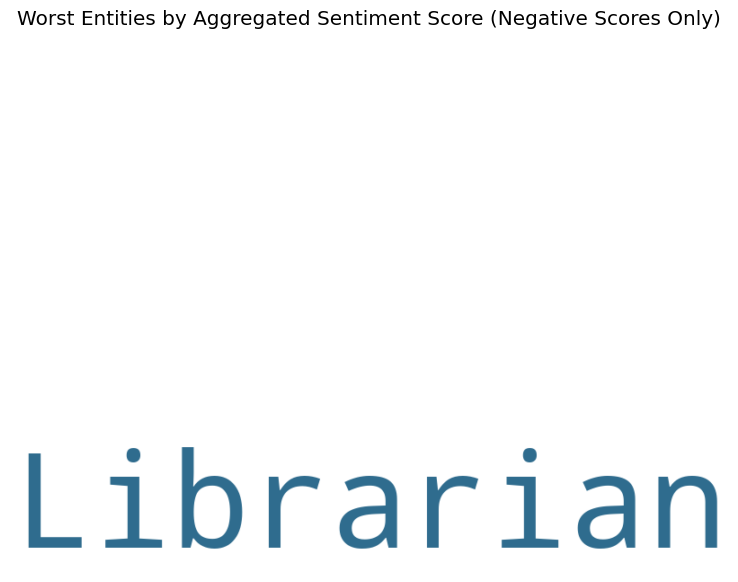

In [ ]:
plot_top_worst_entities_wordcloud(
    df=df_merged_combined,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

### Summary of AI Integration Sentiment Across Jobs:

#### **Successful AI Integration:**
- **Top Professions with Positive Sentiment:** Financial Analyst, AI Developer, Product Manager, Architect.
- **Reasons for Positive Sentiment:**
  - **Efficiency Gains:** AI helps automate repetitive and time-consuming tasks, allowing professionals to focus on strategic and creative aspects.
  - **Enhanced Decision-Making:** Data-heavy roles like Financial Analyst and AI Developer leverage AI for predictive analytics, insights generation, and innovative problem-solving.
  - **Industry Evolution:** These roles are at the forefront of industries that embrace AI as a growth enabler, fostering job security and new opportunities.

#### **Unsuccessful AI Integration:**
- **Top Professions with Negative Sentiment:** Librarian, Artist, Copywriter, Carpenter, Scientist.
- **Reasons for Negative Sentiment:**
  - **Automation Threat:** Manual and routine-driven roles like Carpenter and Librarian face potential replacement as AI-driven systems become more capable.
  - **Creative Disruption:** Creative jobs, such as Artist and Copywriter, are impacted by AI-generated content, raising concerns over originality, job relevance, and authenticity.
  - **Job Uncertainty:** Perception of AI as a replacement rather than a tool creates resistance and fear among professionals in these fields.

#### **Key Insights:**
1. **AI as an Enabler vs. Threat:**
   - Positive sentiment reflects roles where AI is viewed as a productivity enabler or collaborator.
   - Negative sentiment indicates fear or skepticism toward AI's impact on traditional skillsets and roles.

2. **Creative Industries Face Unique Challenges:**
   - Creative roles require strategies to integrate AI as a tool for amplifying originality rather than replacing it.

3. **Call for Reskilling:**
   - Affected professions must adapt to AI-driven changes through upskilling initiatives and exploring hybrid roles that combine human creativity with AI capabilities.

4. **Future Opportunities:**
   - Roles embracing AI are likely to shape future industry landscapes, emphasizing adaptability, innovation, and collaboration between humans and AI.

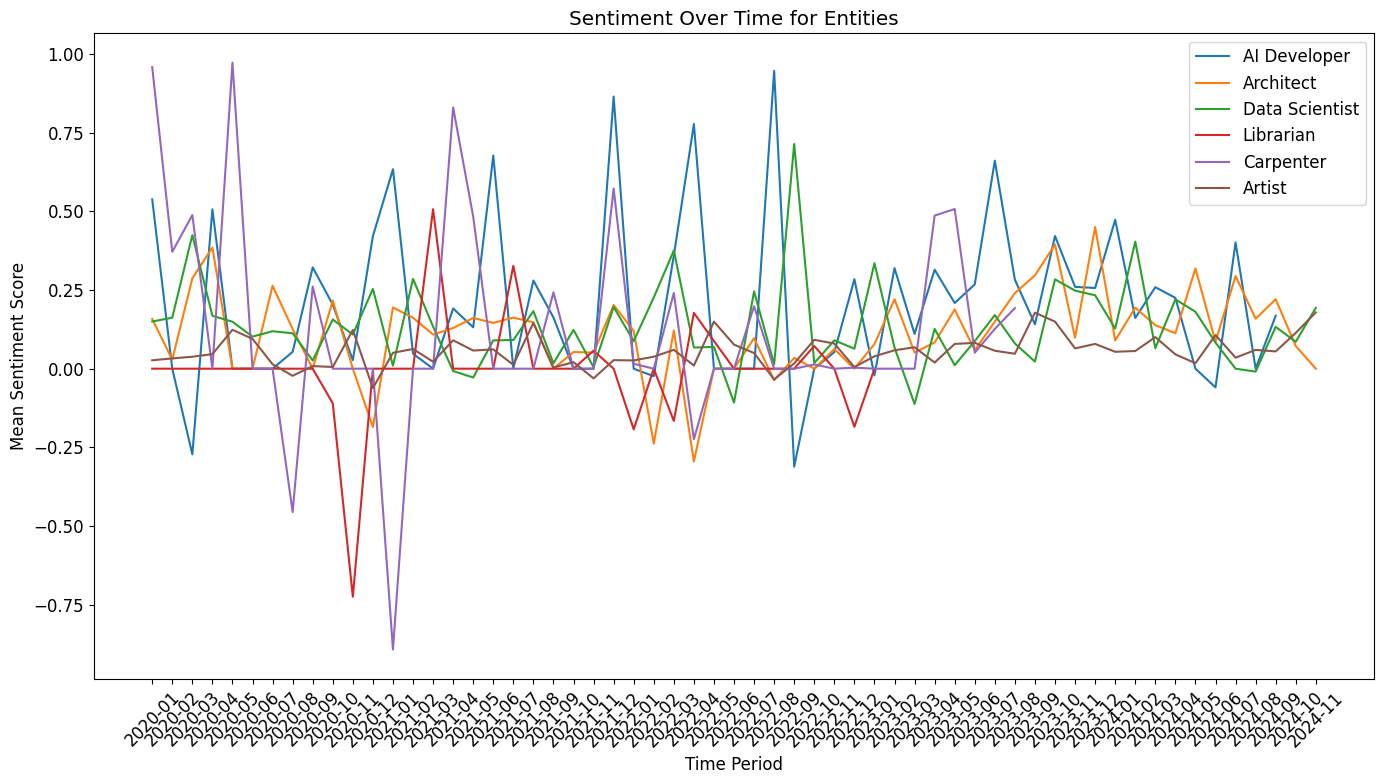

In [ ]:
# Sentiment Score over time for interesting JOB

top_names = ['AI Developer', 'Architect', 'Data Scientist', 'Librarian', 'Carpenter', 'Artist']

plot_individual_entity_sentiment_over_time(
    df=df_merged_combined,
    period_col='year_month',
    sentiment_col=sentiment_col,
    entities=top_names,
    entity_types=entity_types,
    aggregation=aggregation_method
)

In [ ]:
# What happend to Carpenter in 2021-01?
df_filtered_entity = filter_df_by_entity_and_type(df_merged_combined, 'Carpenter', 'JOB')
df_filtered_entity[df_filtered_entity['year_month'] == '2021-02'][['year_month', 'sentence', 'entities', 'sentiment_label_certainty']]

year_month  \
2933157    2021-02   
4754195    2021-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sentence  \
2933157                                                                  More Coverage L.A. Unified gets 100 doses but needs thousands to reopen schools Signs of hope as virus cases drop in California Entertainment Arts Male Buffy stars back Charisma Carpenter others alleging misconduct by Joss Whedon Entertainment Arts Male Buffy stars back Charisma Carpenter others alleging misconduct by Joss Whedon David Boreanaz Adam Busch Tom Lenk and Danny Strong address Whedons alleged misconduct on social media.   
4754195  Impact Analysis InForGrowth Search for Recent Posts Global Substation Automation and Integration Market 2020 Share Size Import Export Growth and Outlook by 2025 Surface Mount Technology Market Analysis Type Size Trends Key Players and Forecast 2017 to 2025 Controlled Expansion Alloys Market Strategic Assessment And Forecast Till 2026 Sandvik National Electronic Alloys Hitachi Metals Mitsubishi Materials Nippon Yakin Carpenter Technology Corporation Precious Metal Refining Services Market Siz...   

                                                                                  entities  \
2933157                      [[Entertainment, IND], [Social Media, IND], [Carpenter, JOB]]   
4754195  [[Healthcare, IND], [Insurance, IND], [Law, IND], [Metal, IND], [Carpenter, JOB]]   

         sentiment_label_certainty  
2933157                  -0.910784  
4754195                   0.000000

In [ ]:
# What happend to Librarian in 2020-11?
df_filtered_entity = filter_df_by_entity_and_type(df_merged_combined, 'Librarian', 'JOB')
df_filtered_entity[df_filtered_entity['year_month'] == '2021-02'][['year_month', 'sentence', 'entities', 'sentiment_label_certainty']]

Empty DataFrame
Columns: [year_month, sentence, entities, sentiment_label_certainty]
Index: []

In [ ]:
# What happend to Librarian?
df_ai = filter_rows_by_words(df_merged_combined, 'sentence', 'AI')
filter_df_by_entity_and_type(df_ai, 'Librarian', 'JOB')[['year_month', 'sentence', 'entities', 'sentiment_label_certainty']]

year_month  \
88709      2020-04   
202879     2024-01   
265521     2023-12   
406957     2024-01   
546564     2023-11   
1387052    2023-09   
1387058    2023-09   
1387067    2023-09   
1601647    2023-09   
1601653    2023-09   
1601662    2023-09   
1690805    2024-08   
2144514    2024-10   
2301808    2023-03   
3118119    2023-03   
3563551    2023-07   
4541955    2024-07   
4541968    2024-07   
4541970    2024-07   
4541978    2024-07   
4541982    2024-07   
4541983    2024-07   
4541997    2024-07   
5846582    2023-06   
6071584    2023-05   
6123859    2023-12   
6504815    2024-09   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sentence  \
88709                                                                                                                                                                                                                                                                                                                              No Jitter Advertise With Us AI Automation Metamorphosing Knowledge Management with AI In the corporate world knowledge management has long since portrayed the image of an old librarian.   
202879                                                                                                                                                                                                                                                                                                                                                                                                                                          The first is the AI librarian which learns from a variety of online sources.   
265521                                                                                                                                                                                                                                                          Look at AI as a personal assistant or agent and in that capacity it could be if it is used well like having another librarian or tutor at your call democratizing access to services that are really incredibly expensive to promote and difficult to scale.   
406957                                                                                                                                                                                                                                                                                                      Cheaters can abuse AI or be used to empower life-long learners with targeted cited and specific information that would be nearly impossible for one person to find without the help of a professional librarian.   
546564   A conversation with Marquettes City Commission election Early voting successfully concludes in Michigan Area winter parking bans begin Time to clean out medicine cabinets for National Indigenous Peoples Day Celebrated at NMU Top Stories More Stories Israel-Hamas fighting heats up in Gaza City accelerating A conversation with Marquettes City Commission election Funeral home stored bodies for 4 years deceived 8 dead in crash after police chased a suspected human Jury finds man not guilty of as...   
1387052                                                                Contacts Jenna Fortunati email protected Related Continue Reading Previous T2 Reveals Official Brand Pebble Opens to the WorldNext HanesBrands Announces Evaluation of Strategic Options for Global Champion Business Related Stories AI CAD News Ultra 

"Social Media Software Software Development Space Industry Space Optics Spatial Intelligence SSD Storage Streaming Supply Chain Technology Threat Detection Touchscreen Training Transformation Video Conferencing Video Intelligence Video Wall VOD Voice Generation VPN VR Wearable Tech Web Web 3.0 Webcam Wi-Fi Windows Wireless Workflow Workforce Workplace You may have missed AI CAD News Ultra Librarian to Dramatically Reduce CAD Model Build Times with New AI-Driven Part Creation Methodology AI Cy.."

The text highlights **AI's impact on librarians** in the context of **reducing CAD model build times** through an **AI-driven part creation methodology**. It suggests that advancements in AI are transforming traditionally manual, time-consuming tasks (like cataloging or model creation) into automated processes, which could:

1. **Increase efficiency:** Tasks like managing CAD models and other digital assets can be completed much faster with AI.
2. **Shift responsibilities:** Librarians in digital or technical roles may need to adapt to focus on managing AI systems rather than performing the tasks AI automates.
3. **Potential job redefinition:** The term "librarian" may evolve in contexts like CAD, emphasizing technical expertise and AI oversight.

This indicates a broader trend of AI reshaping roles that rely heavily on data management and structuring.

The **negative sentiment** associated with librarians in the context of AI advancements likely stems from the following factors:

1. **Job Displacement Fears:** AI-driven automation in tasks like cataloging, data management, and digital model creation could lead to concerns about the redundancy of traditional librarian roles, particularly in technical or specialized areas like CAD libraries.

2. **Perception of Devaluation:** The emphasis on AI's efficiency might overshadow the human expertise librarians bring, creating a sentiment that their skills are undervalued or replaced.

3. **Skill Adaptation Pressure:** Librarians may feel pressured to rapidly adapt to new technologies, which can be seen as a challenge rather than an opportunity, especially for those not well-versed in AI or technical skills.

4. **Industry Shift:** AI's ability to handle traditionally manual librarian tasks could lead to the reallocation of resources away from human roles, fostering a perception of reduced job security.

This negative sentiment reflects concerns about the rapid pace of AI adoption and its impact on roles requiring nuanced human judgment and expertise.

### Sentiment by TECH

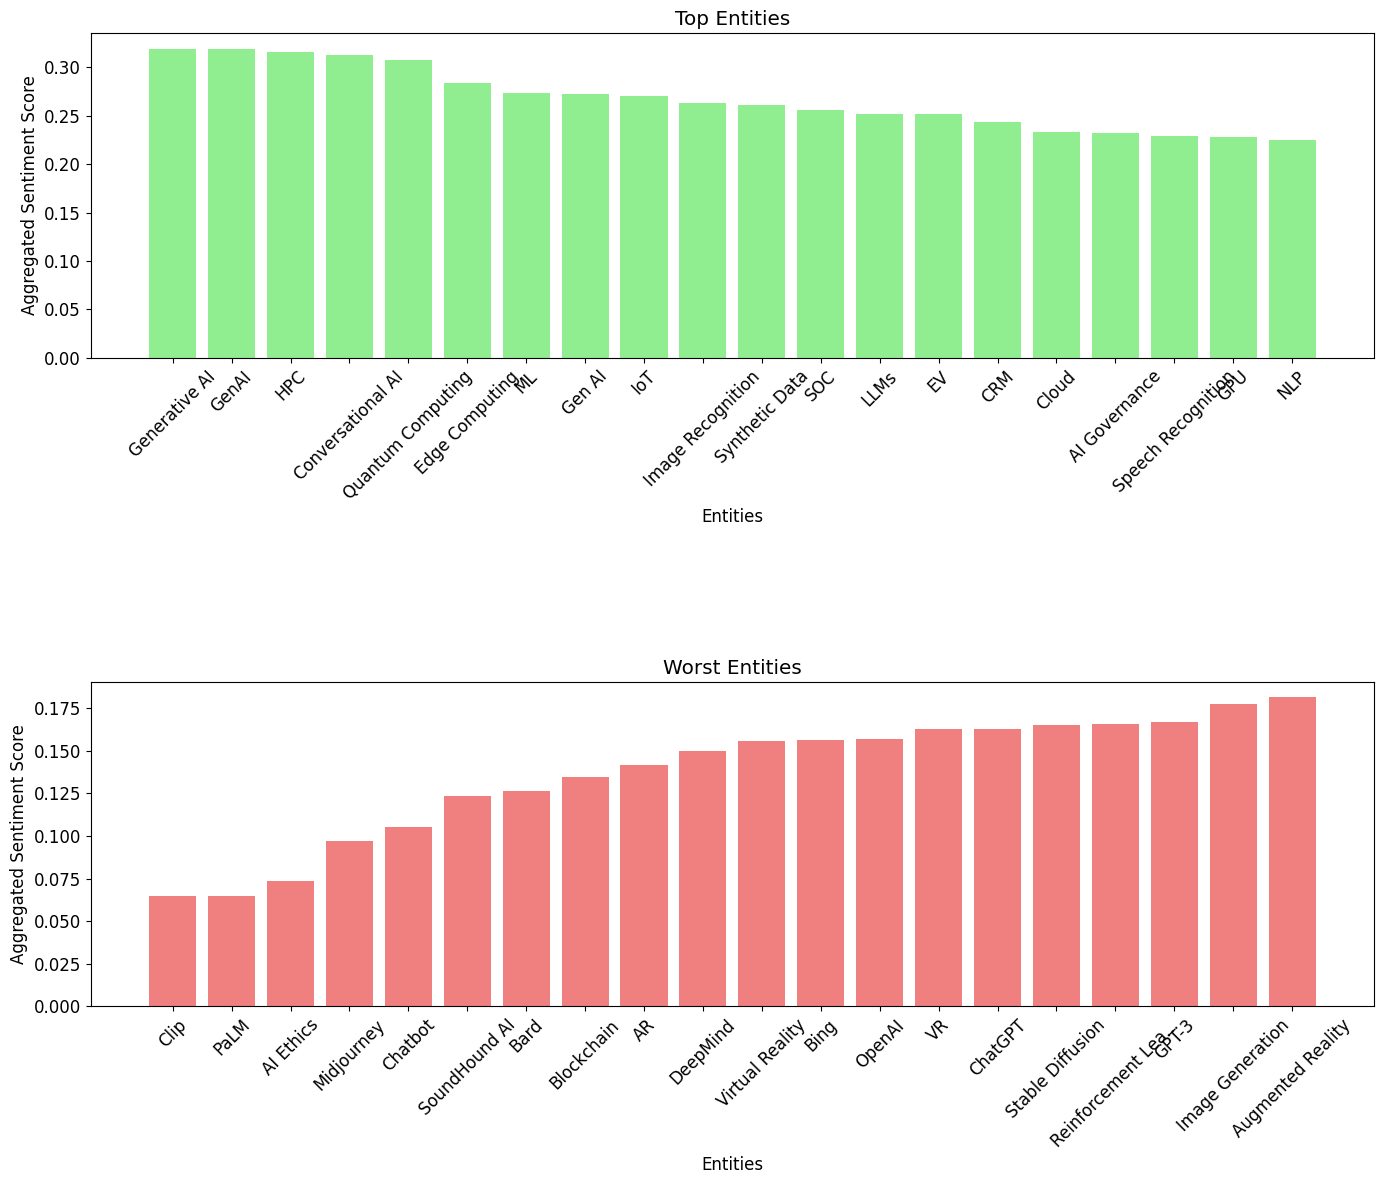

In [ ]:
entity_col = 'entities'
sentiment_col = 'sentiment_label_certainty'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'mean'
entity_types = ['TECH']
# Exclude words that are too general or repetitive. Exclude 'Editor' and 'Writer' as they appear frequently in the context of news articles.
exclude_entities = []

top_n = 20
min_count = 2000


plot_top_worst_entities(
    df=df_merged_combined,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

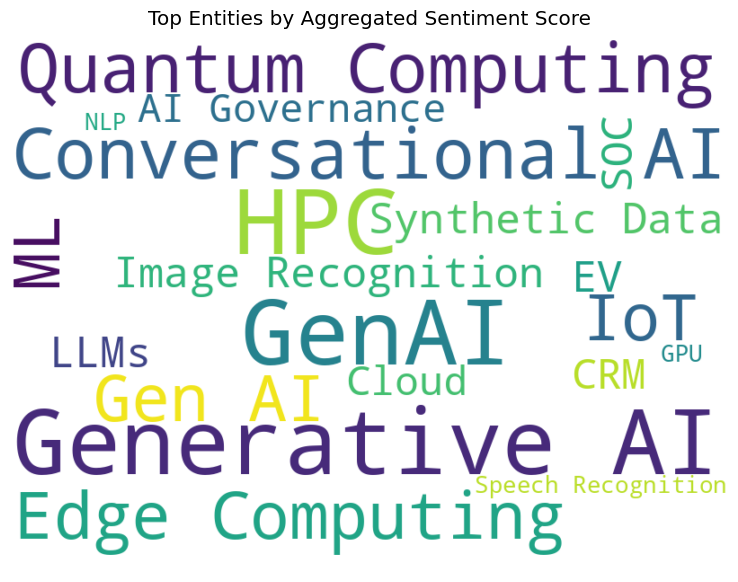

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [ ]:
# plot_top_worst_entities_wordcloud(
#     df=df_merged_combined,
#     entity_col=entity_col,
#     sentiment_col=sentiment_col,
#     aggregation=aggregation_method,
#     entity_types=entity_types,
#     exclude_entities=exclude_entities,
#     top_n=top_n,
#     min_count=min_count
# )

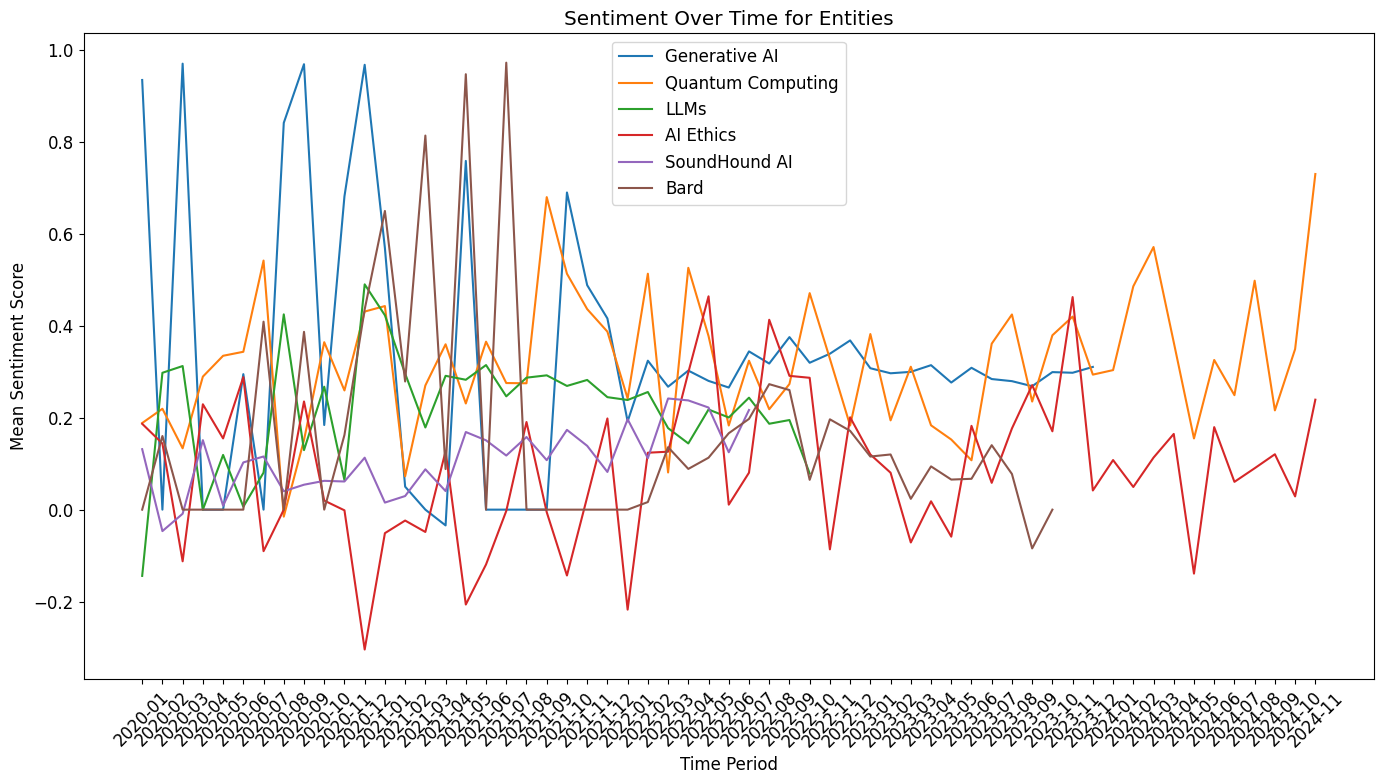

In [ ]:
# Sentiment Score over time for interesting TECH

top_names = ['Generative AI', 'Quantum Computing', 'LLMs', 'AI Ethics', 'SoundHound AI', 'Bard']

plot_individual_entity_sentiment_over_time(
    df=df_merged_combined,
    period_col='year_month',
    sentiment_col=sentiment_col,
    entities=top_names,
    entity_types=entity_types,
    aggregation=aggregation_method
)

This chart tracks the **mean sentiment scores over time** for key entities related to artificial intelligence and emerging technologies:

### Key Observations:
1. **High Sentiment for Quantum Computing**:
   - Quantum Computing shows generally high sentiment, with significant spikes, indicating positive coverage likely driven by breakthroughs or advancements.
   
2. **Fluctuating Sentiments**:
   - Entities like **Generative AI**, **AI Ethics**, and **Bard** exhibit frequent fluctuations, reflecting both positive and negative coverage. This may stem from controversies, ethical concerns, or shifting public opinion.

3. **AI Ethics Sentiment Challenges**:
   - AI Ethics consistently struggles with low sentiment scores compared to others. This suggests ongoing debates or criticism regarding fairness, bias, or ethical implementation in AI systems.

4. **Stable Positive Sentiment for LLMs (Large Language Models)**:
   - LLMs maintain a relatively stable sentiment around a positive baseline, reflecting consistent progress and acceptance in the field.

5. **SoundHound AI Sentiment Variability**:
   - SoundHound AI has lower scores with frequent dips, possibly linked to criticism or struggles in its application or competitive landscape.

### Insights:
- **Quantum Computing and Generative AI** dominate positive sentiment peaks, showing their prominence in breakthroughs.
- **AI Ethics and SoundHound AI** face more criticism, likely tied to concerns about the societal impact and challenges in adoption.
- Sentiment trends align with **technological hype cycles**, reflecting how innovation or controversy drives public and media perception over time.

Identify technologies and AI solutions that might be affecting the employment landscape

In [ ]:
df_merged_combined.head(5)

article_id  sentence_id  \
0           1            1   
1           1            2   
2           1            3   
3           1            4   
4           1            5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0  Observation Simulation And AI Join Forces To Reveal A Clear Universe - SpaceRef Home NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation And AI Join Forces To Reveal A Clear Universe Press Release - Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and f...   
1                                                                                                                                                                                                                                                                                                       CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes.   
2                                                                                                                                                                                                      After extensive training and testing on large mock data created by supercomputer simulations they then applied this new tool to actual data from Japan's Subaru Telescope and found that the mass distribution derived from using this method is consistent with the currently accepted models of the Universe.   
3                                                                                                                                                                                                                                                                                                                                                                                                                       This is a powerful new tool for analyzing big data from current and planned astronomy surveys.   
4                                                                                                                                                                                                                                                                                                                                                                         Wide area survey data can be used to study the large-scale structure of the Universe through measurements of gravitational lensing patterns.   

             entities   entities_combined  sentiment_score_DistilBERT  \
0                  []                  []                    0.989424   
1                  []                  []                    0.541715   
2                  []                  []                    0.933930   
3  [[Big Data, TECH]]  [[Big Data, TECH]]                    0.789955   
4                  []                  []                    0.990115   

  sentiment_label_DistilBERT  sentiment_label_certainty       date  \
0                    NEUTRAL                   0.000000 2021-07-05   
1                   POSITIVE                   0.541715 2021-07-05   
2                    NEUTRAL                   0.000000 2021-07-05   
3                    NEUTRAL                   0.000000 2021-07-05

Filter rows where 'TECH' appears in any of the tuples inside the entities column

In [ ]:
def filter_rows_by_entity_type(df, column, keyword):
    """
    Filters the DataFrame rows based on the presence of a specific keyword in the tuples of a column.

    Args:
        df (pd.DataFrame): The DataFrame to filter.
        column (str): The name of the column containing lists of tuples.
        keyword (str): The keyword to search for in the tuples.

    Returns:
        pd.DataFrame: A DataFrame containing only the rows where the keyword is found in the specified column.
    """
    filtered_df = df[df[column].apply(lambda entities: any(keyword in entity for entity in entities))]
    return filtered_df

In [ ]:
# Apply the function to filter rows where 'TECH' appears in the `entities` column
df_ai = filter_rows_by_entity_type(df_merged_combined, 'entities', 'TECH')
df_ai.head(5)

article_id  sentence_id  \
3            1            4   
17           1           18   
20           1           21   
95           3            1   
98           3            4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               sentence  \
3                                                                                                                                                                                                                                                                                                                                                                                                                        This is a powerful new tool for analyzing big data from current and planned astronomy surveys.   
17                                                                                                                                                                                                                                                                                                                       comments Masato Shirasaki the leader of the team In this era of big data we need to step across traditional boundaries between specialties and use all available tools to understand the data.   
20                                                                                                                                                                                                                                                                                             Noise reduction for weak lensing mass mapping an application of generative adversarial networks to Subaru Hyper Suprime-Cam first-year data in the June 2021 issue of Monthly Notices of the Royal Astronomical Society.   
95  Flash for AI - 28 March 2024 - EBV Electrolink - Dataweek Home About us Back issues E-book PDF Subscribe Advertise EMP Handbook Categories Editor's Choice Multimedia Videos AI ML Analogue Mixed Signal LSI Circuit System Protection ComputerEmbedded Technology Design Automation DSP Micros Memory Edge Computing IIoT Electronics Technology Enclosures Racks Cabinets Panel Products Events Interconnection Manufacturing Production Technology Hardware Services News Opto-Electronics Passive Components...   
98                                                                                                                                                                                                                                                                                                                                                                                                   However artificial intelligence AI has rapidly become a colloquialism thanks to tools like ChatGPT and Midjourney.   

                                                                                                   entities  \
3                                                                                        [[Big Data, TECH]]   
17                                                                                       [[Big Data, TECH]]   
20                                                                [[Generative Adversarial Networks, TECH]]   
95  [[Hardware, IND], [Manufacturing, IND], [Editor, JOB], [ML, TECH], [Edge Computing, TECH], [IoT, TECH]]   
98                                                                    [[ChatGPT, TECH], [Midjourney, TECH]]   

                                                                                          entities_combined

Create a dataframe that every row has TECH under entities AND words_to_search under sentence.

In [ ]:
# List of words to search for
words_to_search = ['employ', 'employed', 'employs', 'employing', 'employment',
                   'employer', 'employee', 'hire', 'hiring', 'hired', 'hires']

# Apply the filter function to the sentence column of df_ai
filtered_df_ai = filter_rows_by_words(df_ai, 'sentence', words_to_search)

# Display the filtered rows
filtered_df_ai.head()

article_id  sentence_id  \
196            4            3   
5659         119           44   
6227         129            5   
6757         141            6   
9230         193           17   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 sentence  \
196                                                                                                                                                                                                                                                                                                                                                                                     Scientists identified 926 spill events from two wastewater treatment plants over an 11-year period by employing machine learning.   
5659                                                                                                                                                                                                                                                                                                                                              AI image recognition is employed in traffic management public safety and environmental monitoring contributing to the development of smarter and more efficient cities.   
6227  Best AI Trading Bots Best AI Video Editors Best AI Voice Generators Best AI Website Builders Best AI 3D Generators Prompt Engineering Best AI Text-to-Image Prompt Guides Best Prompt Marketplaces and Hubs Best ChatGPT Prompts Best ChatGPT Games Best Stable Diffusion Prompts Best Midjourney Prompts Best AI Prompt Generators Top 100 Words Detectable by AI Detectors Metaverse Post News News Report AMD Projects 2 Billion Sales in 2024 Launches Chips for Generative AI and Supercomputers News Repor...   
6757                                                                                                                                                                                                                                                                                                                                                                 OpenAI is a client of Scale AI and Remotasks labeling data for their apps ChatGPT and DALL-E. Social networks hire platforms for content moderation.   
9230                                                                                                                                                                                                                                As opposed to legacy systems which heat a filament to over 2000 degrees Celsius to create an electron cloud that produces X-rays when pulled toward a metal anode the Arc employs a field emission array of 100 million molybdenum nano-cones that generate electrons at low voltage.   

                                                                                                        entities  \
196                                                                                   [[Machine Learning, TECH]]   
5659                                                                                 [[Image Recognition, TECH]]   
6227  [[Engineering, IND], [Generative AI, TECH], [ChatGPT, TECH], [Stable Diffusion, TECH], [Midjourney, TECH]]   
6757                                                                           [[ChatGPT, TECH], [OpenAI, TECH]]   
9230                                                                               [[Metal, IND], [Cloud, TECH]]   

                                                       

In [ ]:
filtered_df_ai.shape

(9362, 12)

In [ ]:
filtered_df_ai.sentiment_label_DistilBERT.value_counts()

sentiment_label_DistilBERT
NEUTRAL     5811
POSITIVE    3079
NEGATIVE     472
Name: count, dtype: int64

To get the value counts for entities under each sentiment category, you can group the data by sentiment_label_DistilBERT and then count the occurrences of each entity within those groups.

In [ ]:
# Initialize a dictionary to store results
entity_counts_by_sentiment = {}

# Iterate through each sentiment category
for sentiment, group in filtered_df_ai.groupby('sentiment_label_DistilBERT'):
    # Flatten the list of entities for the current sentiment group
    entities_flat = [entity[0] for entities in group['entities'] for entity in entities]

    # Count occurrences of each entity
    entity_counts = pd.Series(entities_flat).value_counts()

    # Store in dictionary
    entity_counts_by_sentiment[sentiment] = entity_counts

# Display the results
for sentiment, counts in entity_counts_by_sentiment.items():
    print(f"Sentiment: {sentiment}")
    print(counts.head(10))  # Show the top 10 entities for each sentiment
    print("\n")

Sentiment: NEGATIVE
Generative AI         95
ChatGPT               92
Cybersecurity         88
OpenAI                80
Cloud                 73
Machine Learning      59
Chatbot               29
Internet of Things    26
Robotics              22
Social Media          22
Name: count, dtype: int64


Sentiment: NEUTRAL
Cybersecurity       1818
Cloud               1210
Machine Learning    1114
Blockchain          1080
Generative AI        939
Entertainment        932
ChatGPT              864
Energy               844
Fintech              715
OpenAI               713
Name: count, dtype: int64


Sentiment: POSITIVE
Generative AI                  860
Cloud                          656
Machine Learning               458
Cybersecurity                  412
ChatGPT                        283
Conversational AI              228
OpenAI                         184
Software                       163
Chatbot                        111
Natural Language Processing     99
Name: count, dtype: int64




For each sentiment, how are the TECH entities distributed?

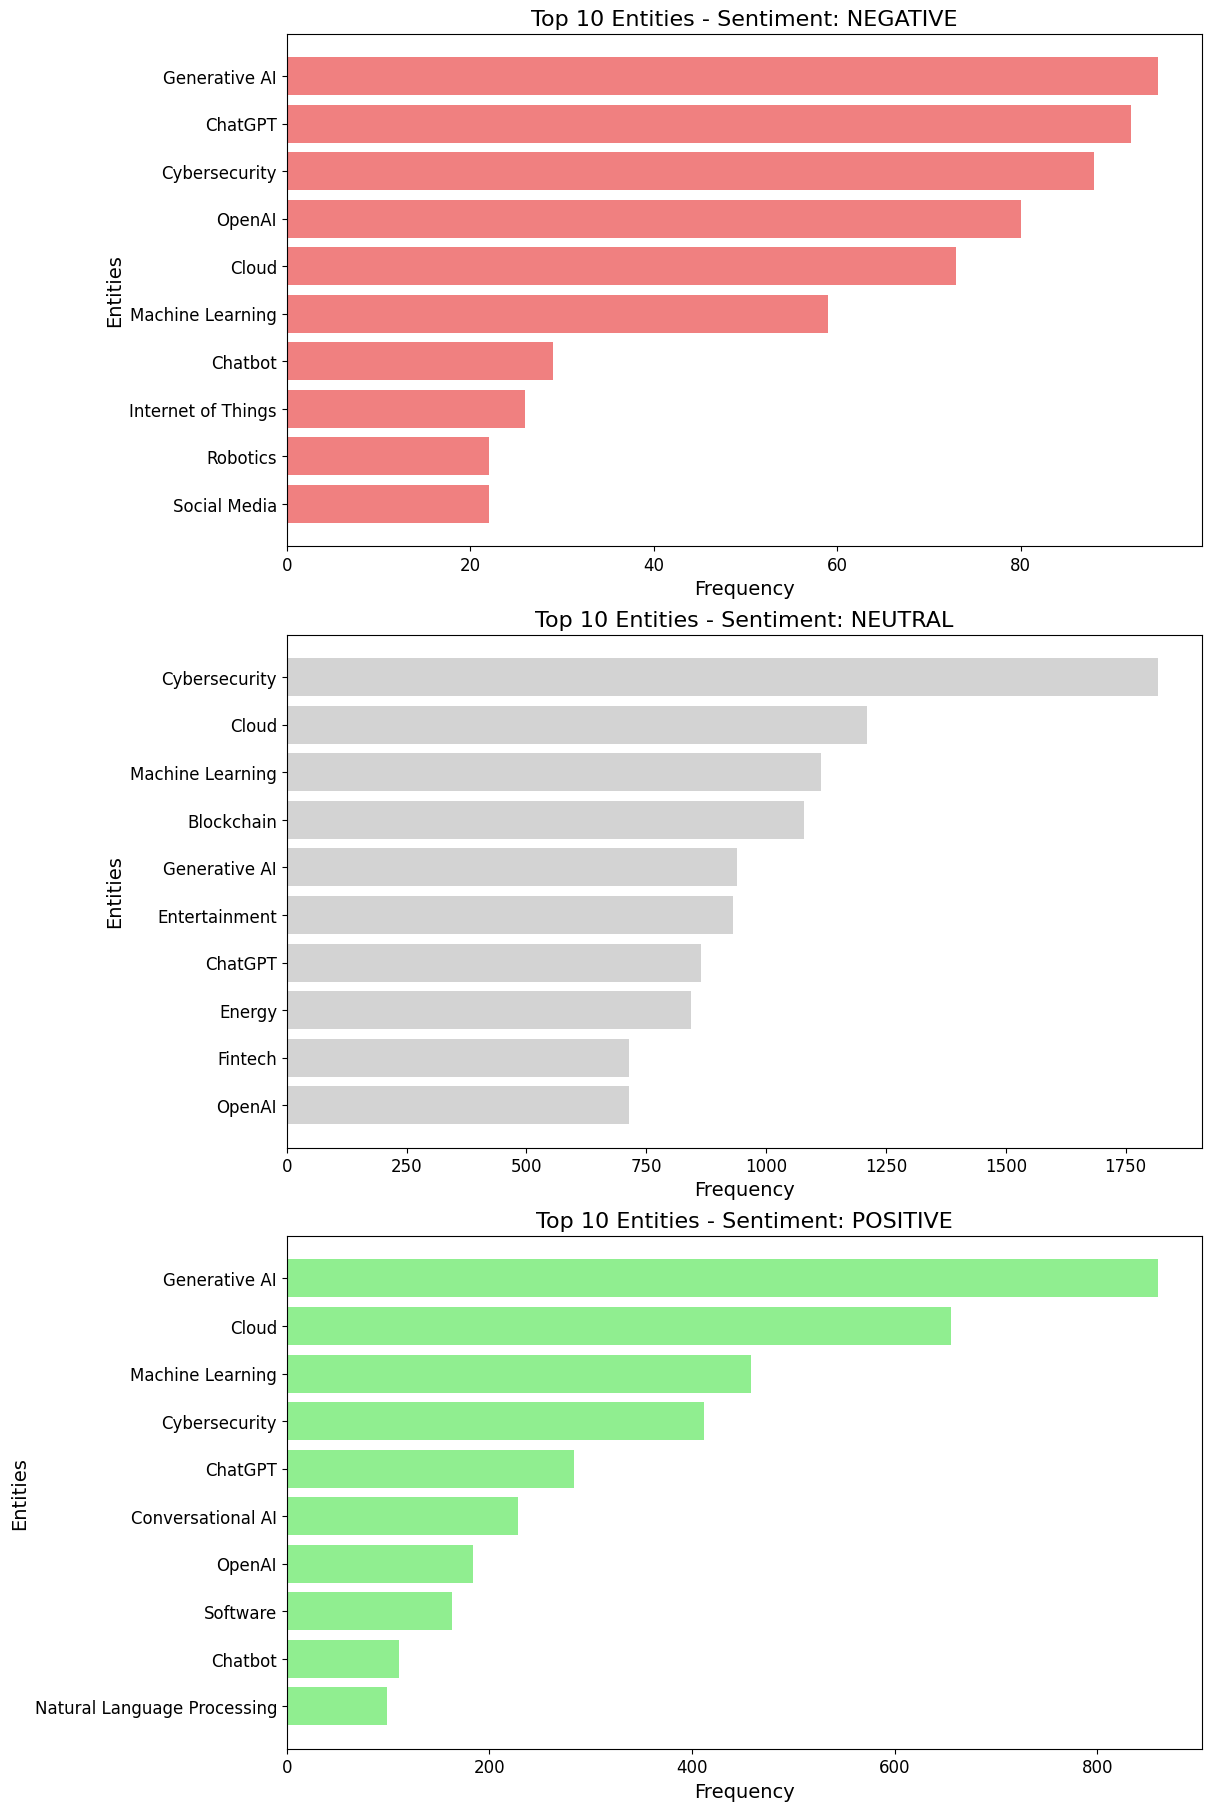

In [ ]:
import matplotlib.pyplot as plt

def plot_entities_by_sentiment(entity_counts_by_sentiment, top_n=10):
    """
    Visualize the top entities by sentiment using bar charts.

    Args:
        entity_counts_by_sentiment (dict): Dictionary with sentiments as keys and entity counts as values.
        top_n (int): Number of top entities to display for each sentiment.
    """
    # Set up a figure with subplots for each sentiment
    num_sentiments = len(entity_counts_by_sentiment)
    fig, axes = plt.subplots(num_sentiments, 1, figsize=(12, 6 * num_sentiments), constrained_layout=True)

    if num_sentiments == 1:
        axes = [axes]  # Ensure axes is a list for consistent indexing

    # Plot each sentiment
    for ax, (sentiment, counts) in zip(axes, entity_counts_by_sentiment.items()):
        # Get the top N entities
        top_entities = counts.head(top_n)

        # Plot a horizontal bar chart
        ax.barh(top_entities.index, top_entities.values, color='lightgreen' if sentiment == 'POSITIVE' else
                'lightcoral' if sentiment == 'NEGATIVE' else 'lightgray')
        ax.set_title(f"Top {top_n} Entities - Sentiment: {sentiment}", fontsize=16)
        ax.set_xlabel("Frequency", fontsize=14)
        ax.set_ylabel("Entities", fontsize=14)
        ax.tick_params(axis='y', labelsize=12)
        ax.invert_yaxis()  # Ensure the highest value is at the top

    # Display the plot
    plt.show()

# Call the function to visualize the results
plot_entities_by_sentiment(entity_counts_by_sentiment, top_n=10)

The results of entity counts under different sentiment categories (negative, neutral, positive) can provide insights into how technologies are perceived in relation to the employment landscape:

### Key Observations:
1. **Negative Sentiment**:
   - **Generative AI**, **ChatGPT**, **Cybersecurity**, and **OpenAI** are frequently mentioned with negative sentiment.
   - This suggests these technologies might be perceived as threats to employment (e.g., automation replacing jobs, AI displacing human workers, or cybersecurity concerns reducing job stability).

2. **Neutral Sentiment**:
   - **Cybersecurity**, **Cloud**, and **Machine Learning** dominate neutral sentiment.
   - This indicates these technologies might be considered as essential or stable aspects of the employment landscape, with neither strongly positive nor negative impacts.

3. **Positive Sentiment**:
   - **Generative AI**, **Cloud**, and **Machine Learning** lead in positive sentiment.
   - These technologies are likely seen as enablers of innovation, creating opportunities for specialized jobs (e.g., AI developers, cloud engineers, and data scientists).

---

### Analysis for Employment Impact:
1. **Technologies Creating Opportunities**:
   - **Generative AI**, **Cloud**, **Machine Learning**, and **Conversational AI** have strong positive sentiment.
   - This suggests they are driving job creation in areas like AI development, cloud management, and natural language processing.

2. **Technologies Perceived as Threats**:
   - **ChatGPT**, **Cybersecurity**, and **Robotics** appear with higher negative sentiment.
   - This reflects fears of automation replacing jobs or ethical challenges in AI deployment, which could affect employment negatively.

3. **Balanced Perception**:
   - **Cybersecurity** and **Machine Learning** appear across all sentiment categories, indicating they are reshaping jobs while maintaining overall stability in the employment landscape.

---

### Answer to the Question:
These results identify **Generative AI**, **ChatGPT**, **Cybersecurity**, **Machine Learning**, and **Cloud** as technologies significantly affecting the employment landscape. Their impacts vary:
- Positive: Creating new roles in AI, cloud computing, and cybersecurity.
- Negative: Raising concerns about job displacement due to automation and ethical challenges.
- Neutral: Reflecting their essential, stable role in modern industries.

Understanding these trends can guide policymakers and organizations in preparing the workforce for technological shifts.

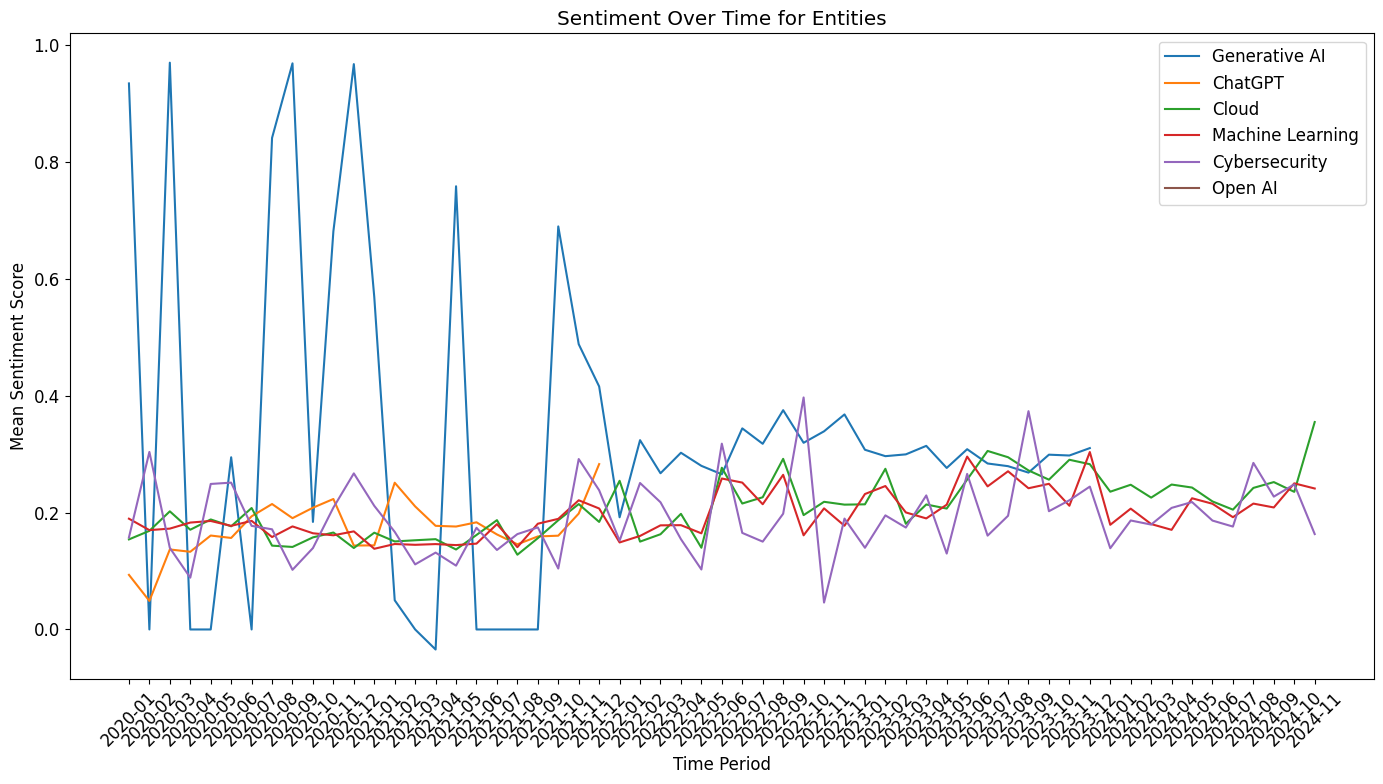

In [ ]:
# Sentiment Score over time for interesting TECH

top_names = ['Generative AI', 'ChatGPT', 'Cloud', 'Machine Learning', 'Cybersecurity', 'Open AI']

plot_individual_entity_sentiment_over_time(
    df=df_merged_combined,
    period_col='year_month',
    sentiment_col=sentiment_col,
    entities=top_names,
    entity_types=entity_types,
    aggregation=aggregation_method
)